# **Setup and Data Preparation**

In [ ]:
# Import necessary libraries
import torch
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
dataset = load_dataset("dair-ai/emotion")
test_data = dataset["test"]

# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=6, output_attentions=True)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)
model.eval()  # Set the model to evaluation mode


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

# **Prediction and Attention Analysis**

In [ ]:
# Define the prediction function
def predict_with_attention(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    return outputs.logits, outputs.attentions

# Define the attention analysis function
def analyze_attention(attentions, input_ids, tokenizer, head_num, block_num):
    attention_matrix = attentions[block_num].squeeze(0)
    padding_token_idx = tokenizer.pad_token_id
    padding_mask = (input_ids != padding_token_idx).unsqueeze(-1)
    masked_attention = attention_matrix * padding_mask
    cls_attention = masked_attention[head_num][0, :]
    attention_sum = cls_attention.sum()
    normalized_attention = cls_attention / attention_sum if attention_sum > 0 else cls_attention
    return normalized_attention.cpu().detach().numpy()


In [ ]:
# Analysis Functions

def attention_to_key_words(attention_weights, tokens, key_words):
    """Analyzes attention given to specified key words."""
    attention_scores = {}
    for word in key_words:
        if word in tokens:
            idx = tokens.index(word)
            attention_scores[word] = attention_weights[idx]
    return attention_scores

emotion_words = ['happy', 'sad', 'angry', 'excited', 'joyful', 'elated', 'thrilled', 'ecstatic', 'euphoric',
                 'depressed', 'gloomy', 'melancholic', 'mournful', 'irritated', 'annoyed', 'furious', 'rageful',
                 'enthusiastic', 'eager', 'animated', 'spirited', 'fearful', 'scared', 'terrified', 'anxious',
                 'apprehensive', 'surprised', 'astonished', 'amazed', 'shocked', 'startled', 'disgusted',
                 'revolted', 'repulsed', 'sickened', 'nauseated', 'content', 'satisfied', 'pleased', 'comfortable',
                 'relaxed', 'hopeful', 'optimistic', 'positive', 'upbeat', 'confident', 'confused', 'perplexed',
                 'baffled', 'bewildered', 'puzzled']  # Extend this list with emotion-related words

def calculate_attention_stats(attention_weights):
    """Calculates mean and standard deviation of attention weights."""
    return np.mean(attention_weights), np.std(attention_weights)


# **Heat Map visual**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the heatmap plotting function
def plot_attention_heatmap(attention_weights, tokens):
    plt.figure(figsize=(20, 1))
    sns.heatmap(attention_weights[None, :], cmap='viridis', xticklabels=tokens, yticklabels=False, cbar=True)
    plt.xticks(rotation=90)
    plt.show()



# **Run Experiment and Analyze**

**Setup for Experiment and Analysis**

In [ ]:
# Define emotion-related words for analysis
emotion_words = [
    'happy', 'sad', 'angry', 'excited', 'joyful', 'elated', 'thrilled', 'ecstatic', 'euphoric',
    'depressed', 'gloomy', 'melancholic', 'mournful', 'irritated', 'annoyed', 'furious', 'rageful',
    'enthusiastic', 'eager', 'animated', 'spirited', 'fearful', 'scared', 'terrified', 'anxious',
    'apprehensive', 'surprised', 'astonished', 'amazed', 'shocked', 'startled', 'disgusted',
    'revolted', 'repulsed', 'sickened', 'nauseated', 'content', 'satisfied', 'pleased', 'comfortable',
    'relaxed', 'hopeful', 'optimistic', 'positive', 'upbeat', 'confident', 'confused', 'perplexed',
    'baffled', 'bewildered', 'puzzled', 'rotten', 'ambitious', 'uncomfortable', 'anger', 'immature',
    'excitement', 'grumpy', 'agitated', 'invaded', 'helpless', 'supportive', 'mellow', 'outraged',
    'insecure', 'restless', 'productive', 'peaceful', 'welcomed', 'virtuous', 'delighted', 'affectionate'
    'grumpy','mellow','tired','mad', 'rude', 'virtuous', 'honoured', 'reassured', 'friendly'
]

# Containers for post-experiment analysis
attention_details = []
emotion_word_attention = {word: [] for word in emotion_words}
correct_predictions_attention = []
incorrect_predictions_attention = []


**Experiment Loop with Analysis and Heatmap Visualization**

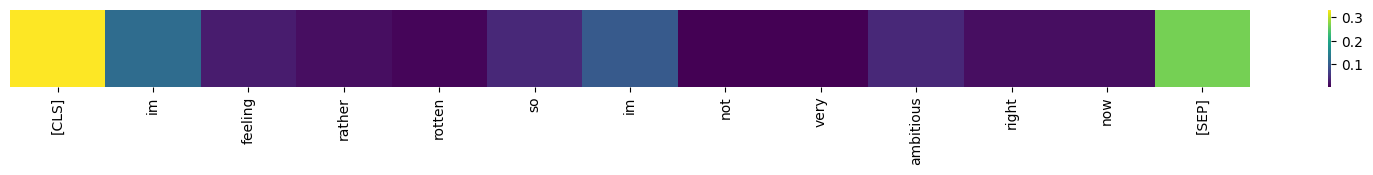

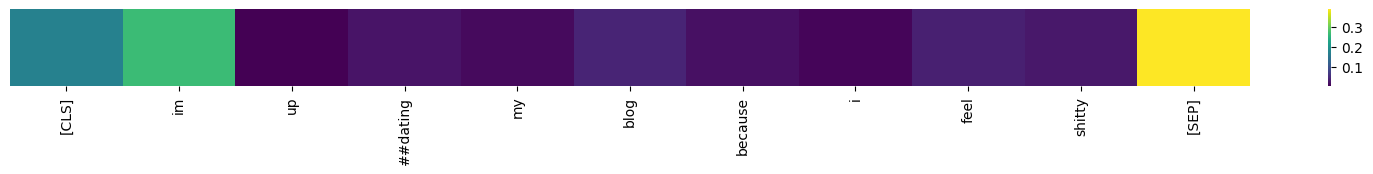

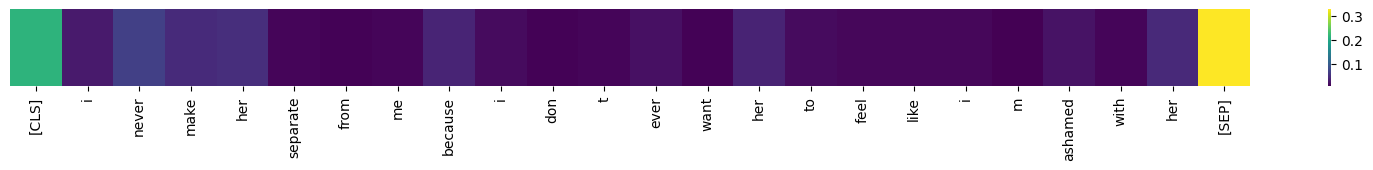

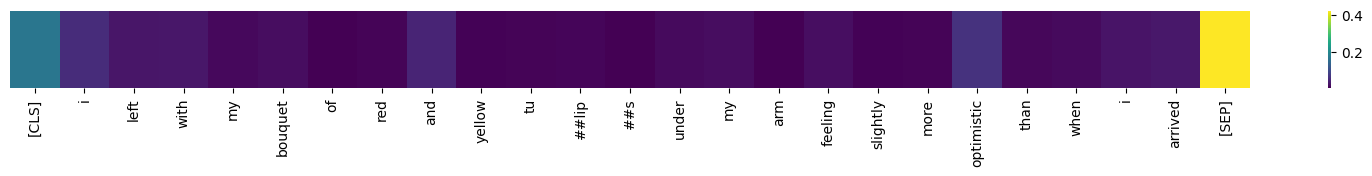

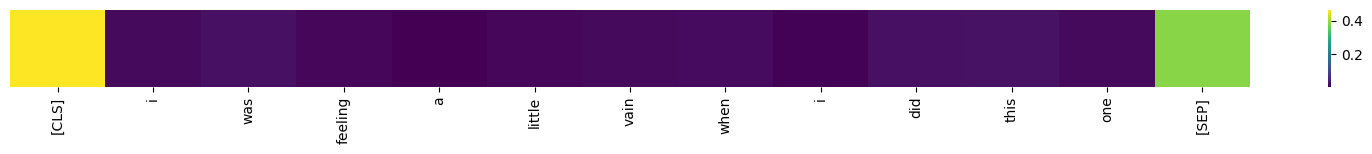

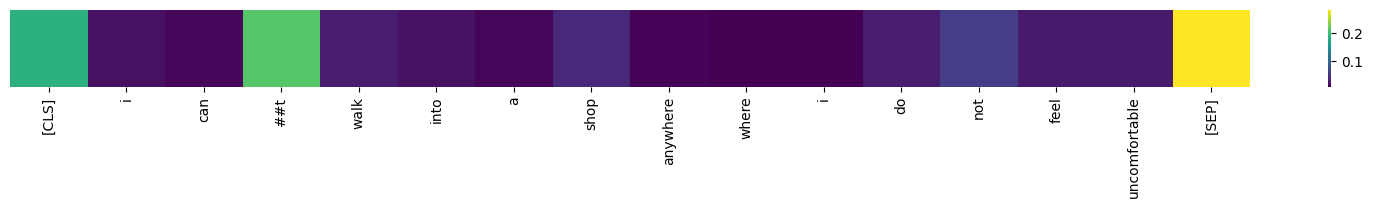

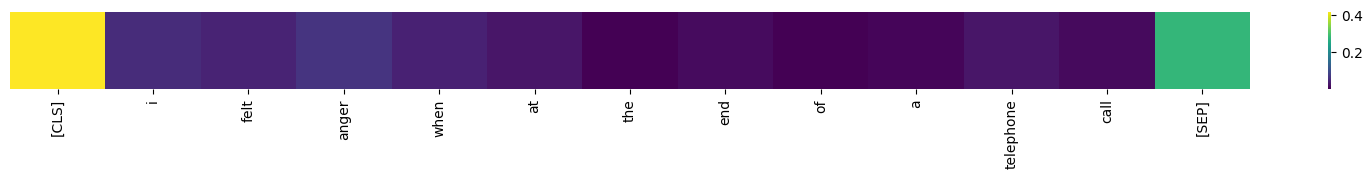

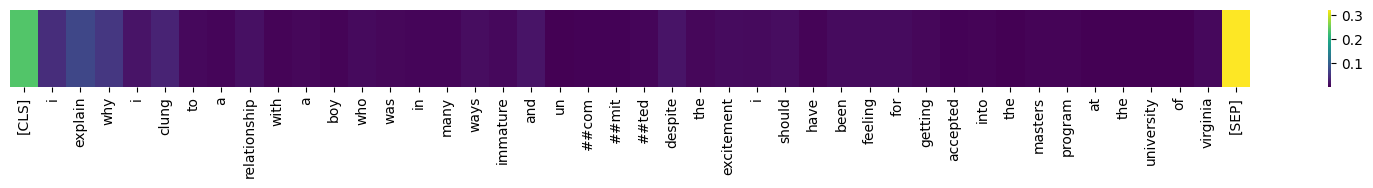

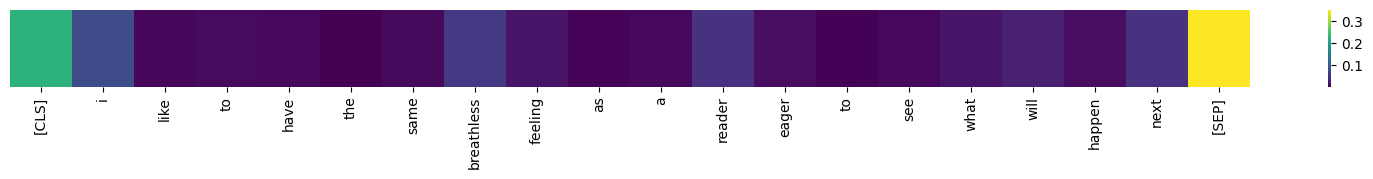

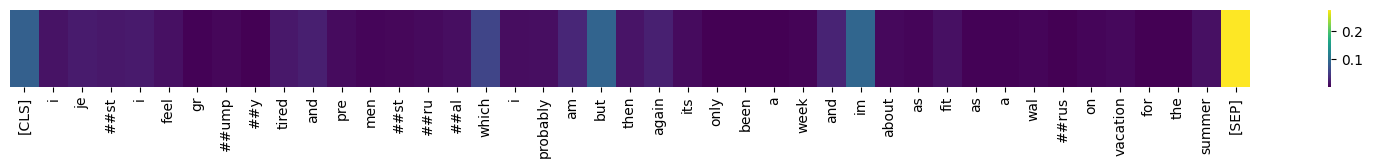

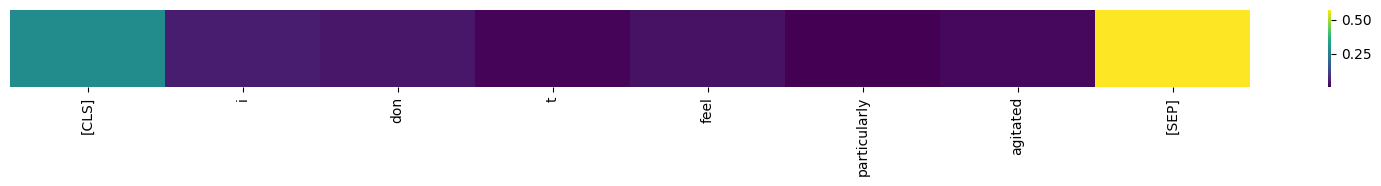

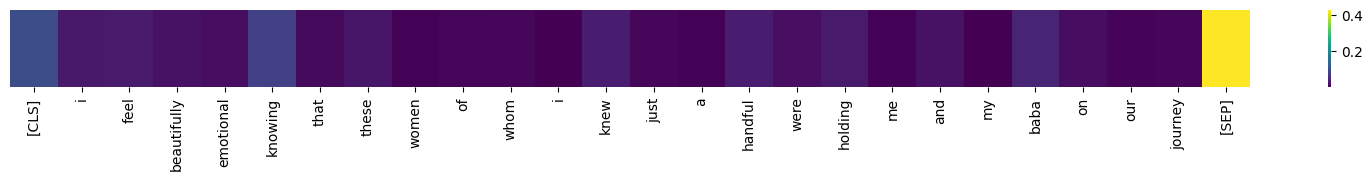

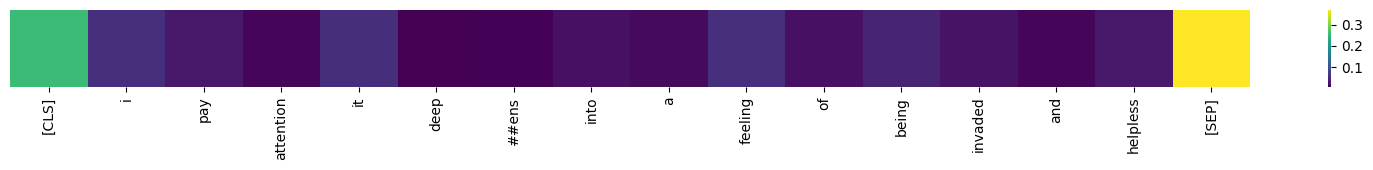

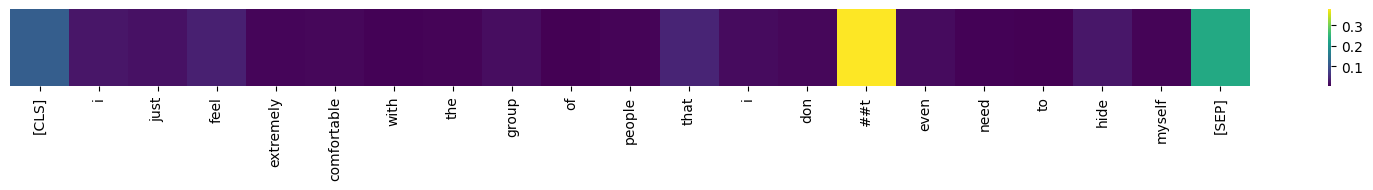

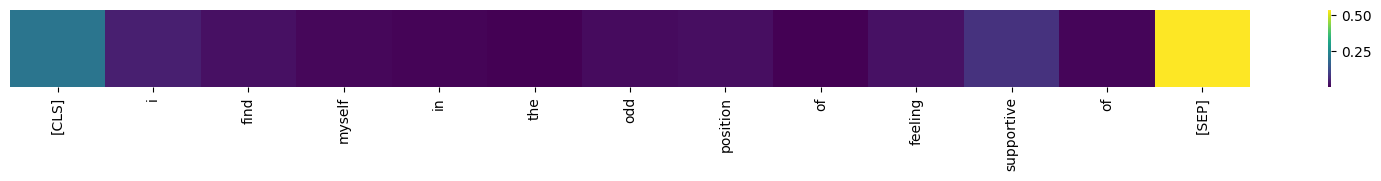

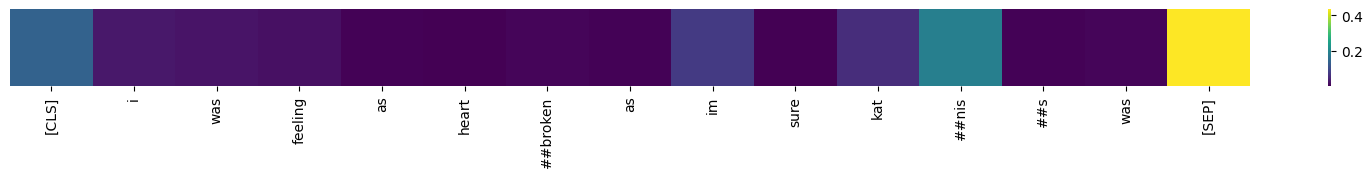

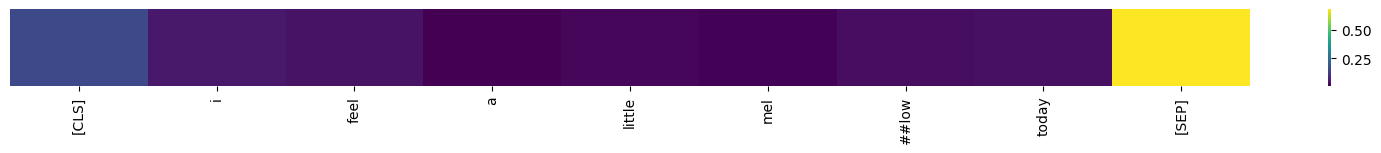

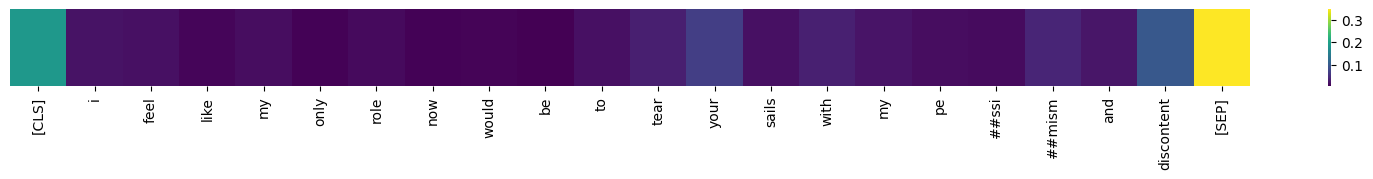

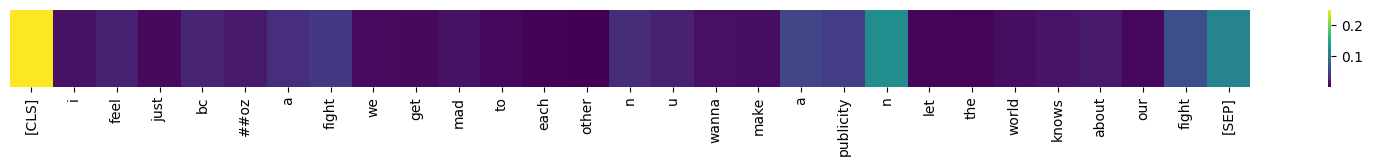

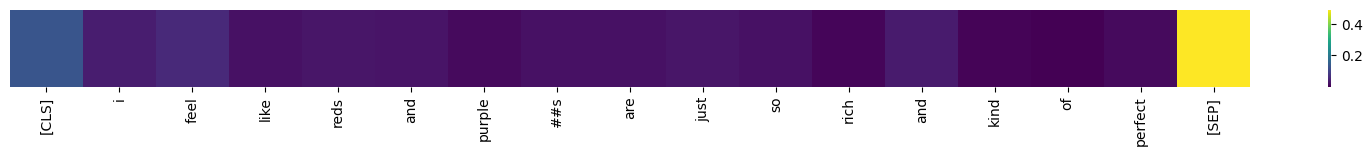

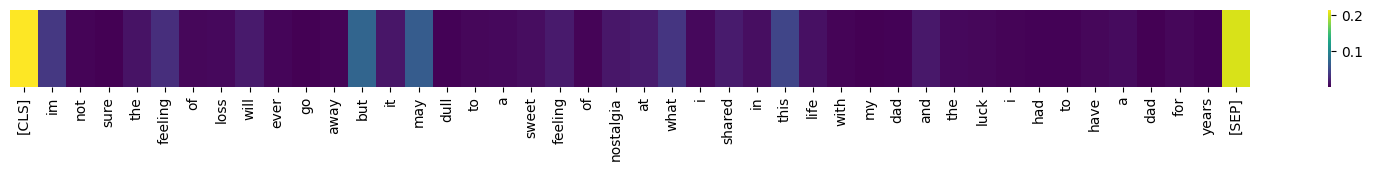

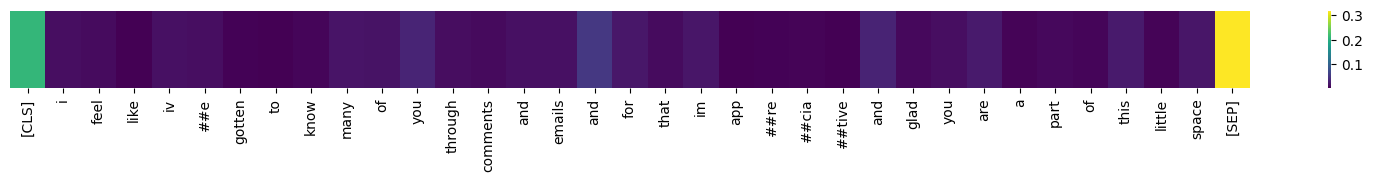

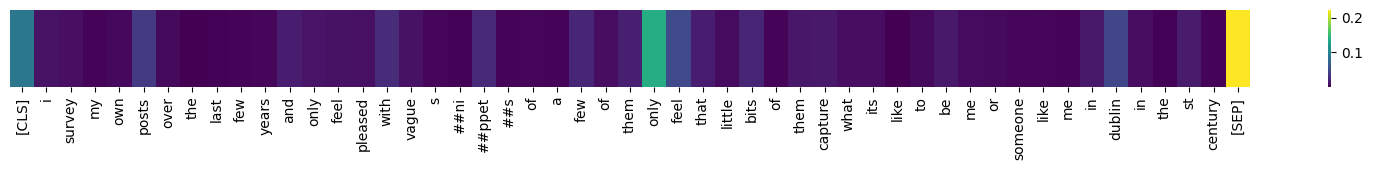

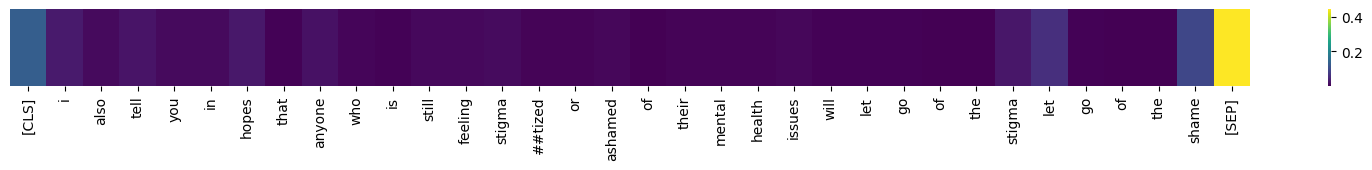

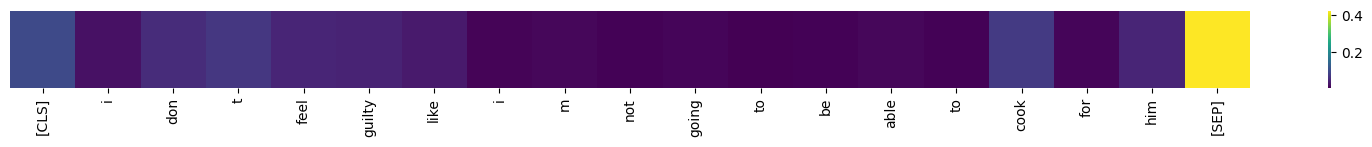

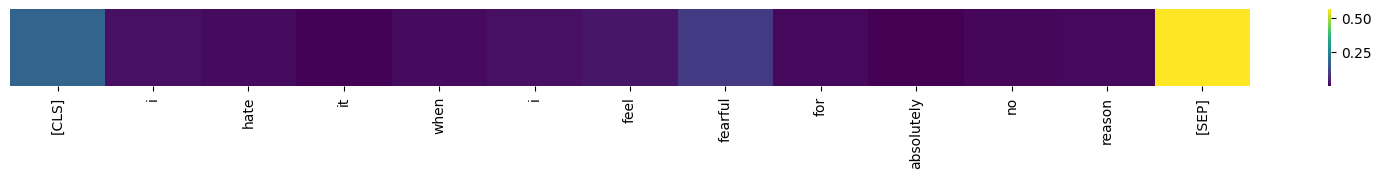

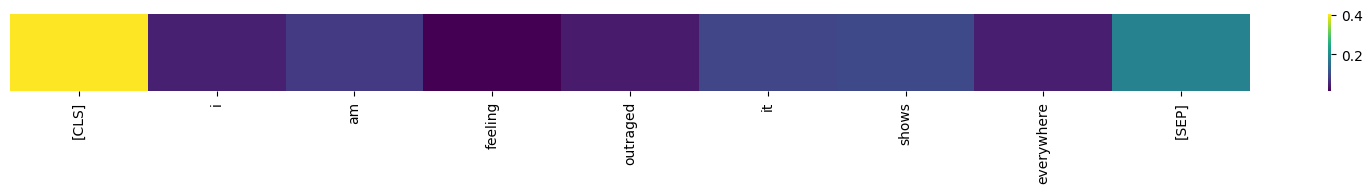

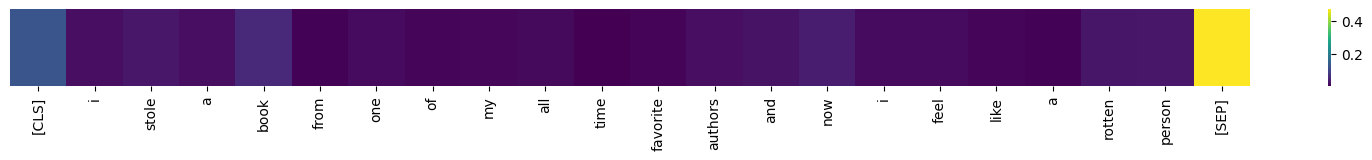

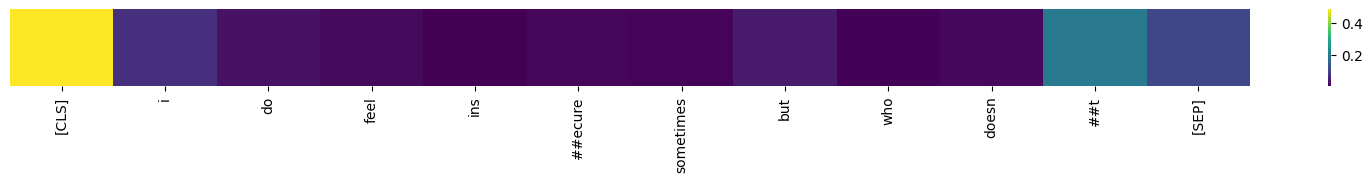

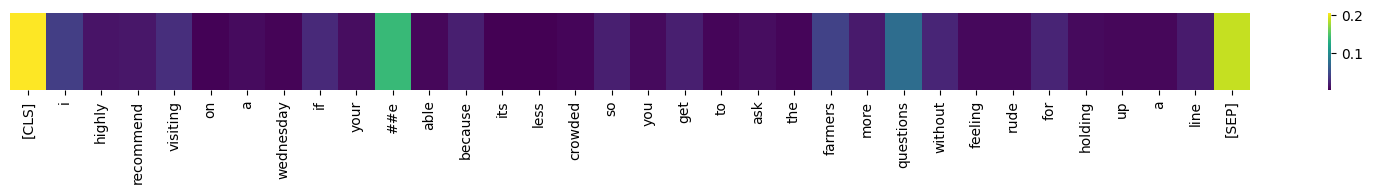

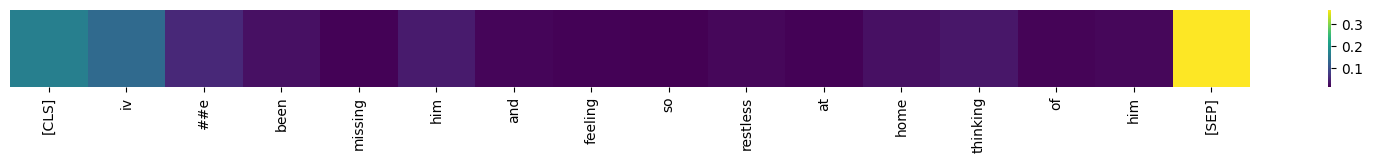

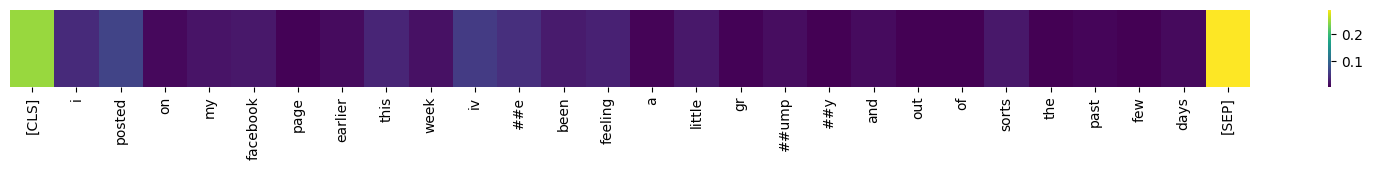

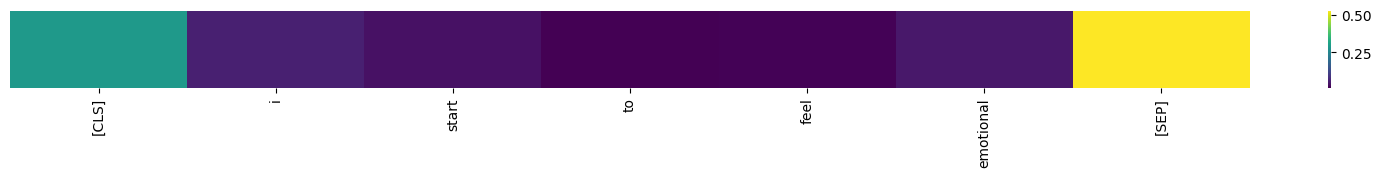

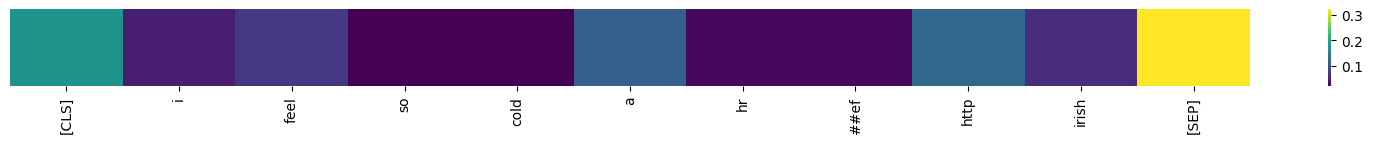

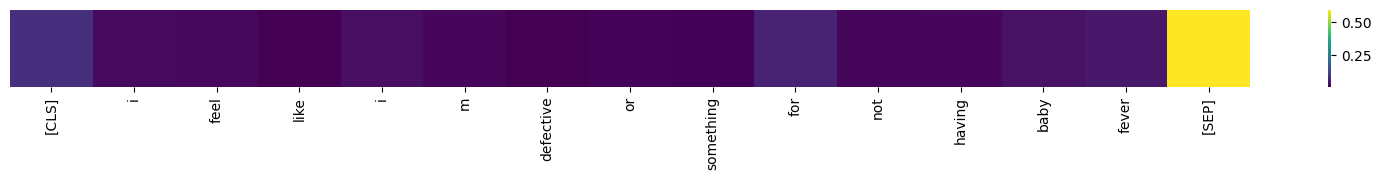

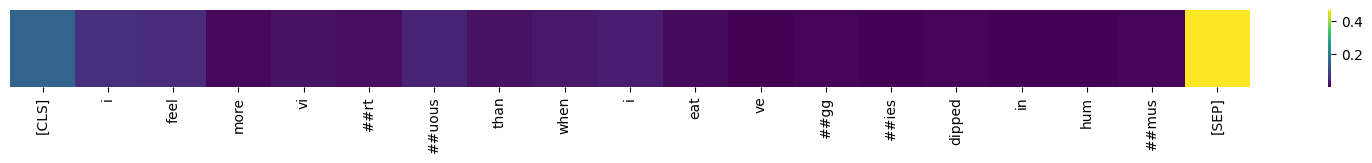

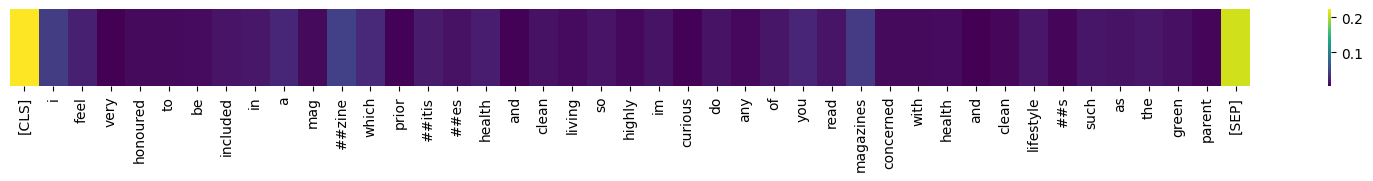

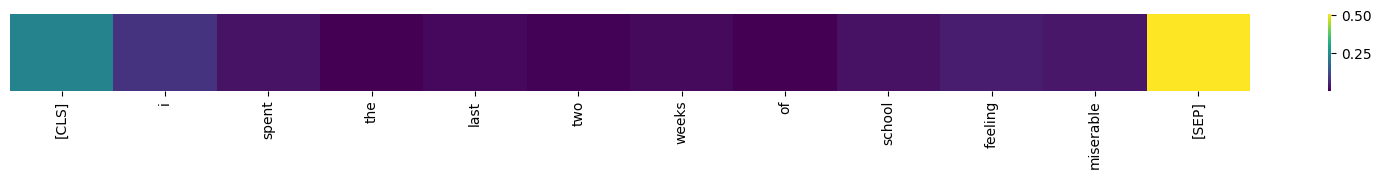

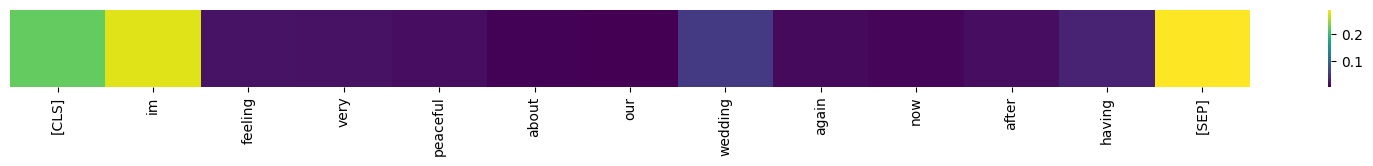

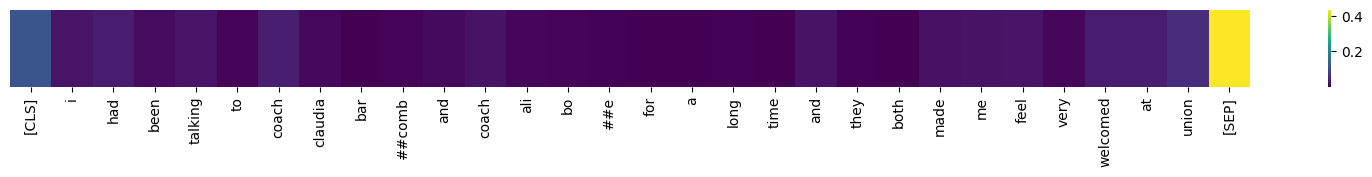

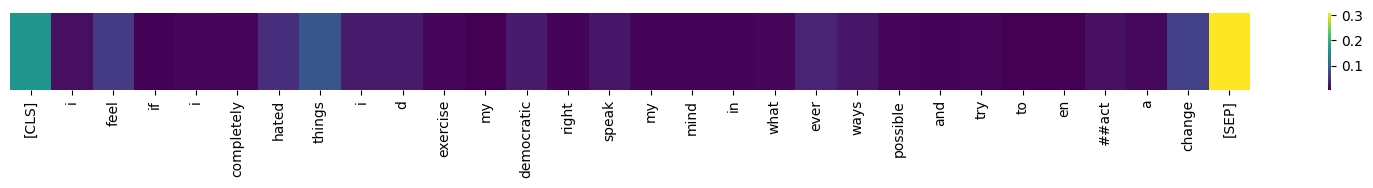

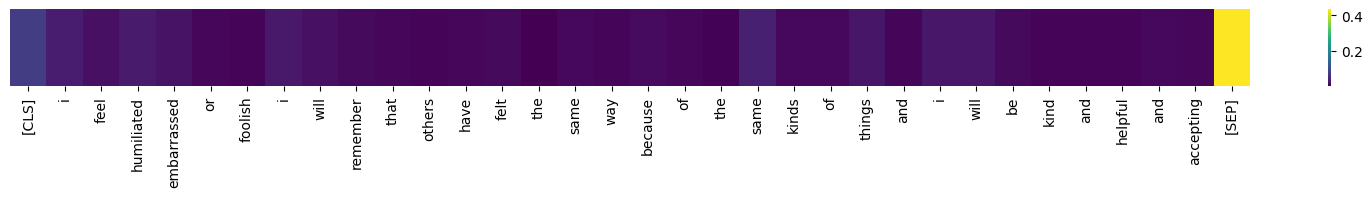

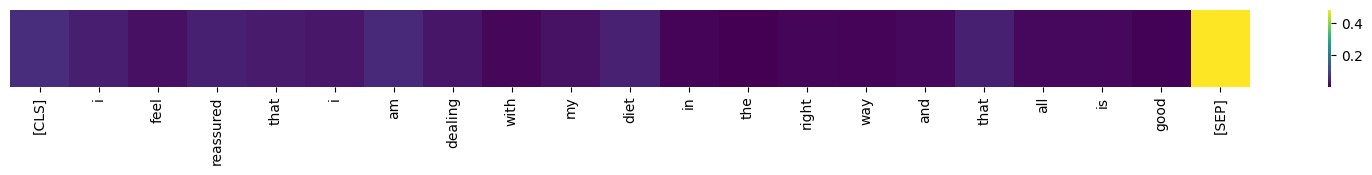

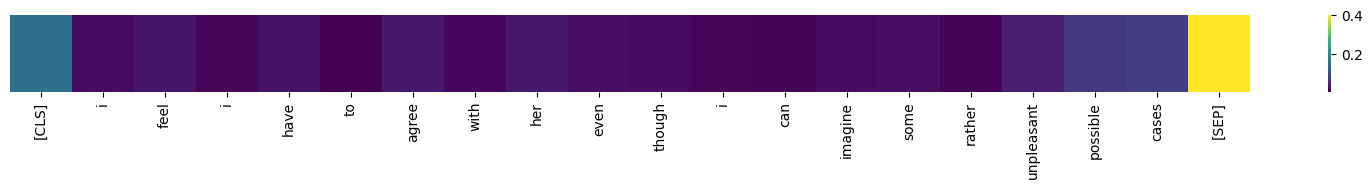

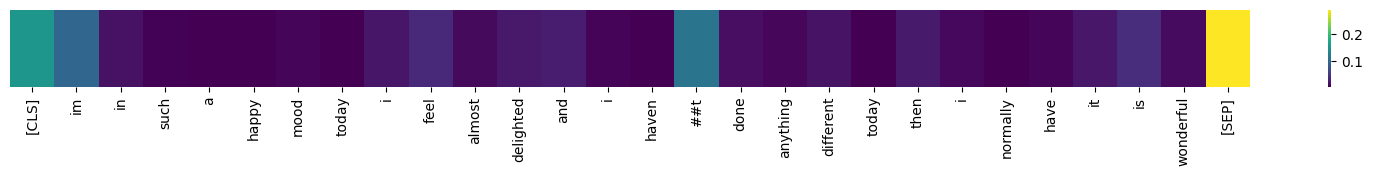

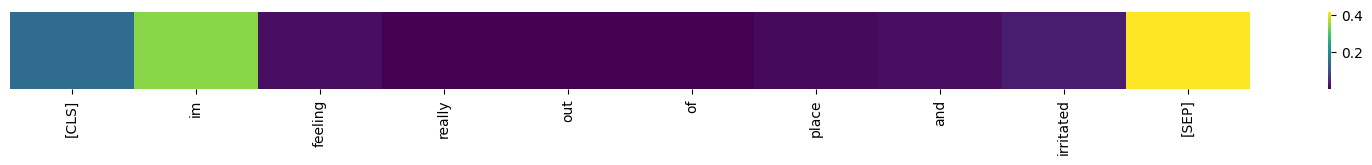

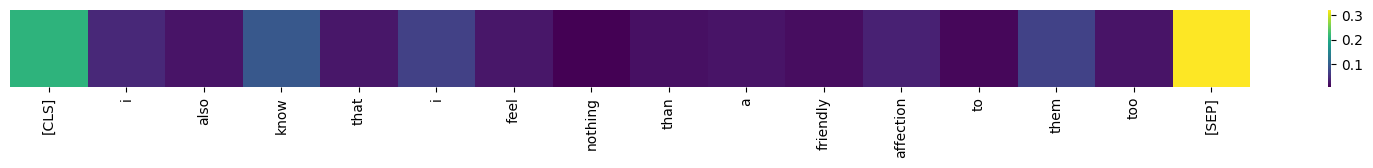

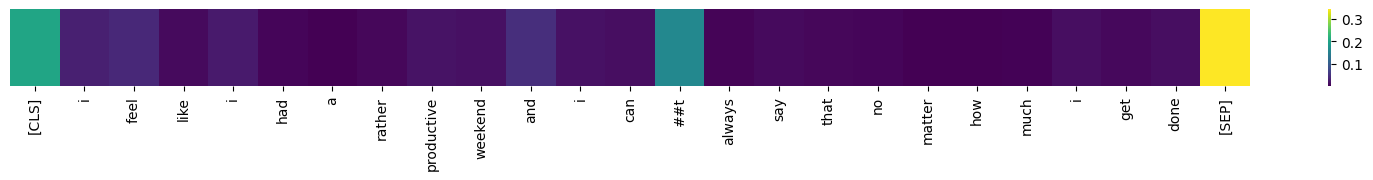

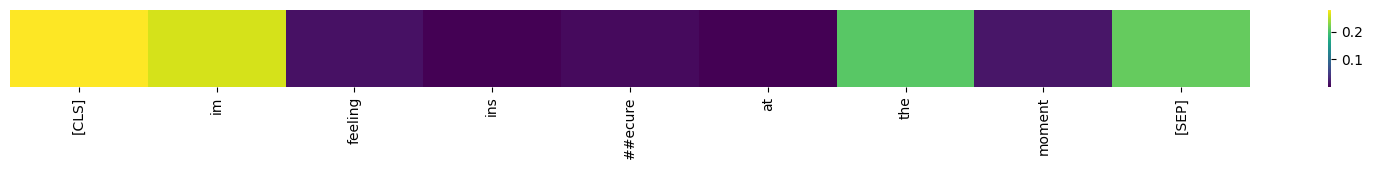

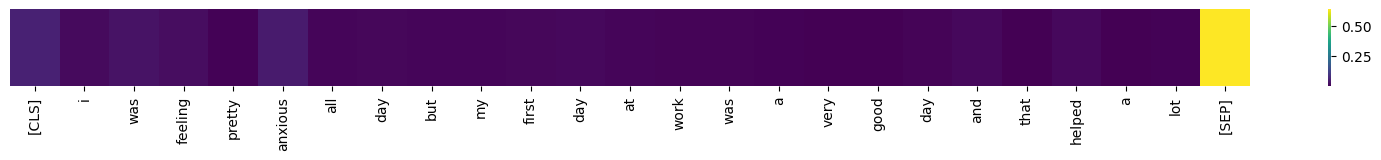

In [ ]:
# Loop over the selected test data
subset_size = 50  # Adjust the range as needed
subset_test_data = test_data.select(range(subset_size))

for example in subset_test_data:
    text = example['text']
    input_ids = tokenizer.encode(text, return_tensors='pt')

    logits, attentions = predict_with_attention(text)
    predicted_label = logits.argmax(dim=1).item()
    actual_label = example['label']

    attention_matrix = analyze_attention(attentions, input_ids, tokenizer, head_num=0, block_num=11)
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    plot_attention_heatmap(attention_matrix, tokens)

    # Additional Analysis
    key_word_attention = attention_to_key_words(attention_matrix, tokens, emotion_words)
    mean_att, std_att = calculate_attention_stats(attention_matrix)

    # Collecting data for post-experiment analysis
    attention_details.append({
        "text": text,
        "predicted_label": predicted_label,
        "actual_label": actual_label,
        "key_word_attention": key_word_attention,
        "mean_attention": mean_att,
        "std_attention": std_att
    })

    # Separate collection for correct and incorrect predictions
    if predicted_label == actual_label:
        correct_predictions_attention.append(mean_att)
    else:
        incorrect_predictions_attention.append(mean_att)

    # Collect attention to emotion words
    for word, attention in key_word_attention.items():
        emotion_word_attention[word].append(attention)


**Post Experiment Analysis**

In [ ]:
# Analyze the collected data

# Average attention to emotion words
average_attention_per_word = {word: np.mean(attentions) for word, attentions in emotion_word_attention.items() if attentions}
print("Average attention to key emotion words:", average_attention_per_word)

# Comparison of attention in correct vs. incorrect predictions
print("Average attention for correct predictions:", np.mean(correct_predictions_attention))
print("Average attention for incorrect predictions:", np.mean(incorrect_predictions_attention))

# Error analysis on incorrect predictions
for detail in attention_details:
    if detail['predicted_label'] != detail['actual_label']:
        print(f"Text: {detail['text']}")
        print(f"Predicted: {detail['predicted_label']}, Actual: {detail['actual_label']}")
        print(f"Attention to key emotion words: {detail['key_word_attention']}\n")


Average attention to key emotion words: {'happy': 0.0045482856, 'irritated': 0.034061566, 'eager': 0.013292254, 'fearful': 0.095123105, 'anxious': 0.04803876, 'pleased': 0.0100510325, 'comfortable': 0.010436698, 'optimistic': 0.062262315, 'rotten': 0.020123754, 'ambitious': 0.04176094, 'uncomfortable': 0.028462393, 'anger': 0.065301925, 'immature': 0.0075568226, 'excitement': 0.01002489, 'agitated': 0.016341902, 'invaded': 0.023626605, 'helpless': 0.028566066, 'supportive': 0.07823011, 'outraged': 0.040295366, 'restless': 0.020686992, 'productive': 0.01744455, 'peaceful': 0.018845623, 'welcomed': 0.035483185, 'delighted': 0.022749214, 'tired': 0.019070508, 'mad': 0.013488308, 'rude': 0.0066012503, 'honoured': 0.007450887, 'reassured': 0.044845805, 'friendly': 0.015603883}
Average attention for correct predictions: 0.06314617
Average attention for incorrect predictions: 0.056738883
Text: im feeling rather rotten so im not very ambitious right now
Predicted: 3, Actual: 0
Attention to key

**Additional Experiment: Distribution of Attention Across Different Sentence Structures**

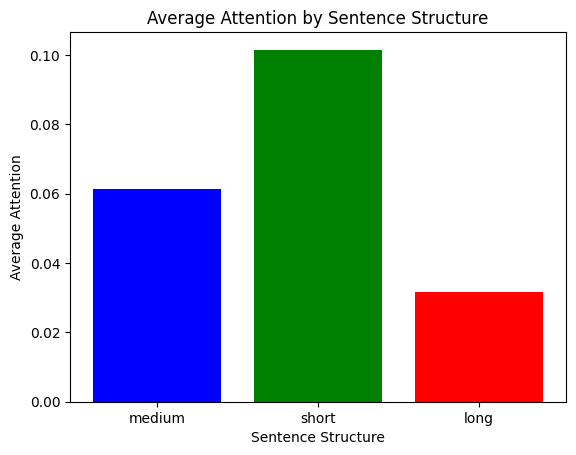

In [ ]:
from collections import defaultdict

def categorize_sentence_structure(text):
    # Example categorization based on sentence length
    length = len(text.split())
    if length <= 10:
        return 'short'
    elif length <= 20:
        return 'medium'
    else:
        return 'long'

def analyze_sentence_structure_attention(subset_test_data):
    structure_attention_stats = []

    for example in subset_test_data:
        text = example['text']
        input_ids = tokenizer.encode(text, return_tensors='pt')
        _, attentions = predict_with_attention(text)
        attention_matrix = analyze_attention(attentions, input_ids, tokenizer, head_num=0, block_num=11)
        sentence_length = len(input_ids[0])
        mean_attention = np.mean(attention_matrix)

        # Add your logic to categorize sentence structures (e.g., simple, complex)
        sentence_structure = categorize_sentence_structure(text)  # Implement this function based on your criteria
        structure_attention_stats.append((sentence_structure, sentence_length, mean_attention))

    return structure_attention_stats

# Analyze and plot after experiment loop
structure_attention_stats = analyze_sentence_structure_attention(subset_test_data)
# Implement plotting or statistical analysis based on structure_attention_stats

# Initialize dictionaries to store aggregated data
attention_aggregate = defaultdict(list)

# Aggregate data
for structure, _, mean_attention in structure_attention_stats:
    attention_aggregate[structure].append(mean_attention)

# Calculate average attention for each sentence structure
average_attention_by_structure = {structure: np.mean(attentions) for structure, attentions in attention_aggregate.items()}

# Extracting data for plotting
structures = list(average_attention_by_structure.keys())
average_attentions = list(average_attention_by_structure.values())

# Plotting
plt.bar(structures, average_attentions, color=['blue', 'green', 'red'])
plt.xlabel('Sentence Structure')
plt.ylabel('Average Attention')
plt.title('Average Attention by Sentence Structure')
plt.show()


**Additional Experiment2: Attention Entropy Analysis**

In [ ]:
from scipy.stats import entropy

def calculate_attention_entropy(attention_weights):
    return entropy(attention_weights)

# Collect entropy data in the experiment loop
attention_entropies = []
for detail in attention_details:
    attention_entropy = calculate_attention_entropy(detail['mean_attention'])
    attention_entropies.append(attention_entropy)

# Analyze the collected entropies
print("Average attention entropy:", np.mean(attention_entropies))


Average attention entropy: 0.0


# **Different Head and Block Position Experiments**

**Different Head And Block (Block 1; head 0)**

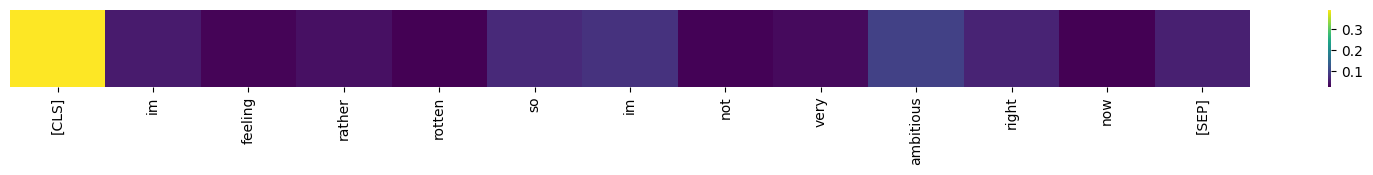

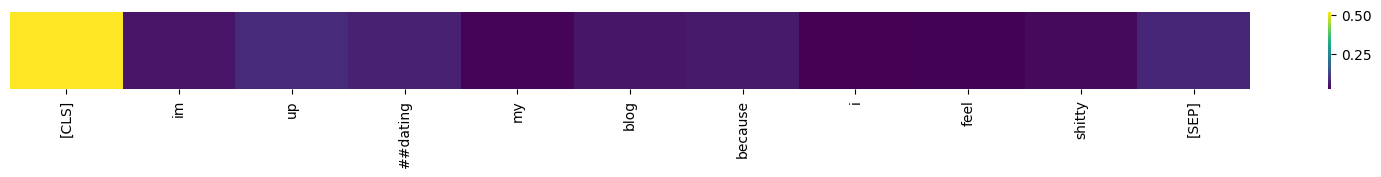

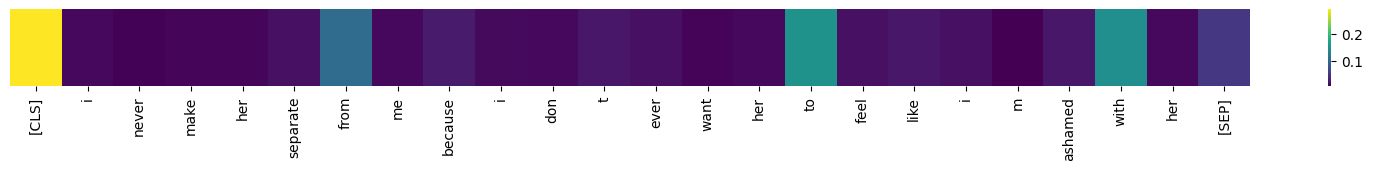

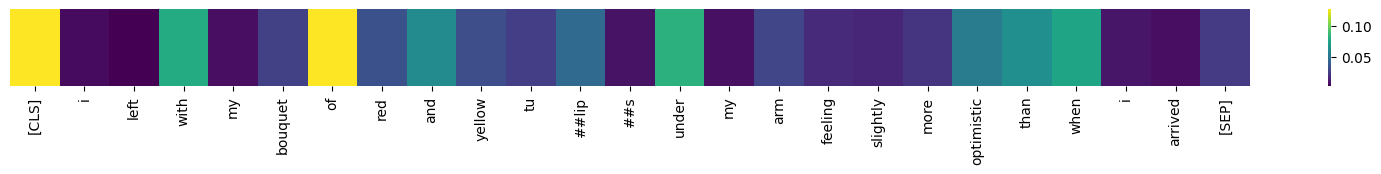

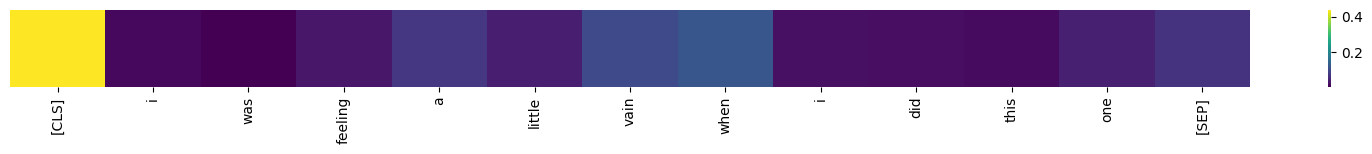

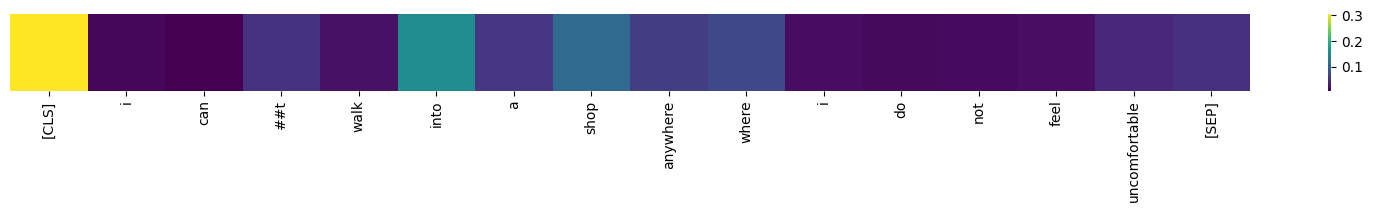

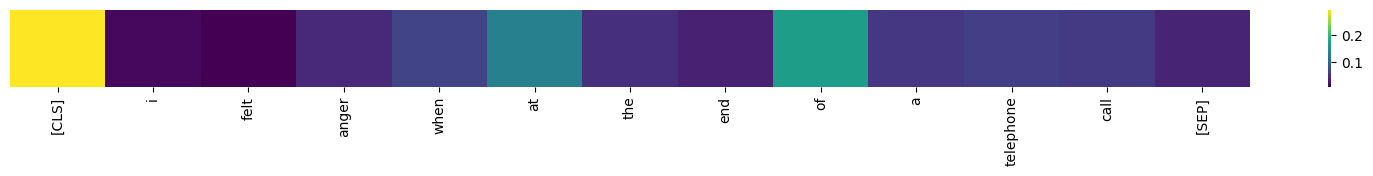

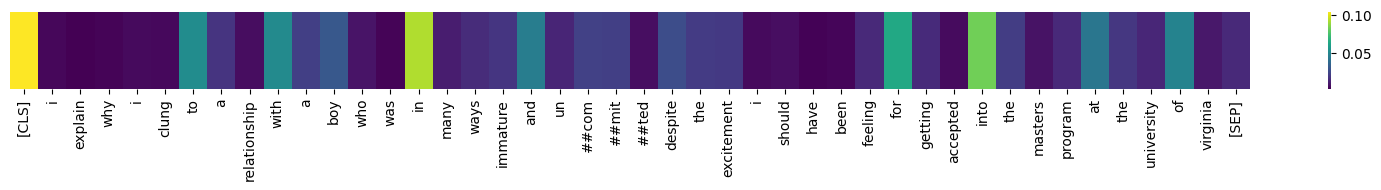

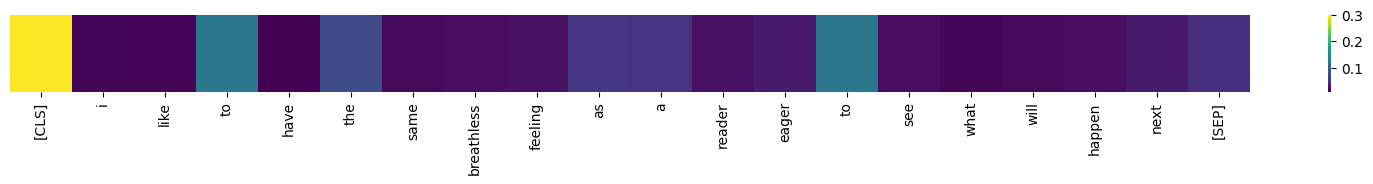

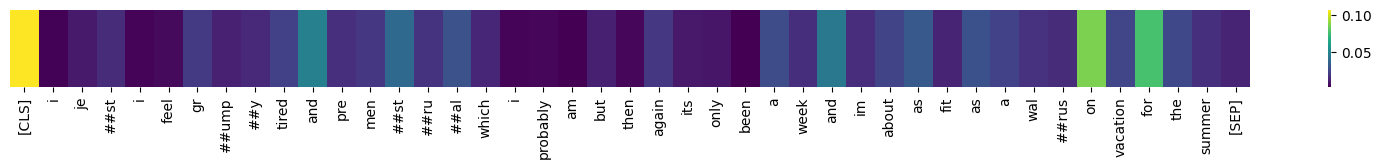

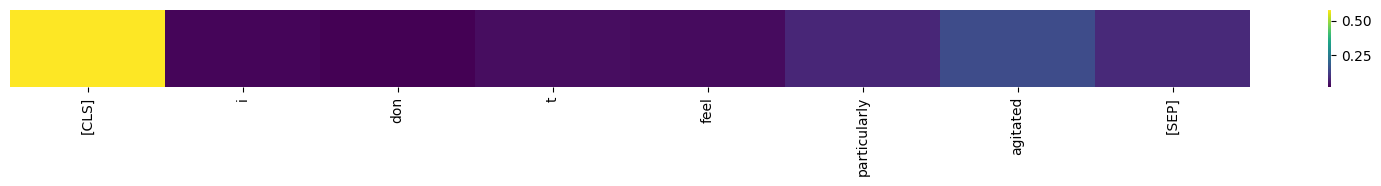

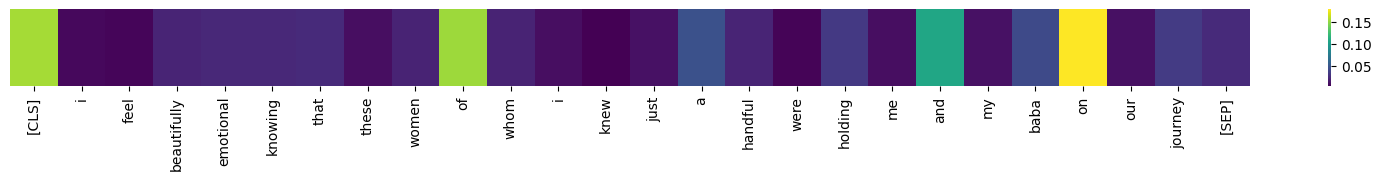

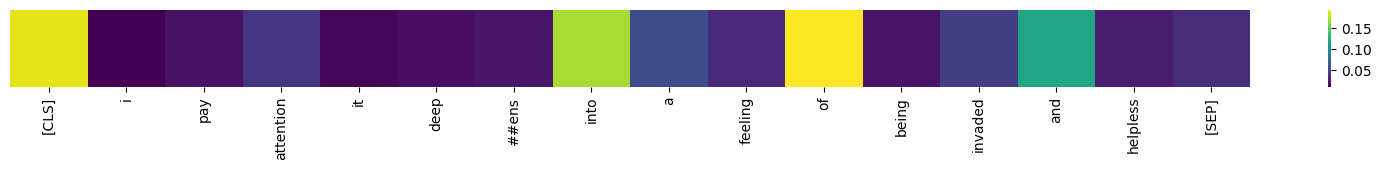

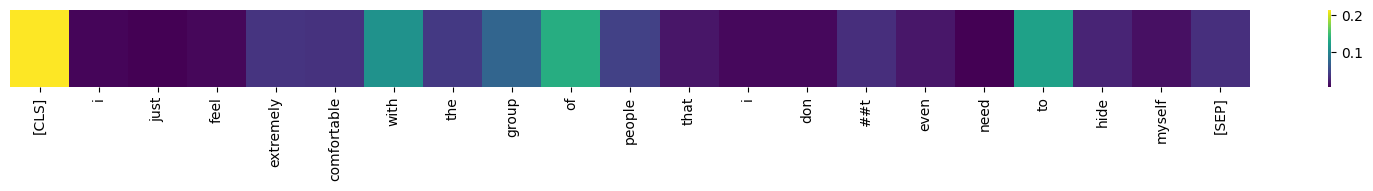

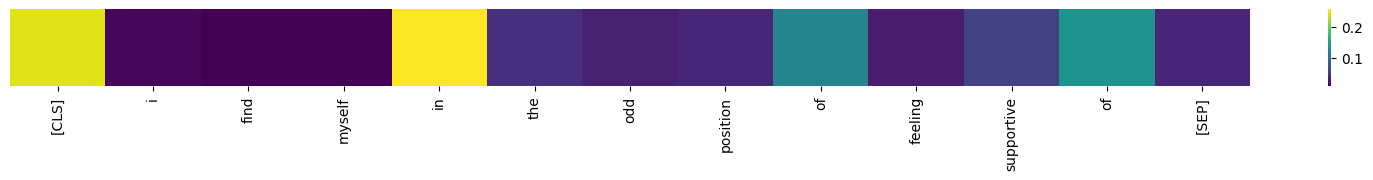

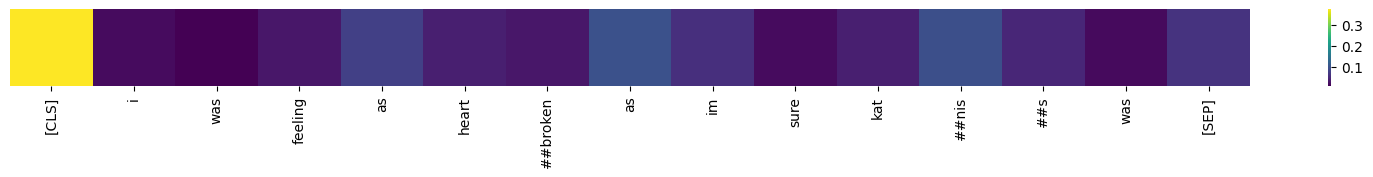

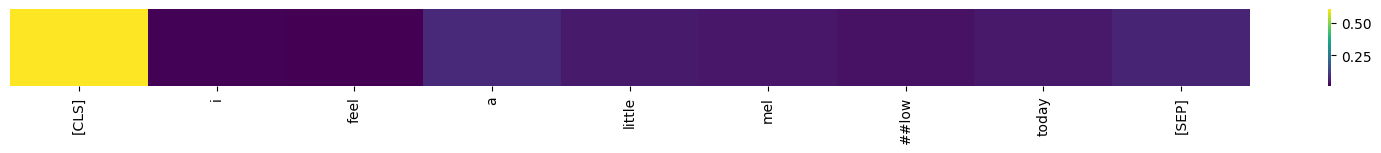

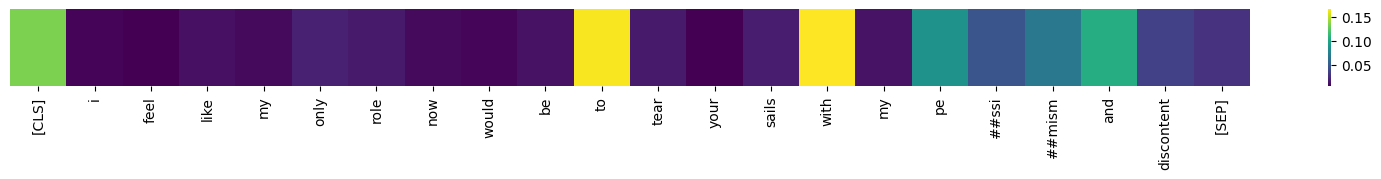

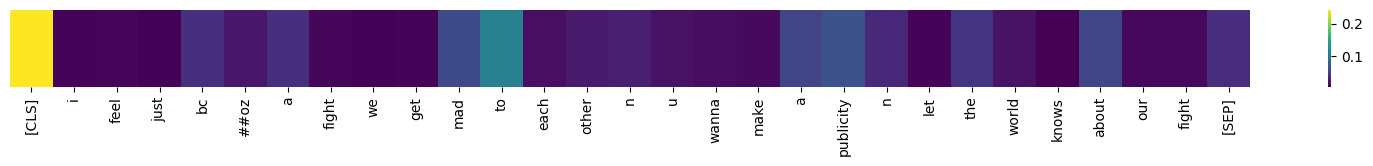

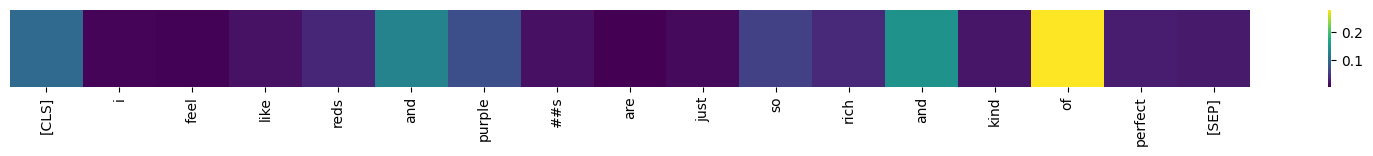

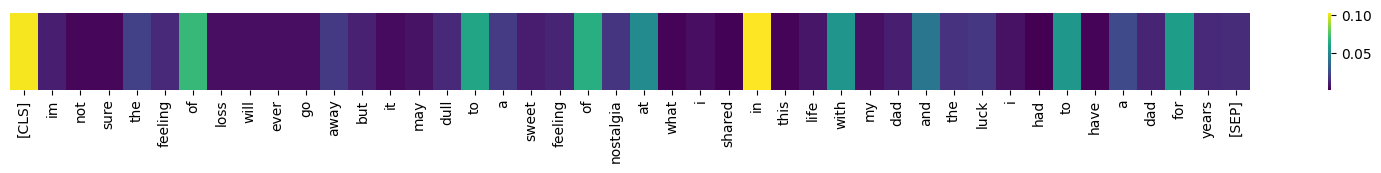

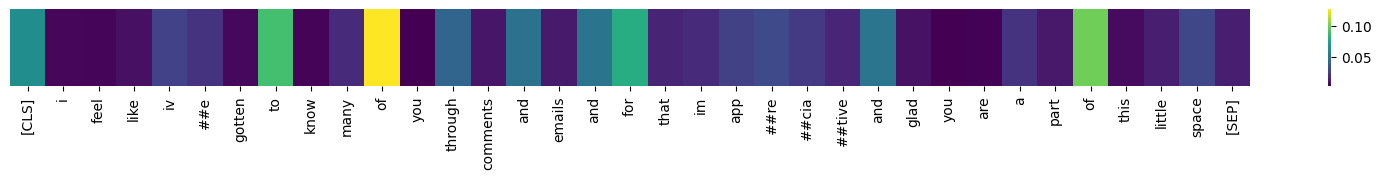

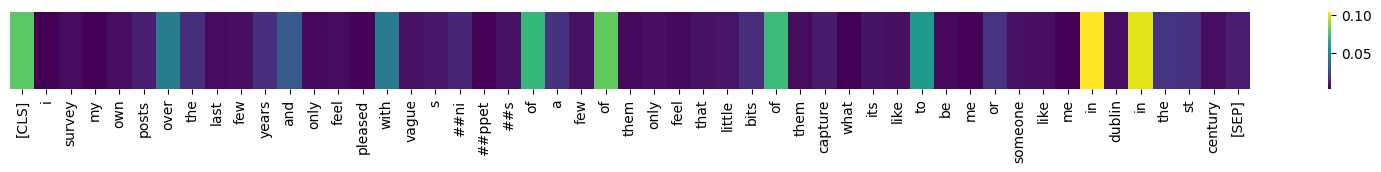

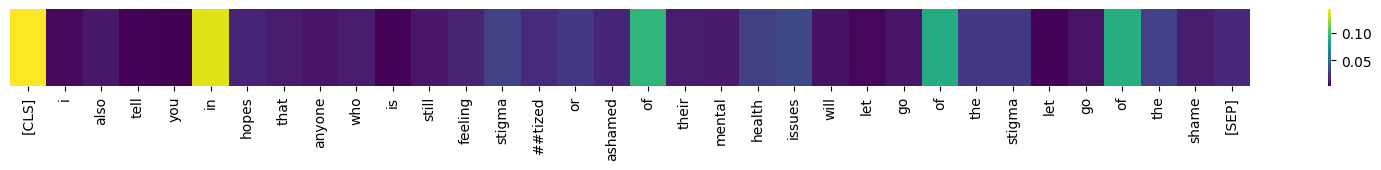

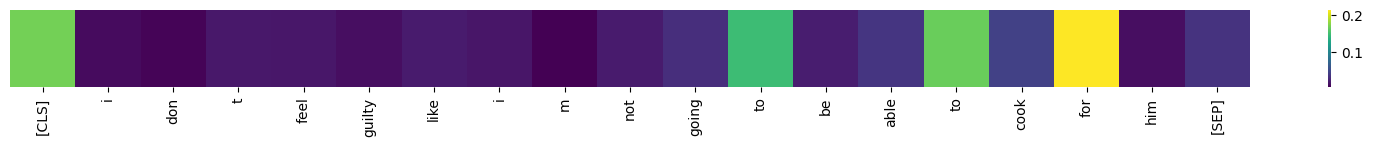

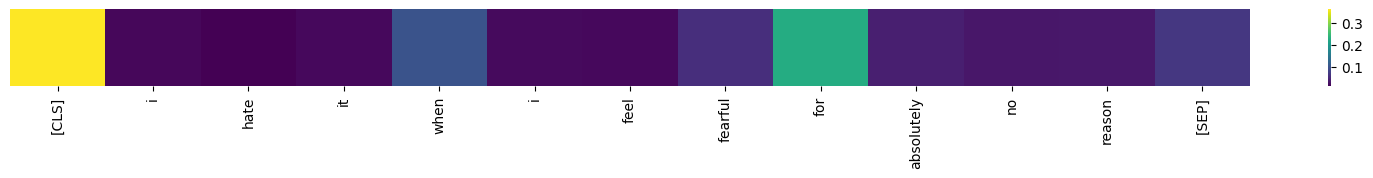

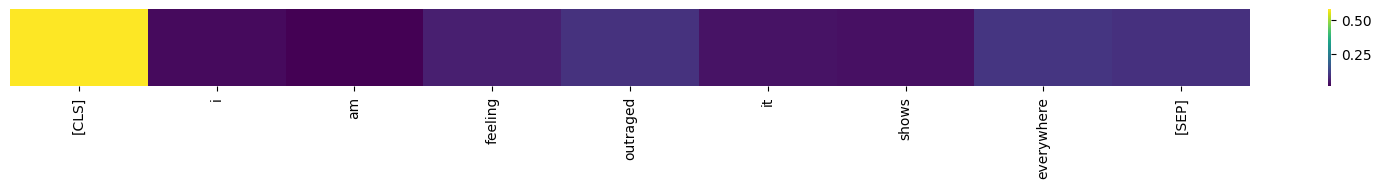

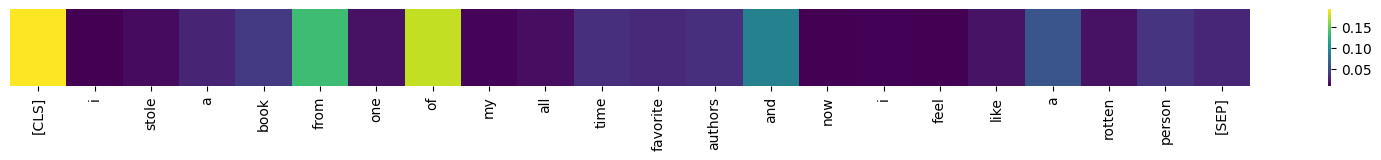

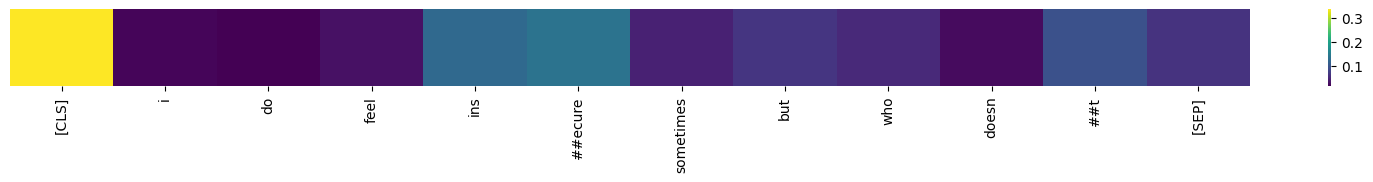

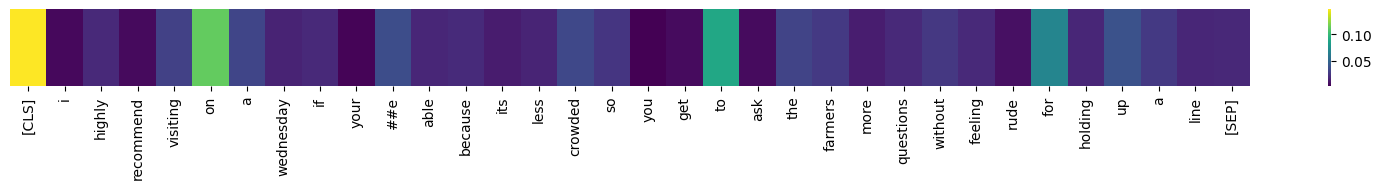

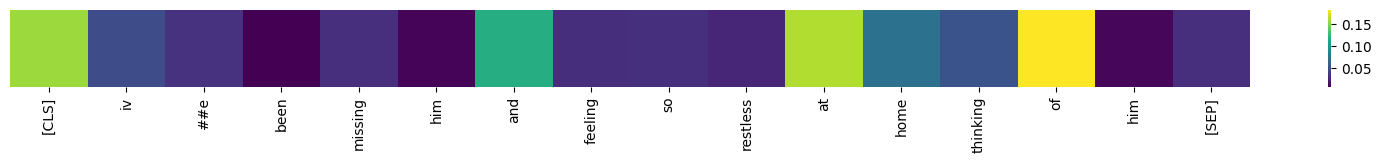

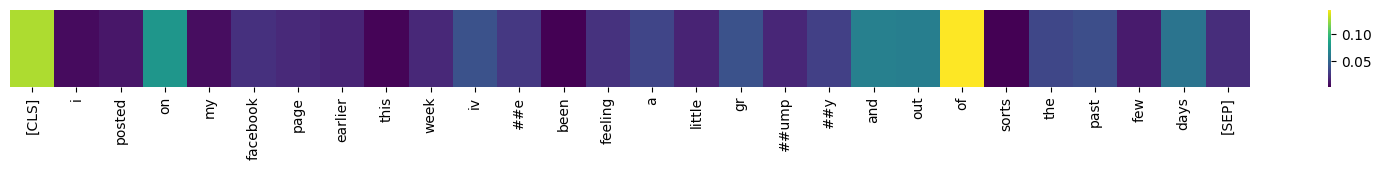

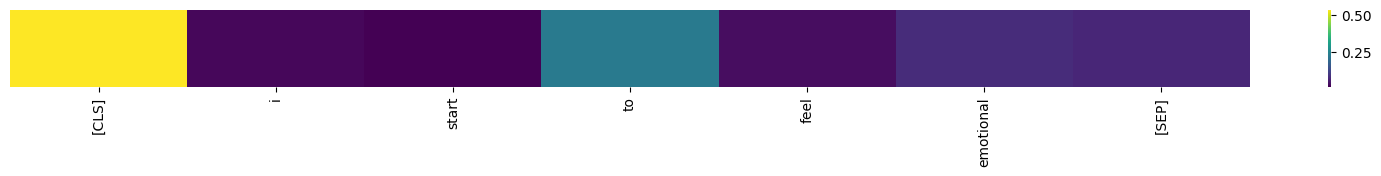

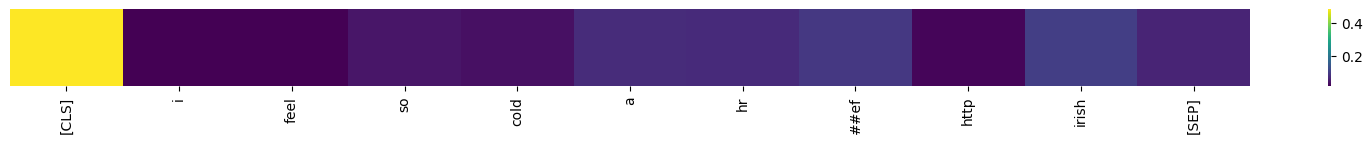

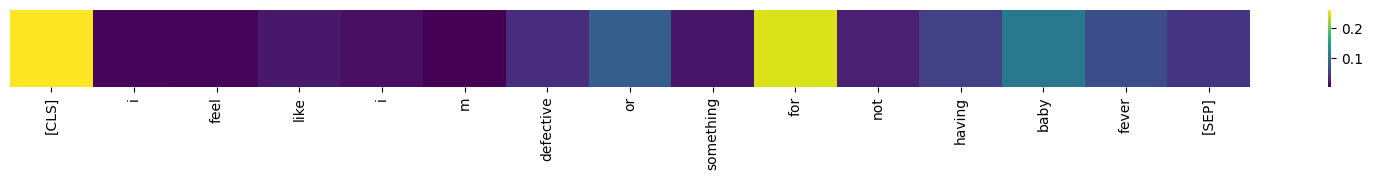

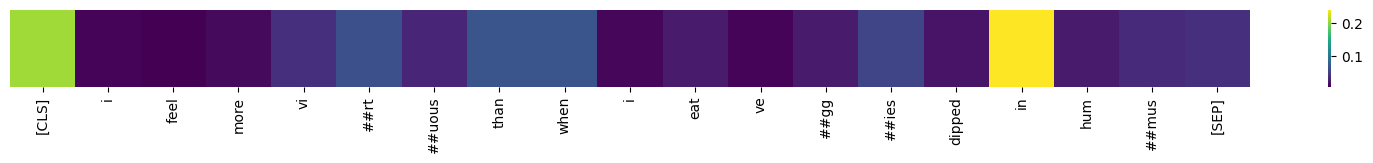

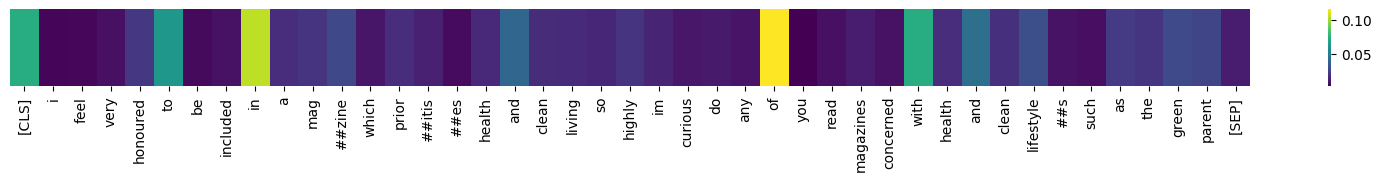

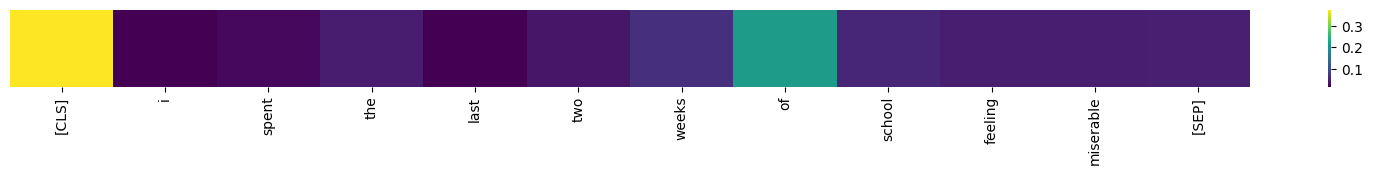

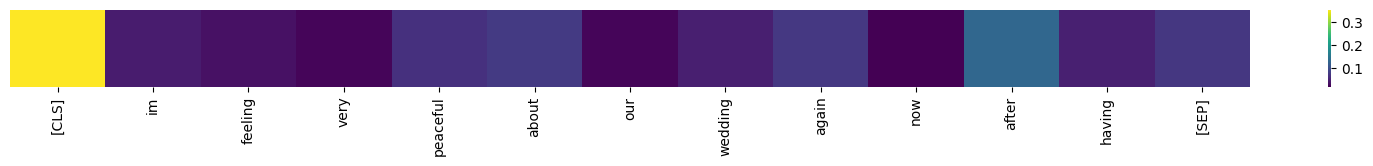

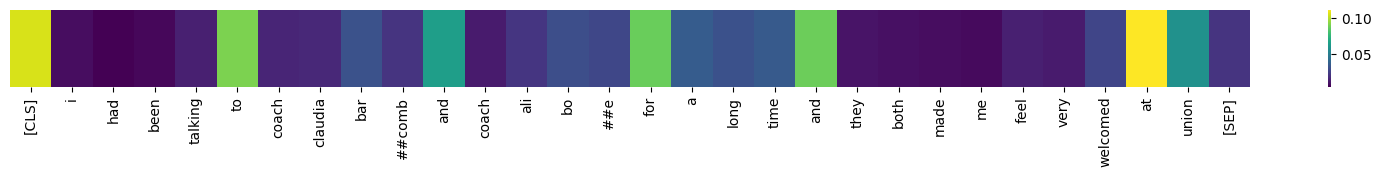

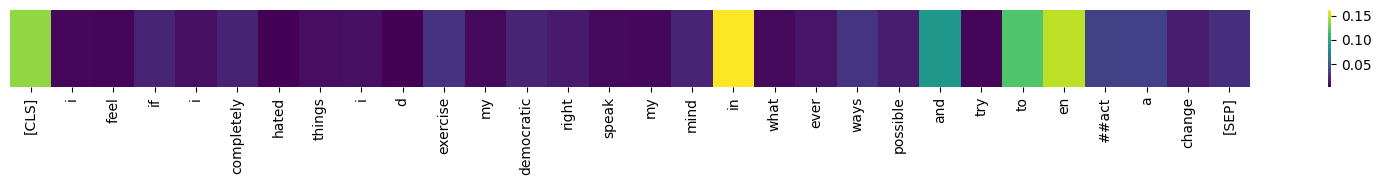

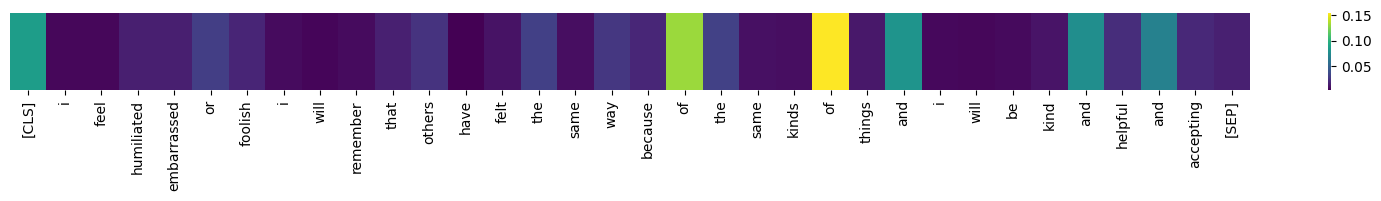

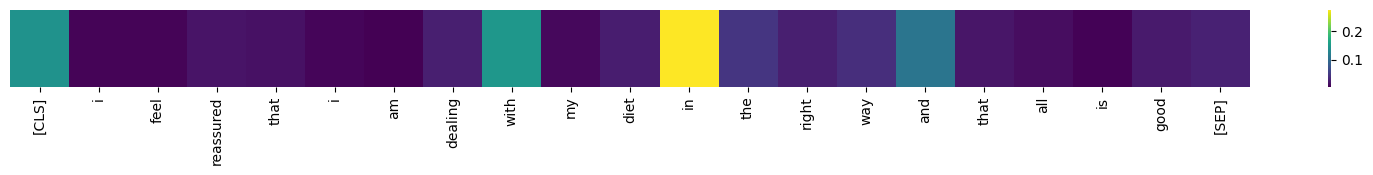

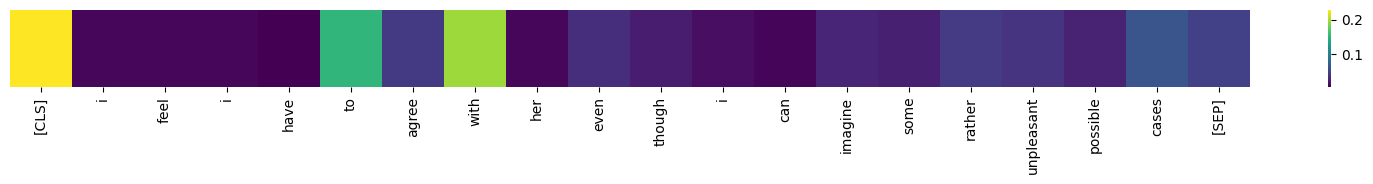

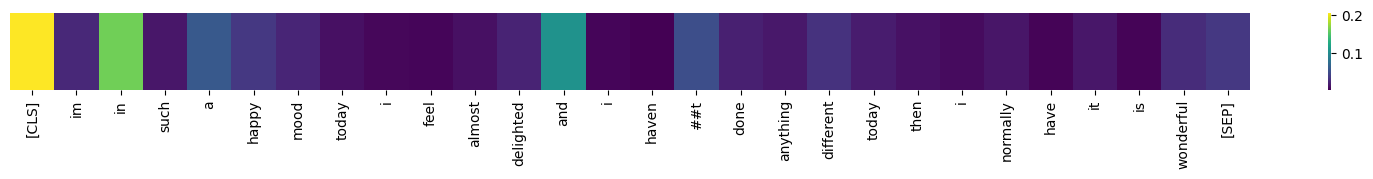

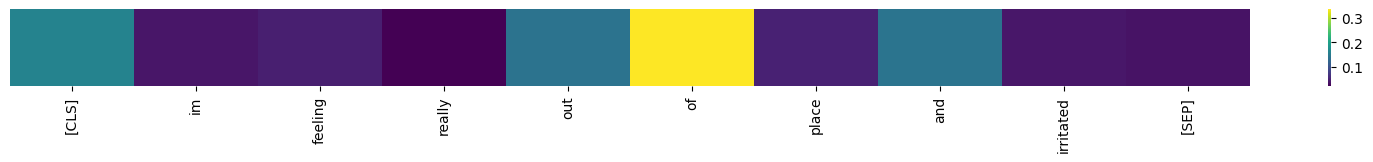

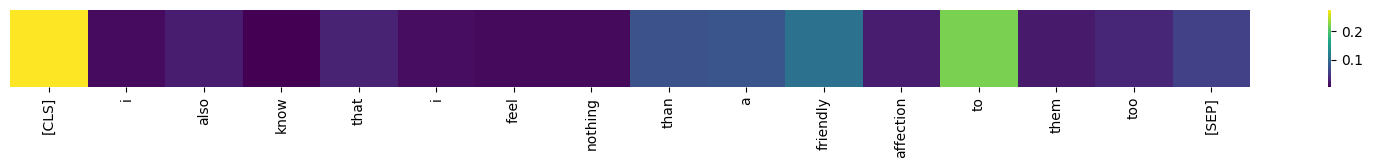

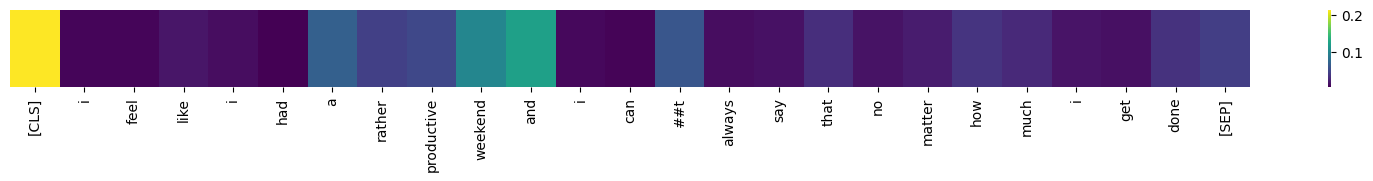

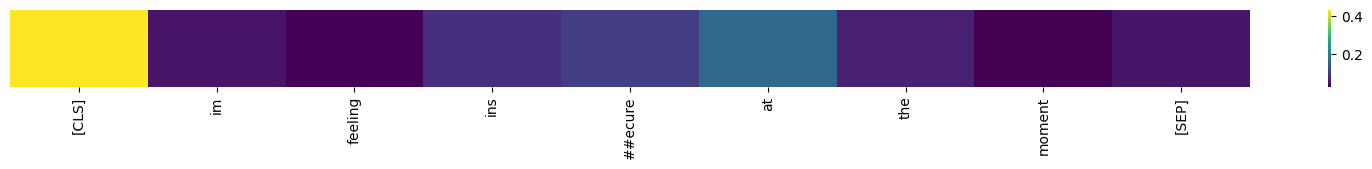

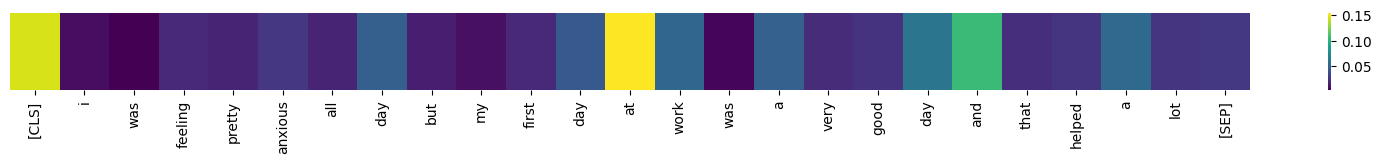

Average attention to key emotion words: {'happy': 0.020947909, 'irritated': 0.036115237, 'eager': 0.021292398, 'fearful': 0.07572613, 'anxious': 0.03731289, 'pleased': 0.0068138936, 'comfortable': 0.022762774, 'optimistic': 0.058198527, 'rotten': 0.020729484, 'ambitious': 0.06952655, 'uncomfortable': 0.034453683, 'anger': 0.052089915, 'immature': 0.012842649, 'excitement': 0.014613952, 'agitated': 0.08096665, 'invaded': 0.033456866, 'helpless': 0.026748434, 'supportive': 0.06650689, 'outraged': 0.06479738, 'restless': 0.023613878, 'productive': 0.03379977, 'peaceful': 0.04141615, 'welcomed': 0.030529242, 'delighted': 0.023190256, 'tired': 0.02119311, 'mad': 0.036122527, 'rude': 0.0077396, 'honoured': 0.01394392, 'reassured': 0.031514093, 'friendly': 0.06129001}
Average attention for correct predictions: 0.06314616
Average attention for incorrect predictions: 0.05673889
Text: im feeling rather rotten so im not very ambitious right now
Predicted: 3, Actual: 0
Attention to key emotion wor

In [ ]:
# Loop over the selected test data
subset_size = 50  # Adjust the range as needed
subset_test_data = test_data.select(range(subset_size))

for example in subset_test_data:
    text = example['text']
    input_ids = tokenizer.encode(text, return_tensors='pt')

    logits, attentions = predict_with_attention(text)
    predicted_label = logits.argmax(dim=1).item()
    actual_label = example['label']

    attention_matrix = analyze_attention(attentions, input_ids, tokenizer, head_num=0, block_num=1)
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    plot_attention_heatmap(attention_matrix, tokens)

    # Additional Analysis
    key_word_attention = attention_to_key_words(attention_matrix, tokens, emotion_words)
    mean_att, std_att = calculate_attention_stats(attention_matrix)

    # Collecting data for post-experiment analysis
    attention_details.append({
        "text": text,
        "predicted_label": predicted_label,
        "actual_label": actual_label,
        "key_word_attention": key_word_attention,
        "mean_attention": mean_att,
        "std_attention": std_att
    })

    # Separate collection for correct and incorrect predictions
    if predicted_label == actual_label:
        correct_predictions_attention.append(mean_att)
    else:
        incorrect_predictions_attention.append(mean_att)

    # Collect attention to emotion words
    for word, attention in key_word_attention.items():
        emotion_word_attention[word].append(attention)


# Analyze the collected data

# Average attention to emotion words
average_attention_per_word = {word: np.mean(attentions) for word, attentions in emotion_word_attention.items() if attentions}
print("Average attention to key emotion words:", average_attention_per_word)

# Comparison of attention in correct vs. incorrect predictions
print("Average attention for correct predictions:", np.mean(correct_predictions_attention))
print("Average attention for incorrect predictions:", np.mean(incorrect_predictions_attention))

# Error analysis on incorrect predictions
for detail in attention_details:
    if detail['predicted_label'] != detail['actual_label']:
        print(f"Text: {detail['text']}")
        print(f"Predicted: {detail['predicted_label']}, Actual: {detail['actual_label']}")
        print(f"Attention to key emotion words: {detail['key_word_attention']}\n")



**Different Location: Head 3; Block 2**

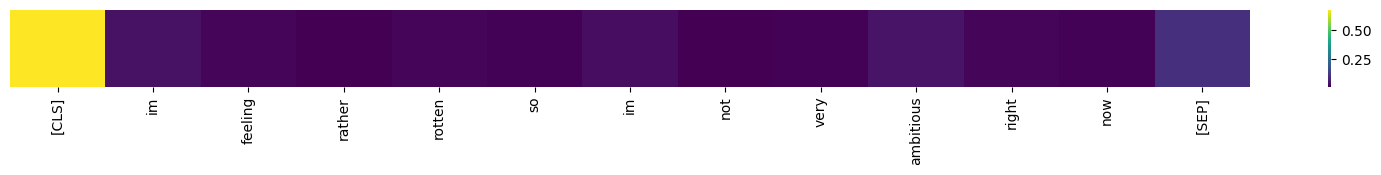

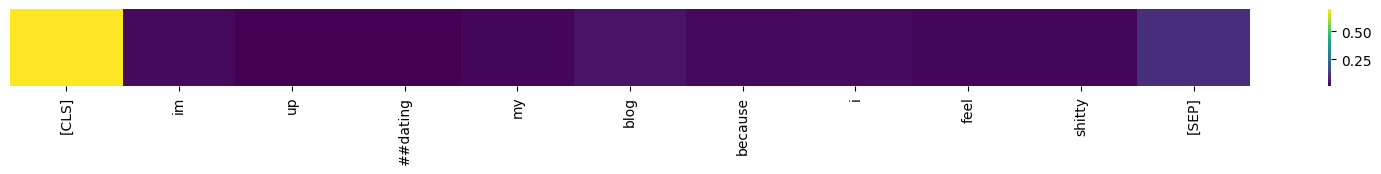

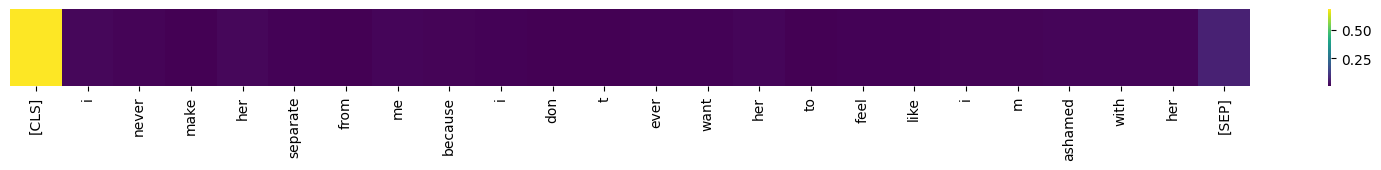

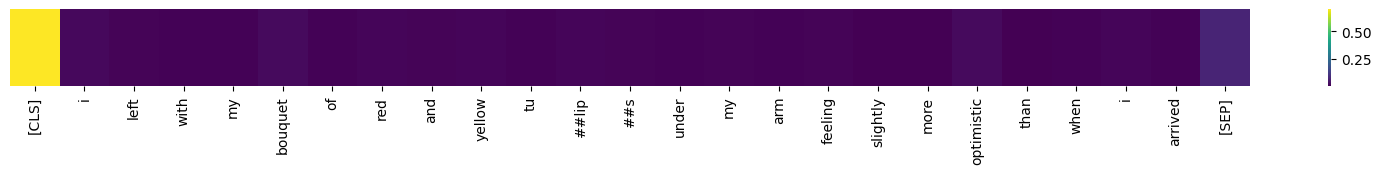

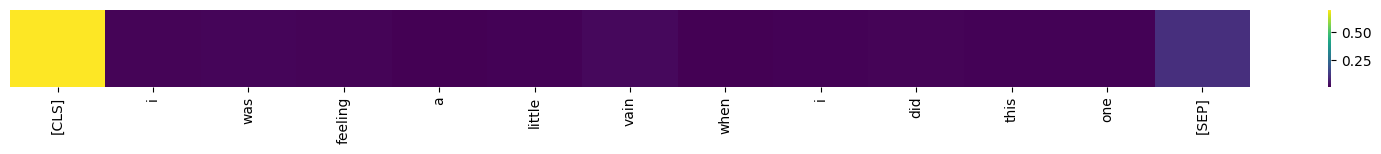

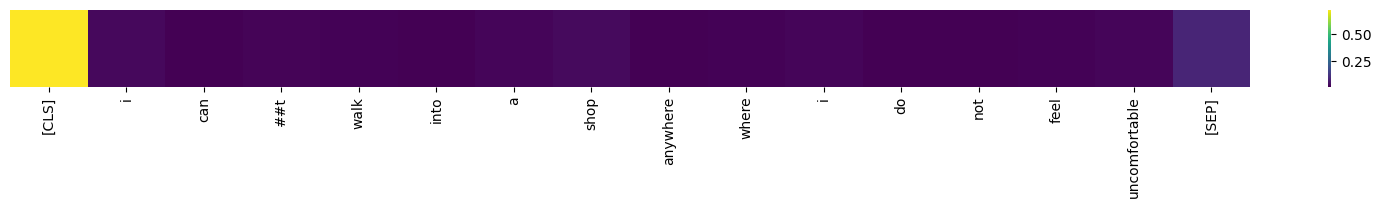

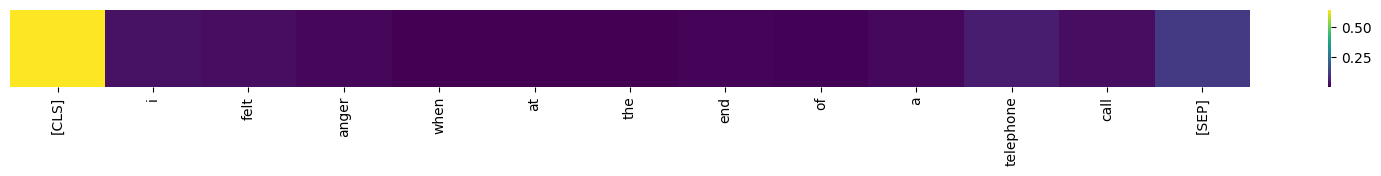

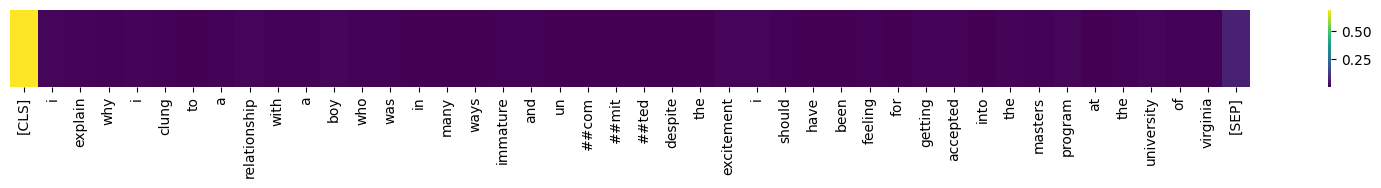

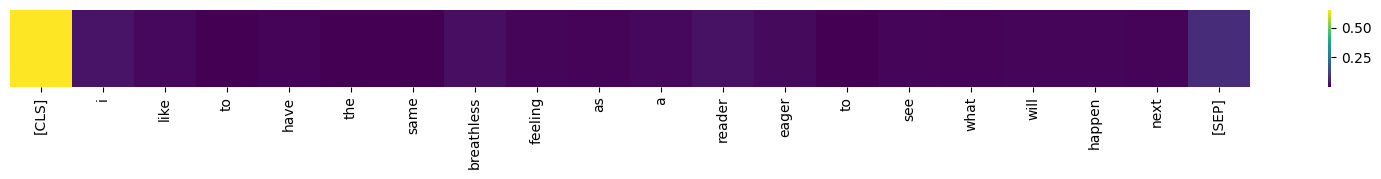

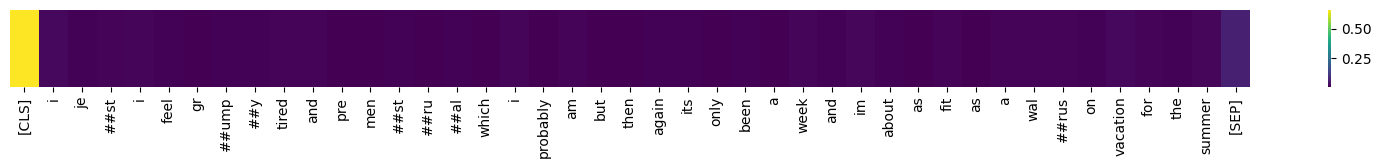

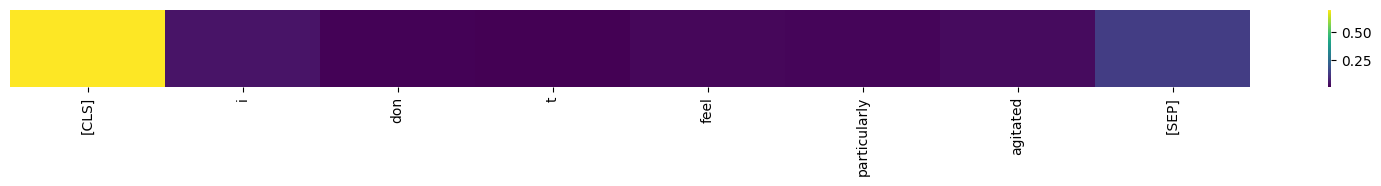

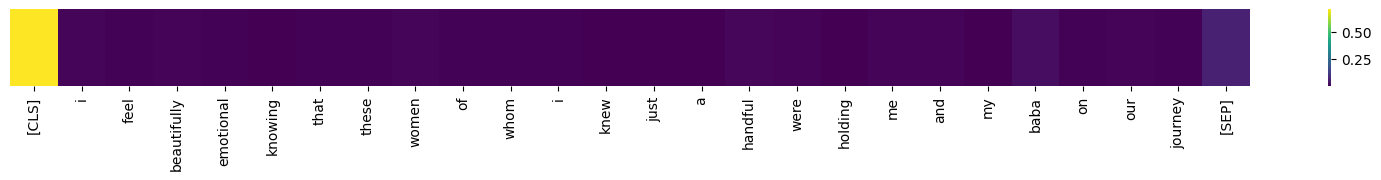

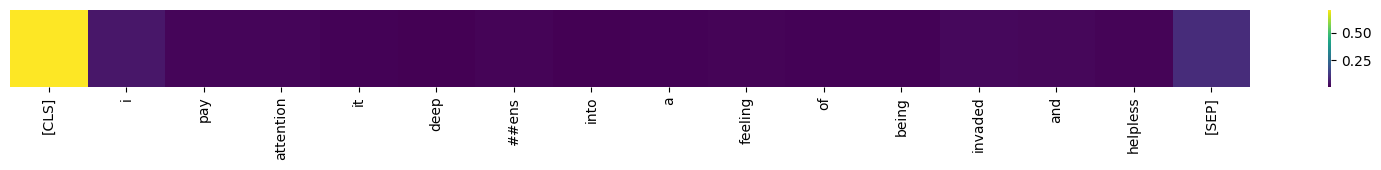

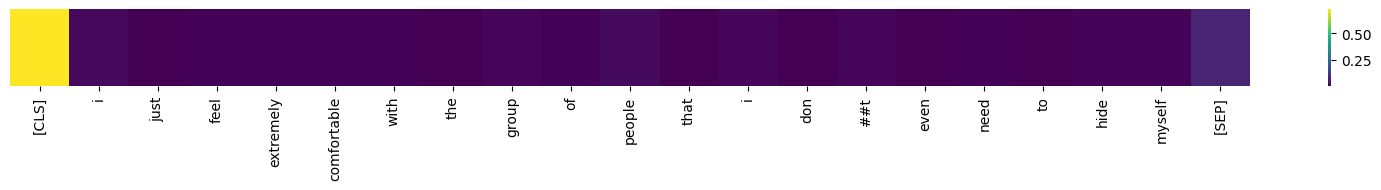

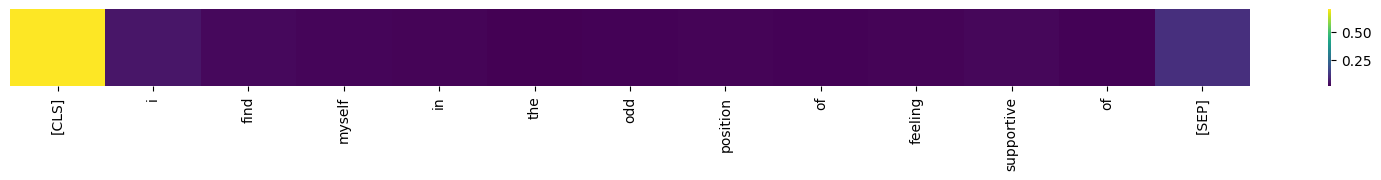

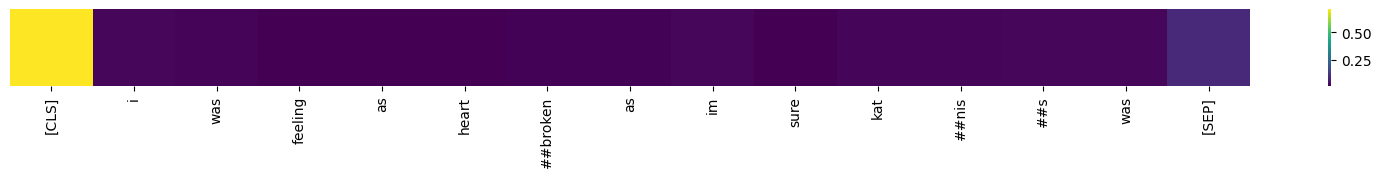

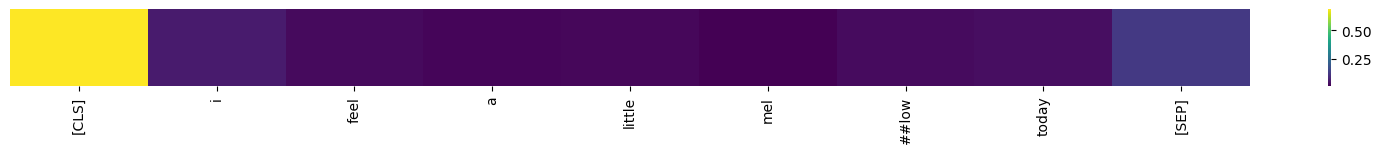

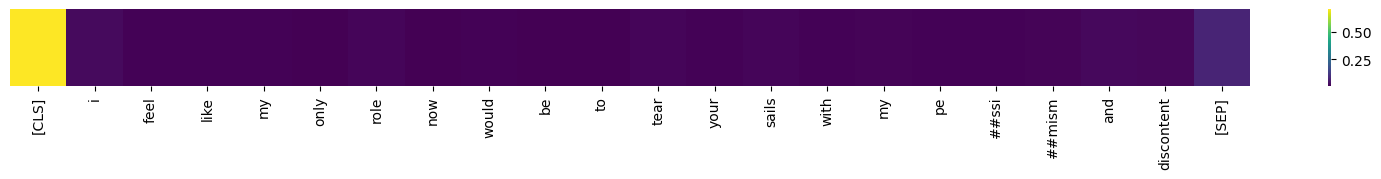

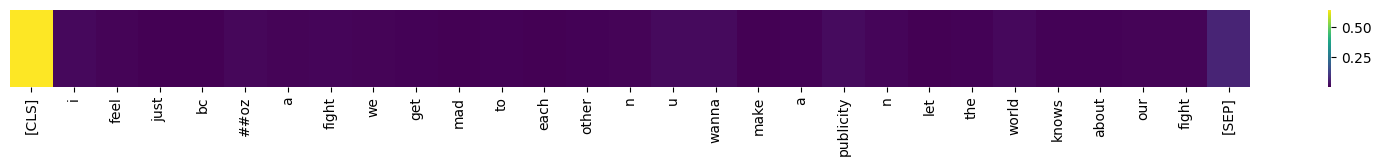

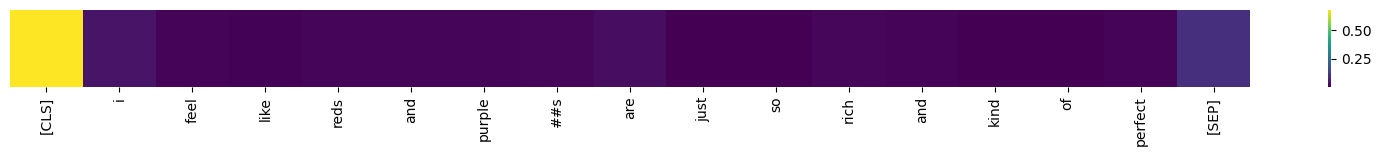

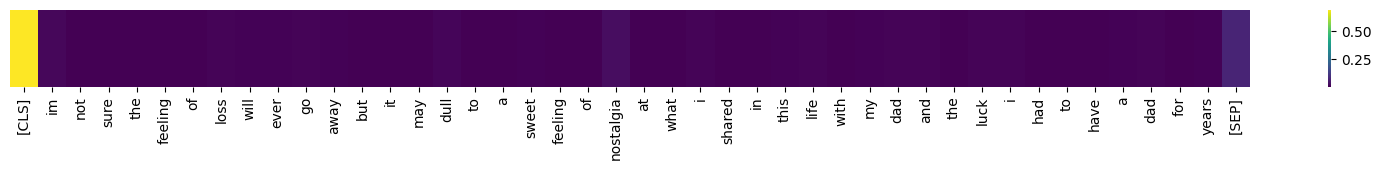

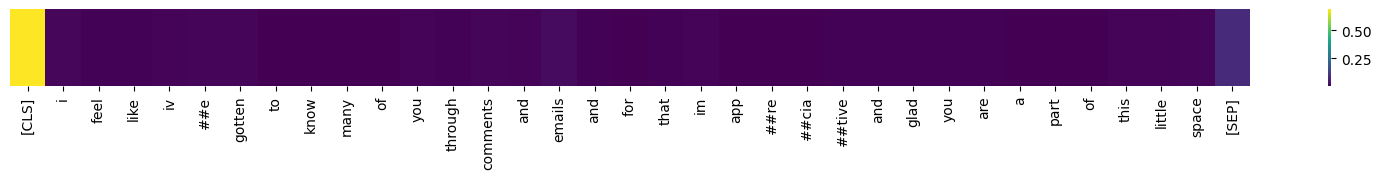

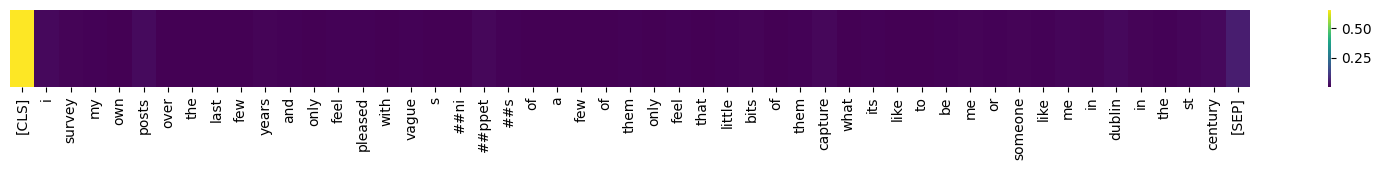

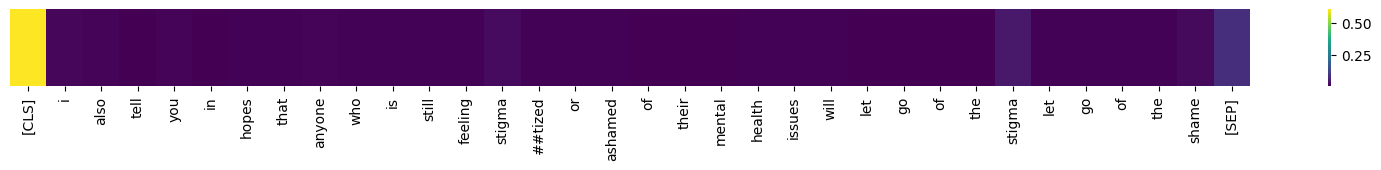

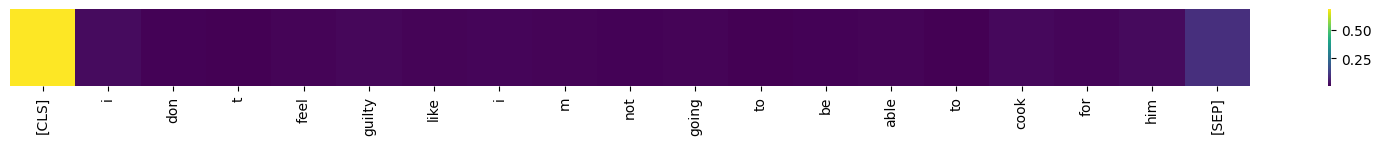

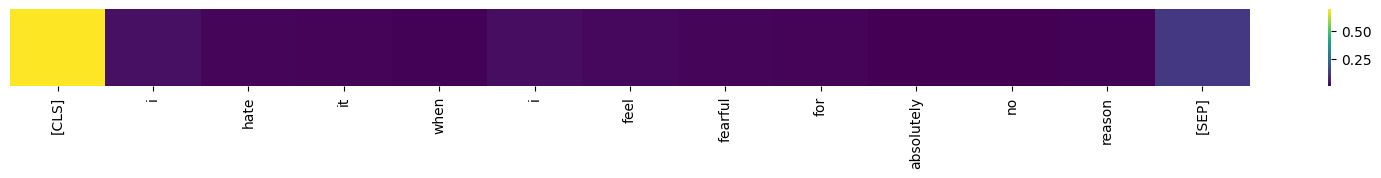

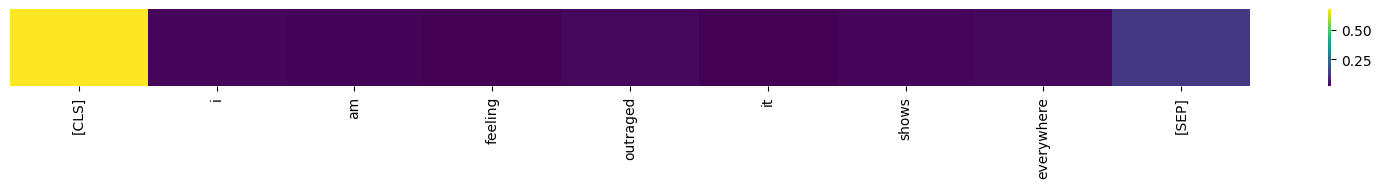

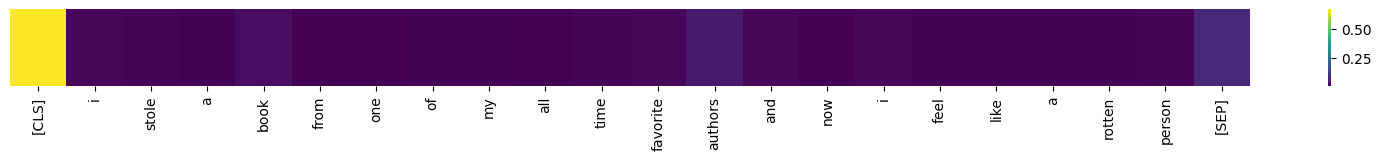

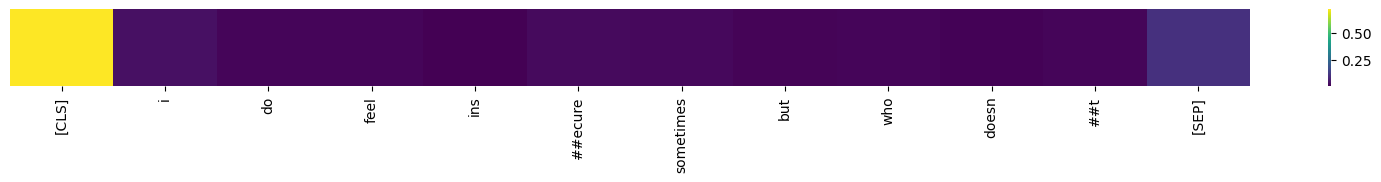

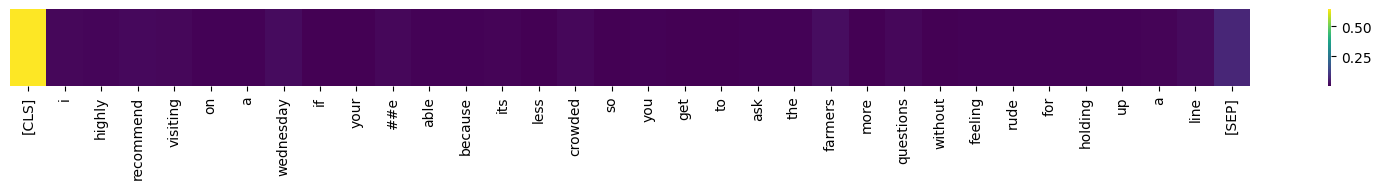

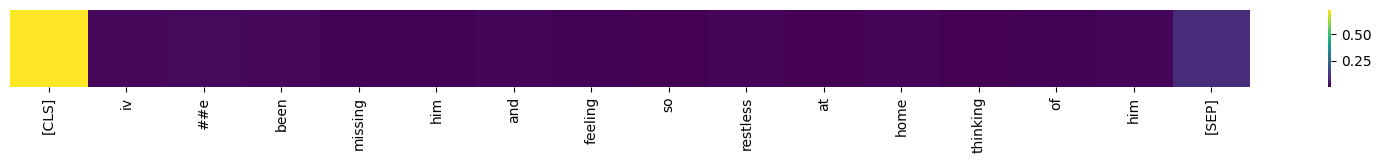

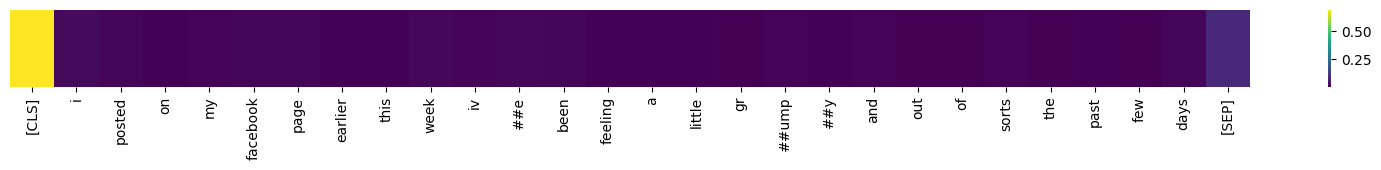

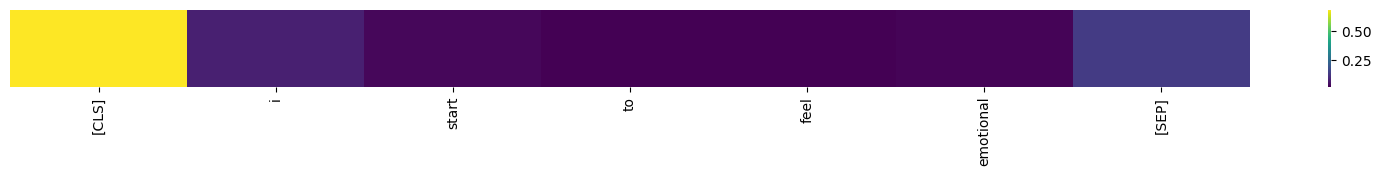

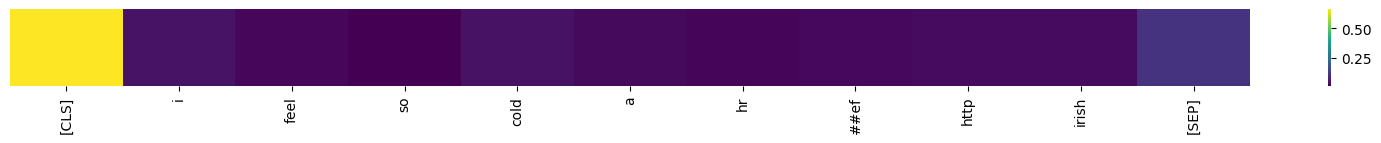

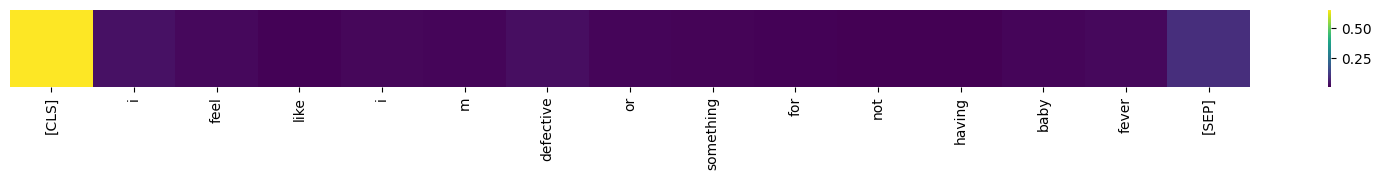

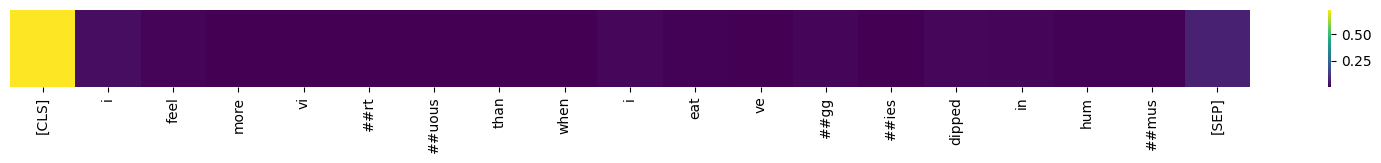

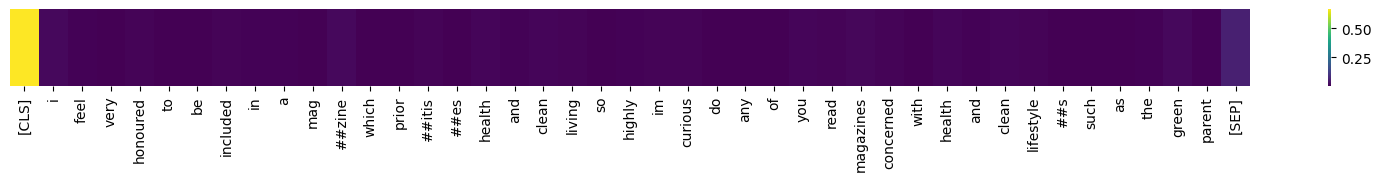

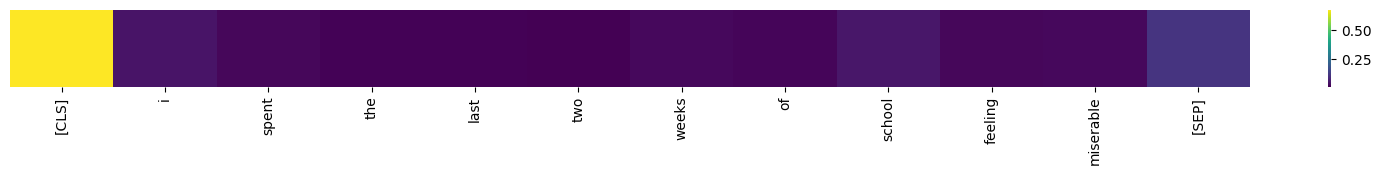

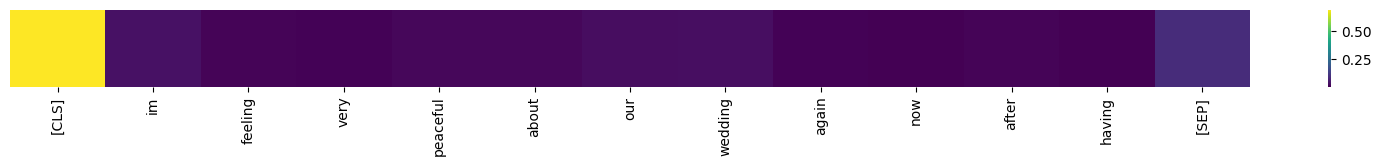

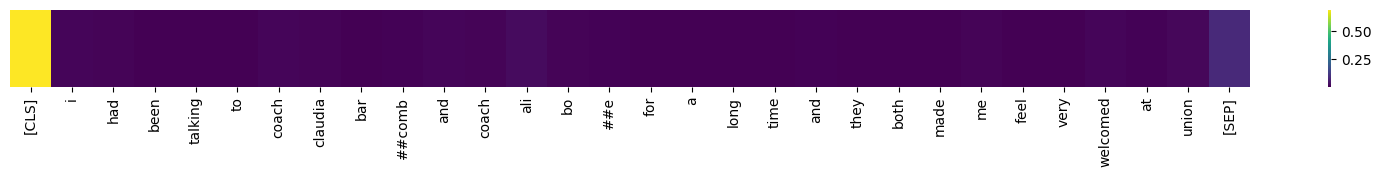

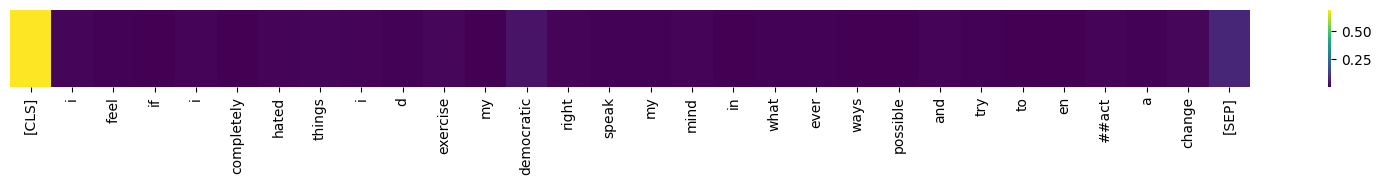

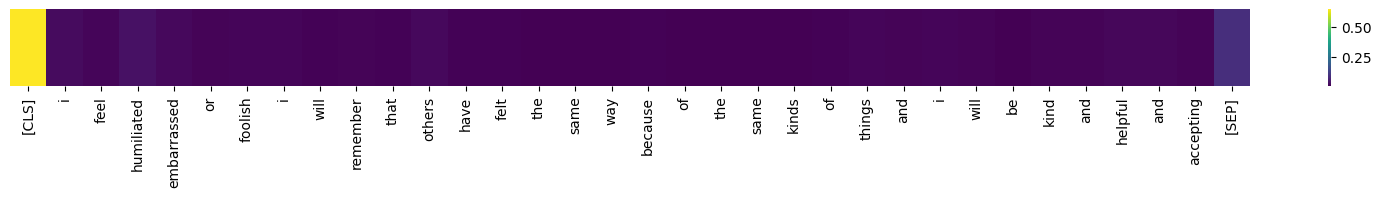

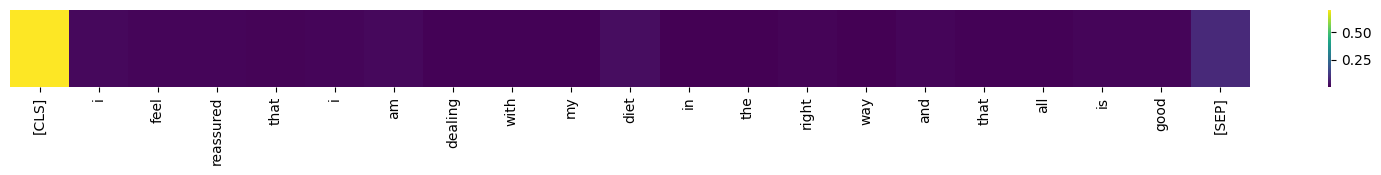

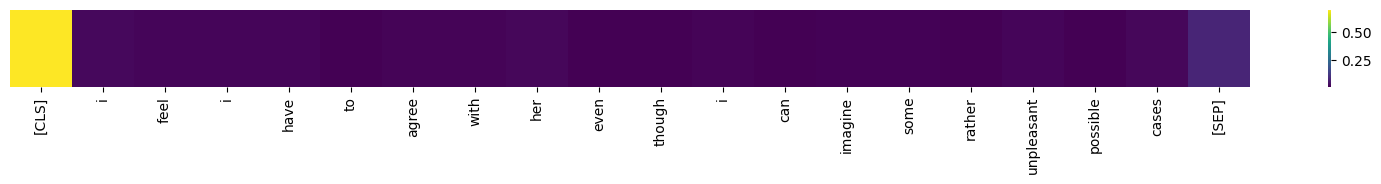

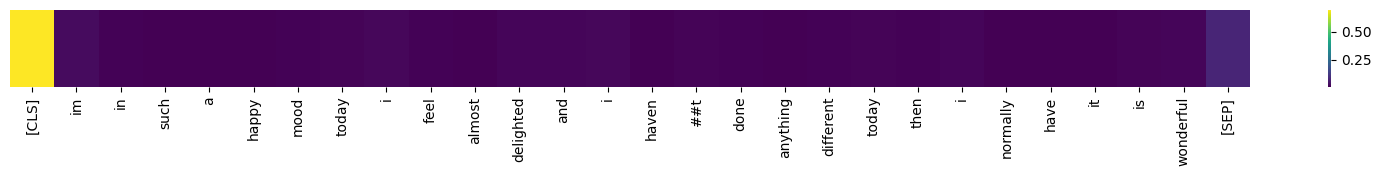

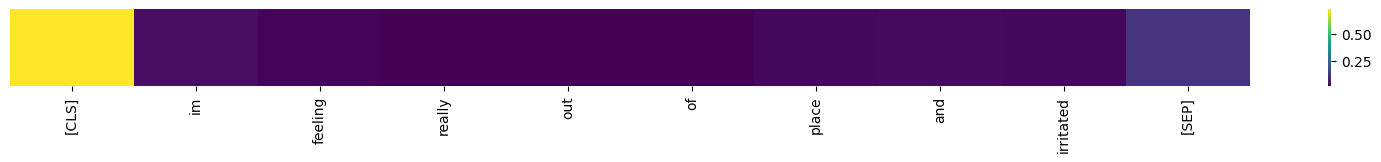

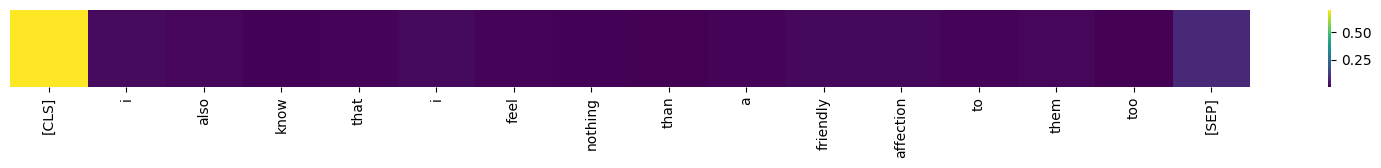

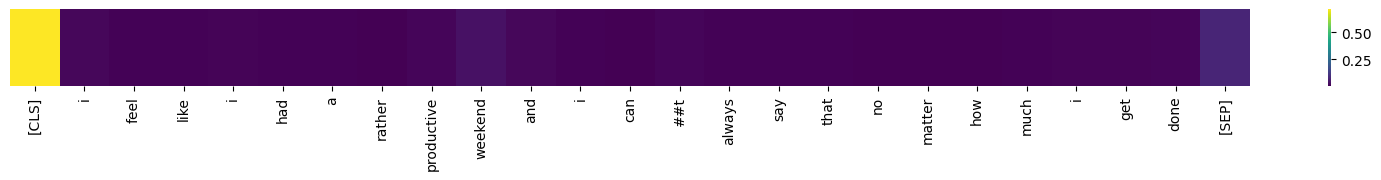

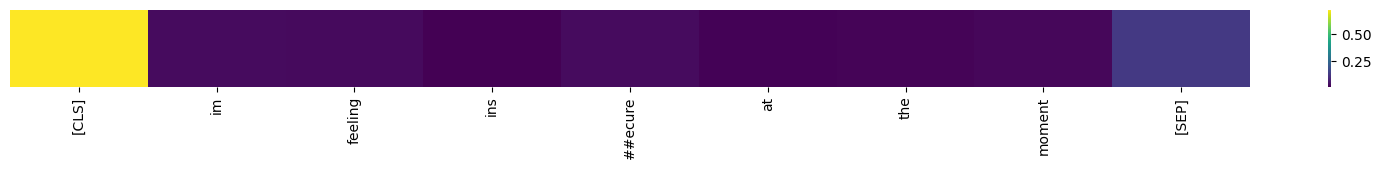

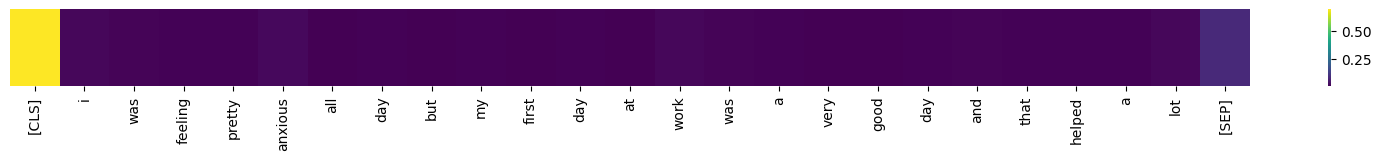

Average attention to key emotion words: {'happy': 0.015844107, 'irritated': 0.031356167, 'eager': 0.02141164, 'fearful': 0.056652118, 'anxious': 0.03113913, 'pleased': 0.0066400818, 'comfortable': 0.018007297, 'optimistic': 0.045978513, 'rotten': 0.01831357, 'ambitious': 0.0611583, 'uncomfortable': 0.02822665, 'anger': 0.040712263, 'immature': 0.01035292, 'excitement': 0.013255666, 'agitated': 0.06541493, 'invaded': 0.029064113, 'helpless': 0.021788334, 'supportive': 0.050837446, 'outraged': 0.054479416, 'restless': 0.019925775, 'productive': 0.02641754, 'peaceful': 0.03475365, 'welcomed': 0.024852926, 'delighted': 0.019854259, 'tired': 0.01659812, 'mad': 0.026354363, 'rude': 0.007520227, 'honoured': 0.012398538, 'reassured': 0.024839247, 'friendly': 0.04741509}
Average attention for correct predictions: 0.06314616
Average attention for incorrect predictions: 0.056738887
Text: im feeling rather rotten so im not very ambitious right now
Predicted: 3, Actual: 0
Attention to key emotion w

In [ ]:
# Loop over the selected test data
subset_size = 50  # Adjust the range as needed
subset_test_data = test_data.select(range(subset_size))

for example in subset_test_data:
    text = example['text']
    input_ids = tokenizer.encode(text, return_tensors='pt')

    logits, attentions = predict_with_attention(text)
    predicted_label = logits.argmax(dim=1).item()
    actual_label = example['label']

    attention_matrix = analyze_attention(attentions, input_ids, tokenizer, head_num=3, block_num=2)
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    plot_attention_heatmap(attention_matrix, tokens)

    # Additional Analysis
    key_word_attention = attention_to_key_words(attention_matrix, tokens, emotion_words)
    mean_att, std_att = calculate_attention_stats(attention_matrix)

    # Collecting data for post-experiment analysis
    attention_details.append({
        "text": text,
        "predicted_label": predicted_label,
        "actual_label": actual_label,
        "key_word_attention": key_word_attention,
        "mean_attention": mean_att,
        "std_attention": std_att
    })

    # Separate collection for correct and incorrect predictions
    if predicted_label == actual_label:
        correct_predictions_attention.append(mean_att)
    else:
        incorrect_predictions_attention.append(mean_att)

    # Collect attention to emotion words
    for word, attention in key_word_attention.items():
        emotion_word_attention[word].append(attention)


# Analyze the collected data

# Average attention to emotion words
average_attention_per_word = {word: np.mean(attentions) for word, attentions in emotion_word_attention.items() if attentions}
print("Average attention to key emotion words:", average_attention_per_word)

# Comparison of attention in correct vs. incorrect predictions
print("Average attention for correct predictions:", np.mean(correct_predictions_attention))
print("Average attention for incorrect predictions:", np.mean(incorrect_predictions_attention))

# Error analysis on incorrect predictions
for detail in attention_details:
    if detail['predicted_label'] != detail['actual_label']:
        print(f"Text: {detail['text']}")
        print(f"Predicted: {detail['predicted_label']}, Actual: {detail['actual_label']}")
        print(f"Attention to key emotion words: {detail['key_word_attention']}\n")



**Head at 4; block at 4**

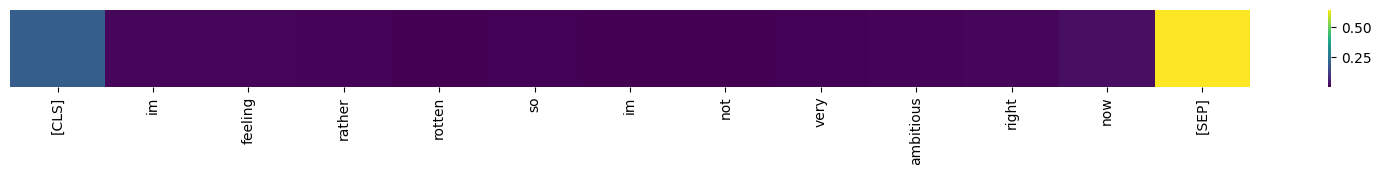

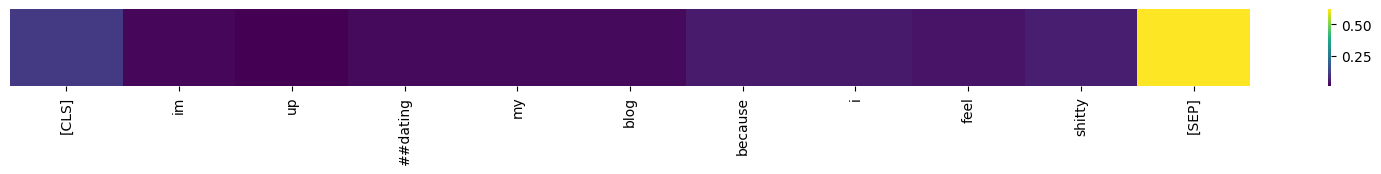

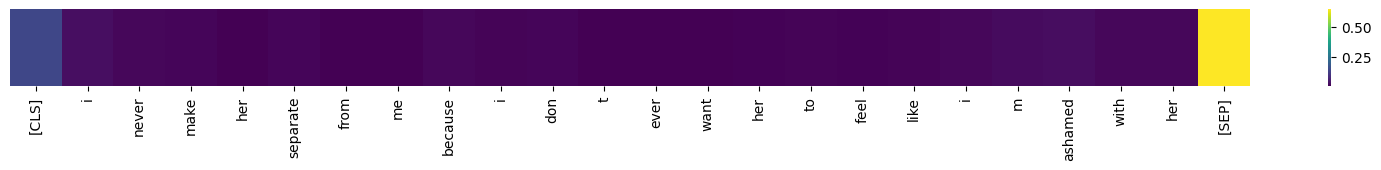

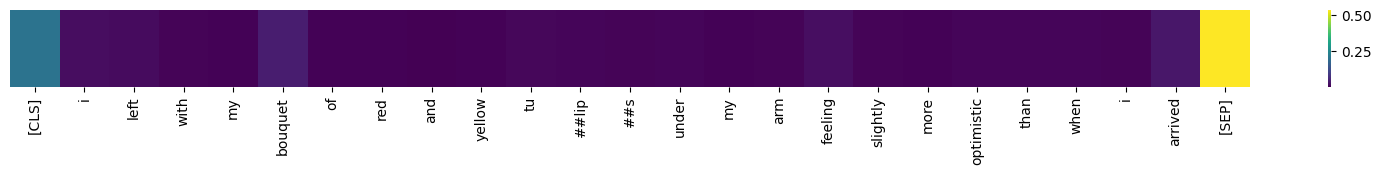

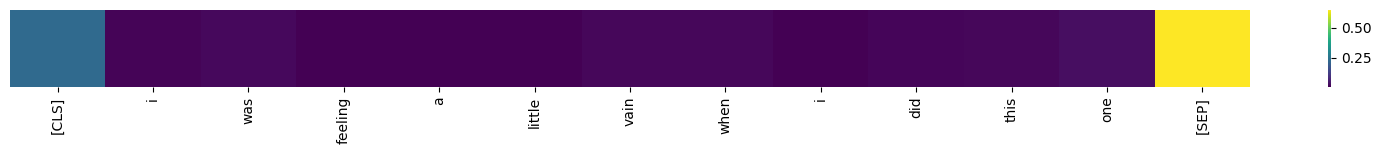

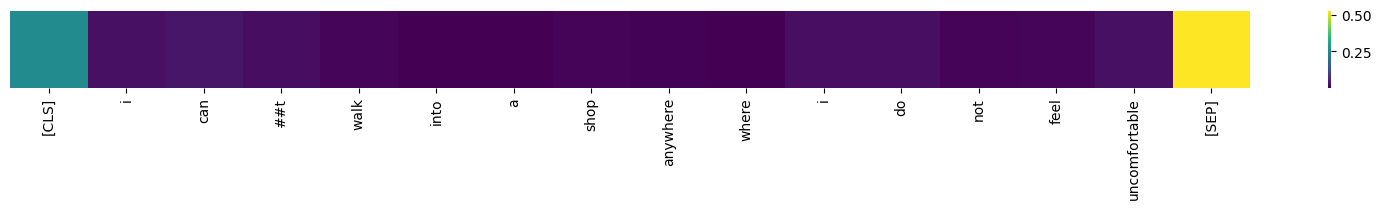

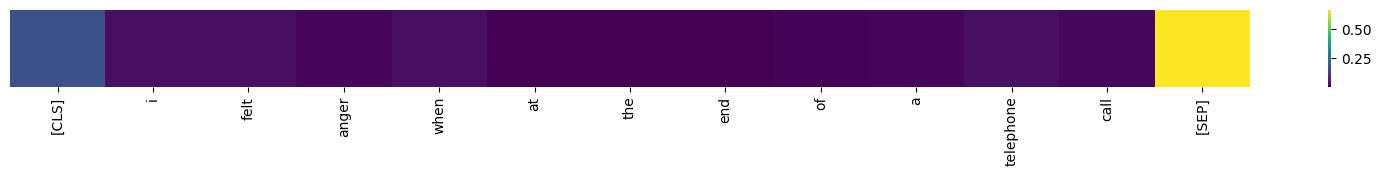

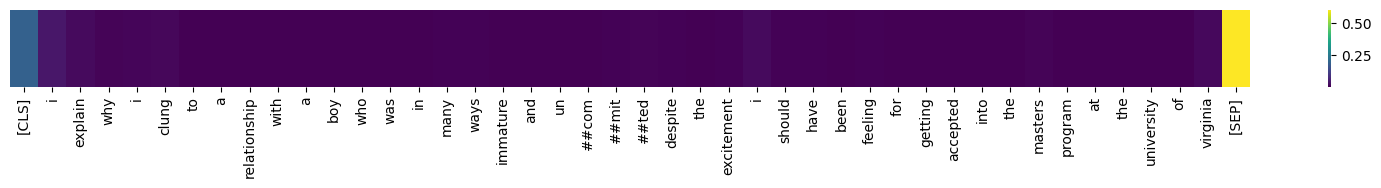

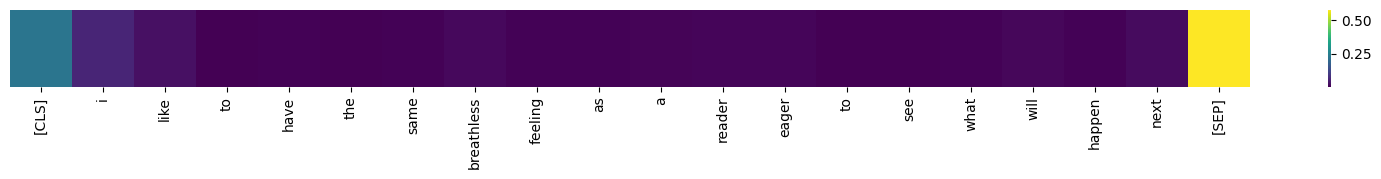

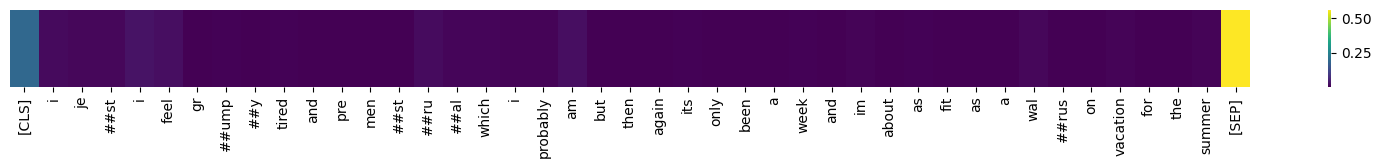

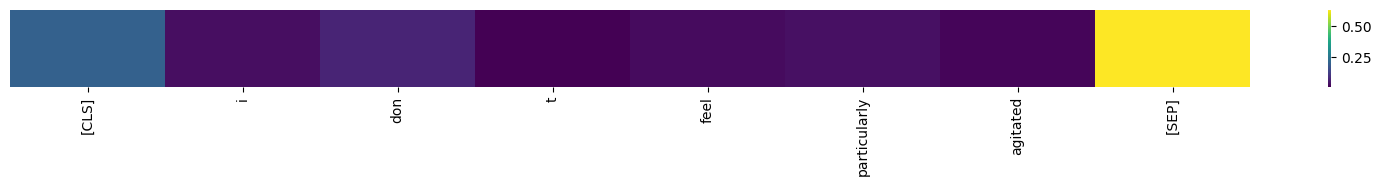

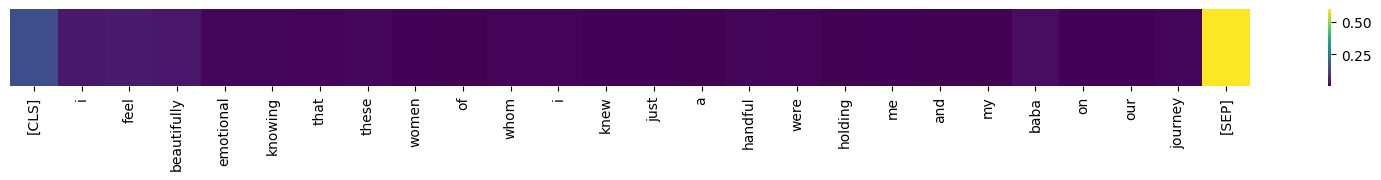

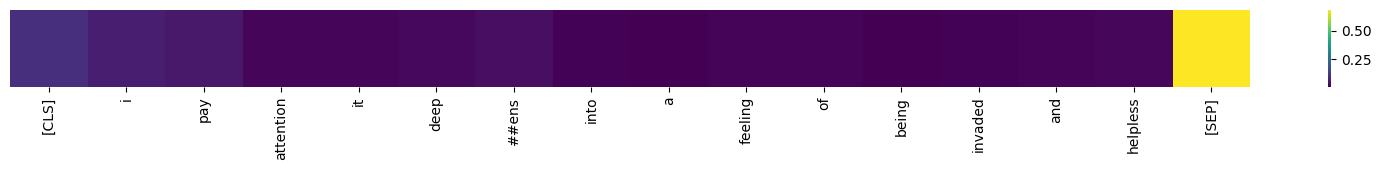

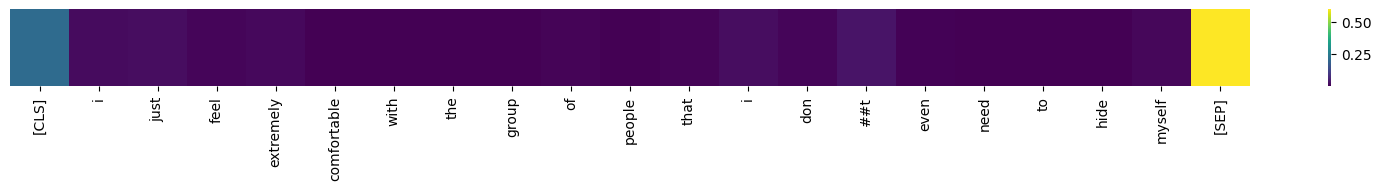

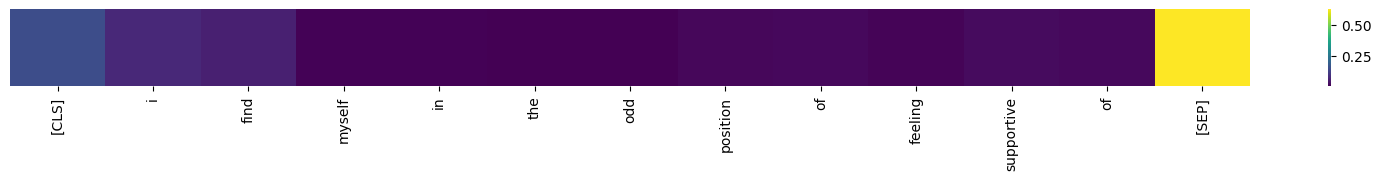

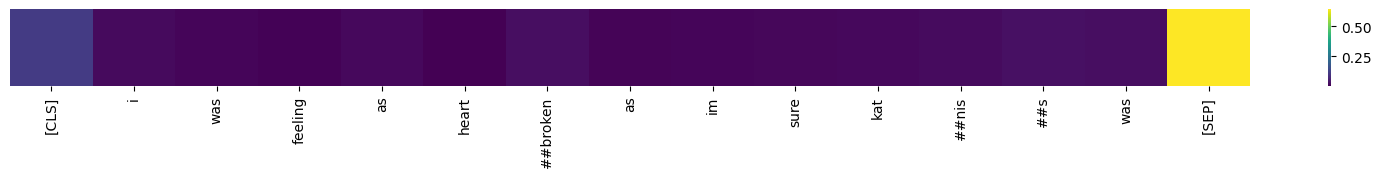

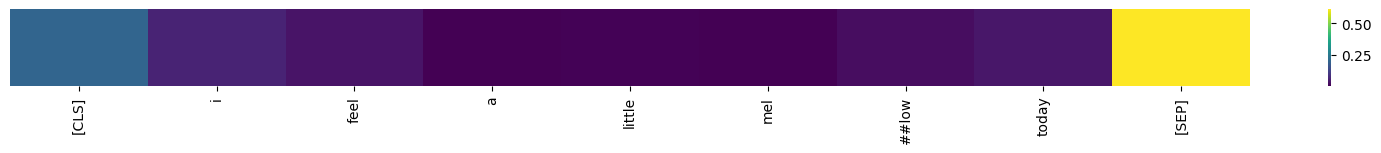

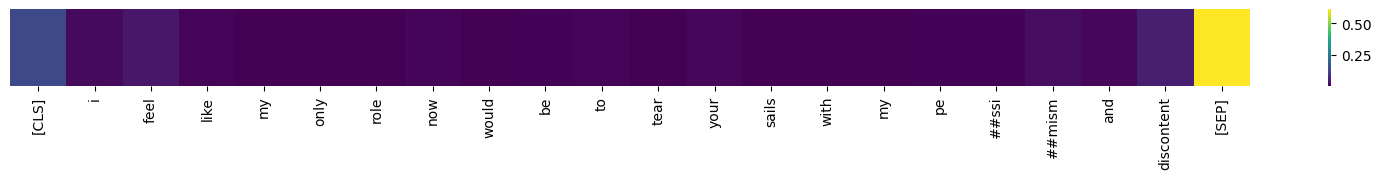

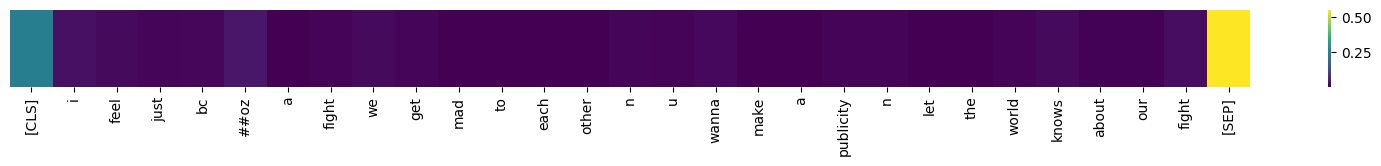

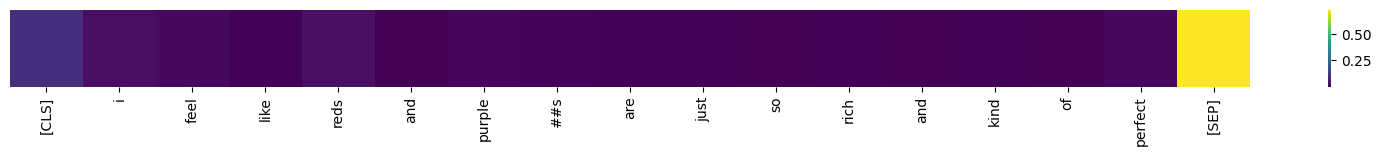

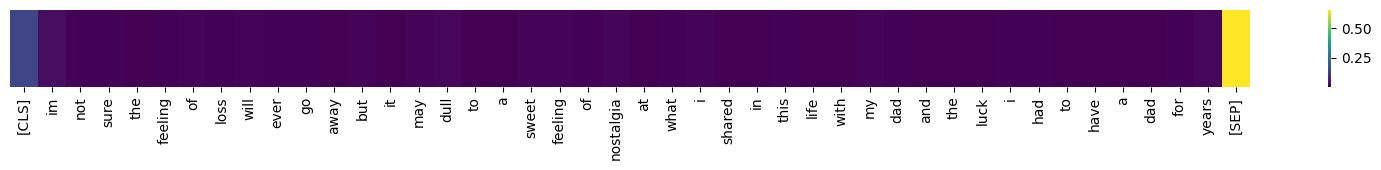

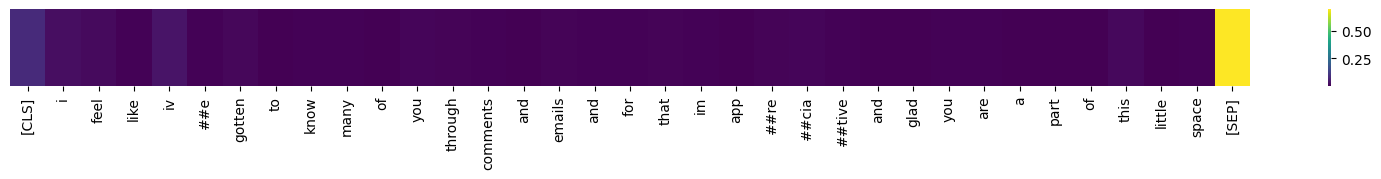

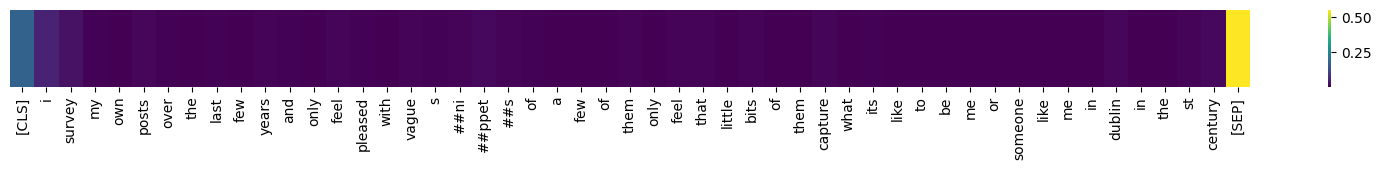

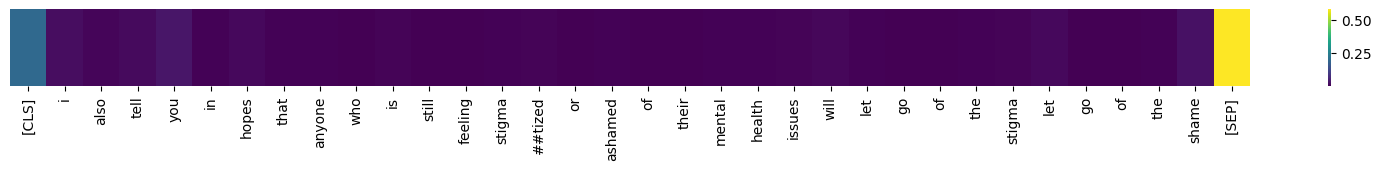

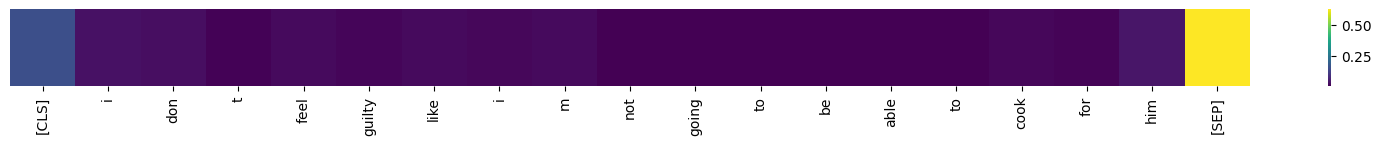

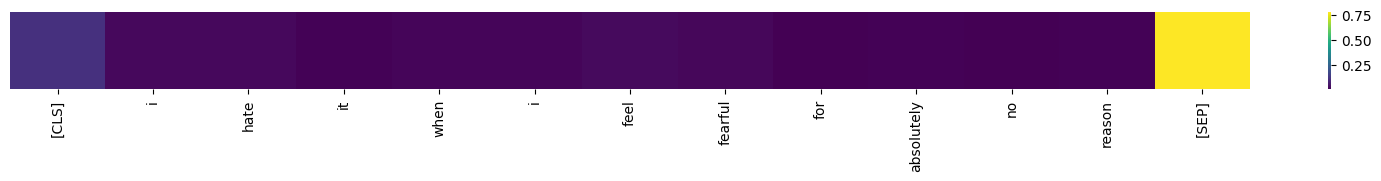

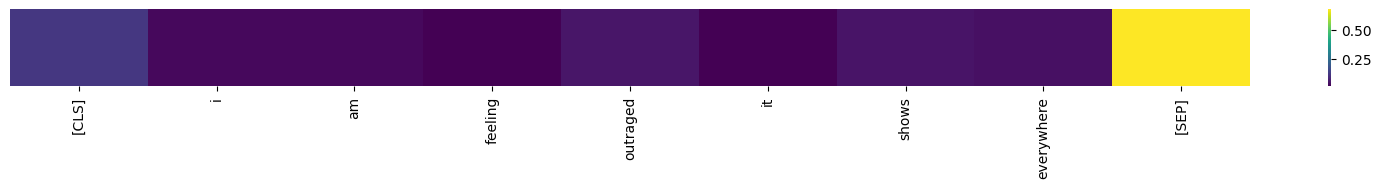

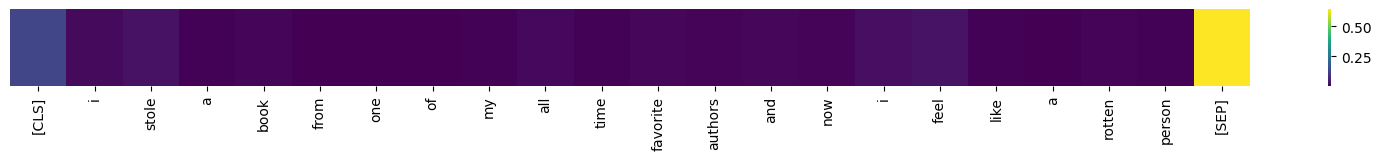

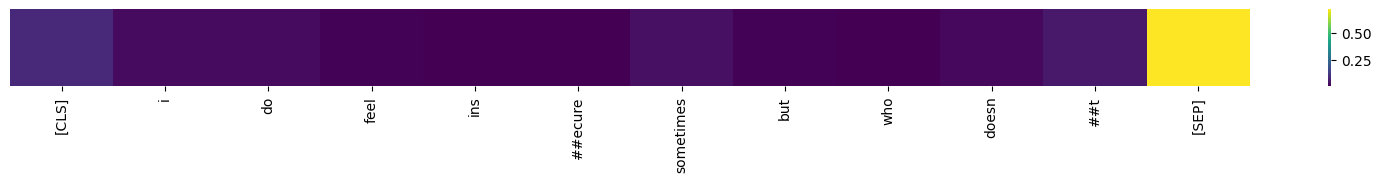

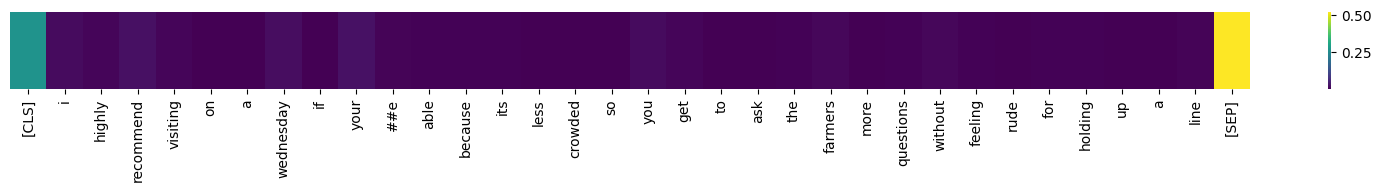

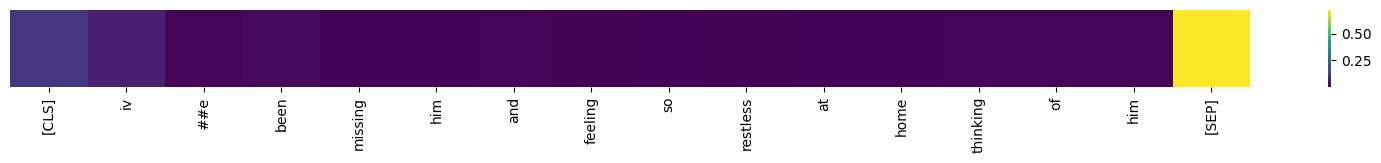

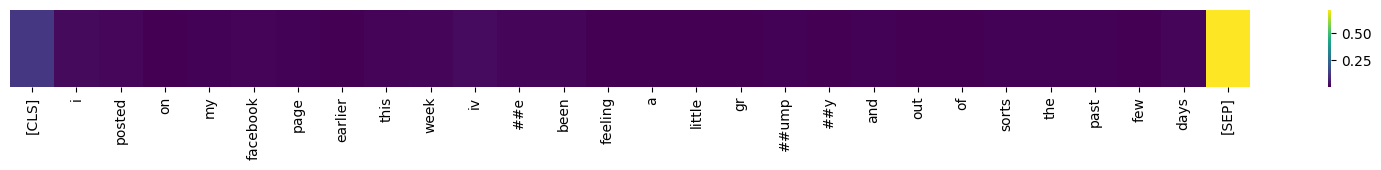

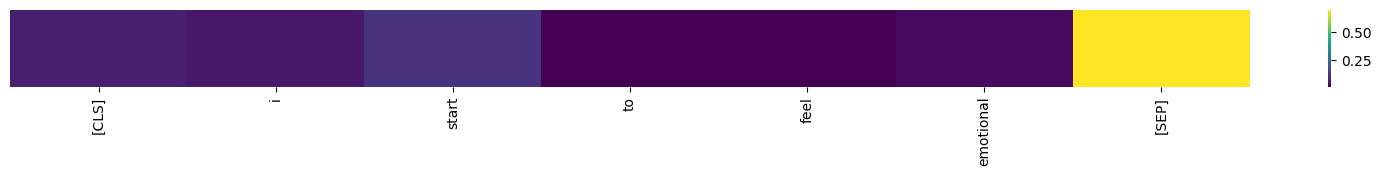

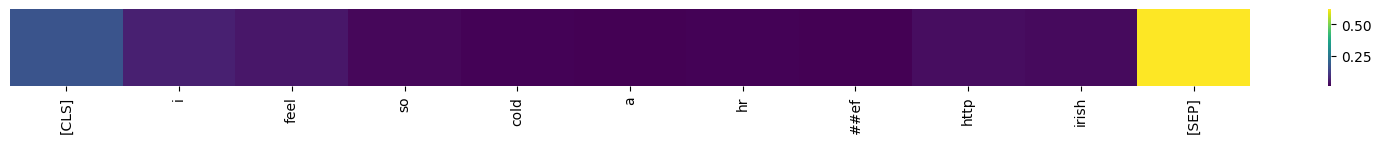

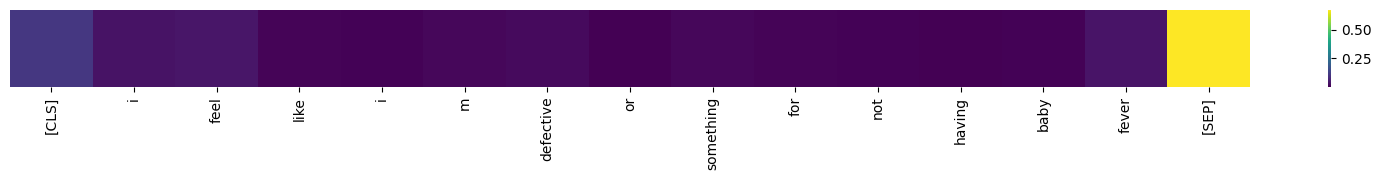

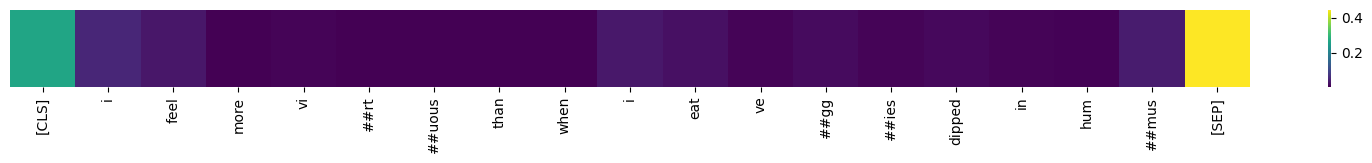

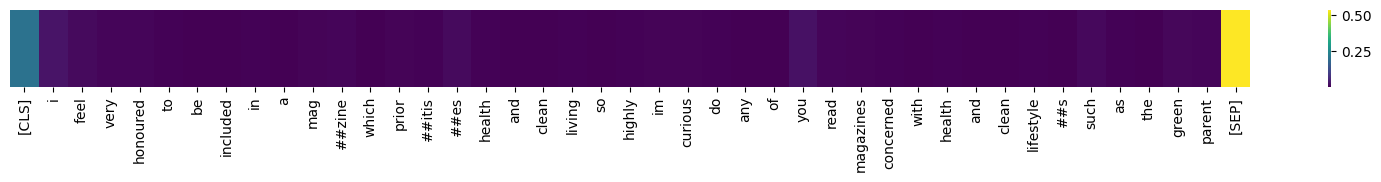

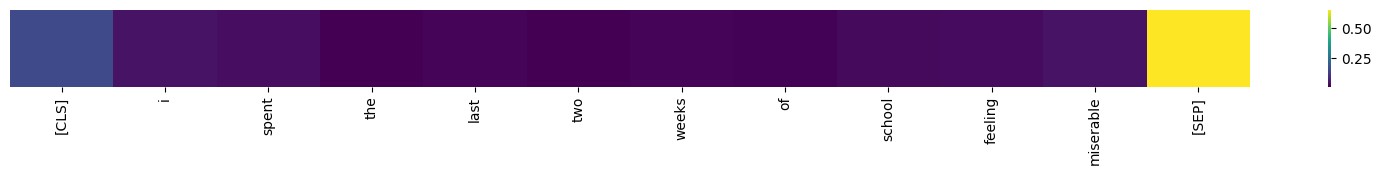

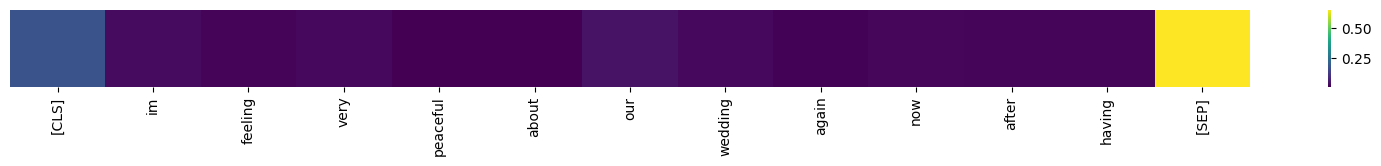

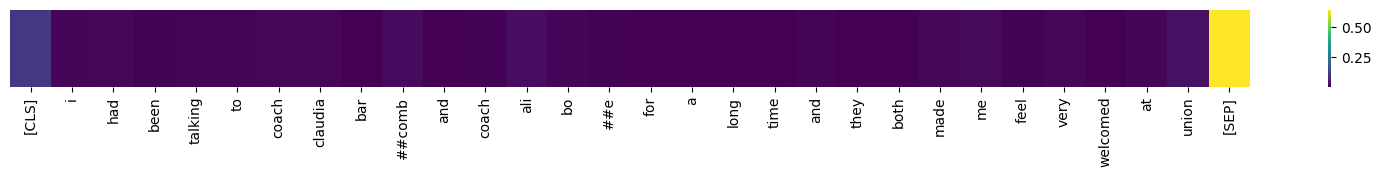

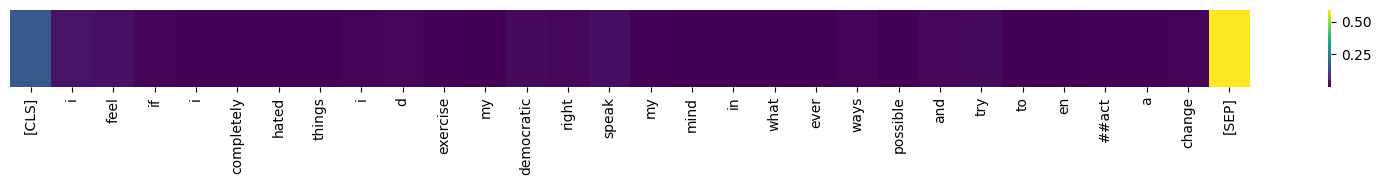

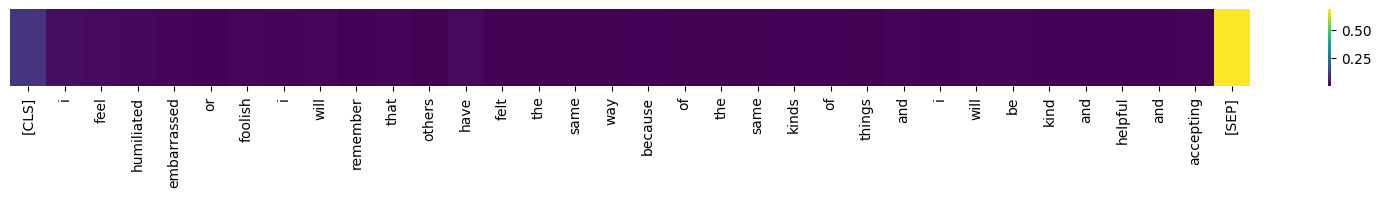

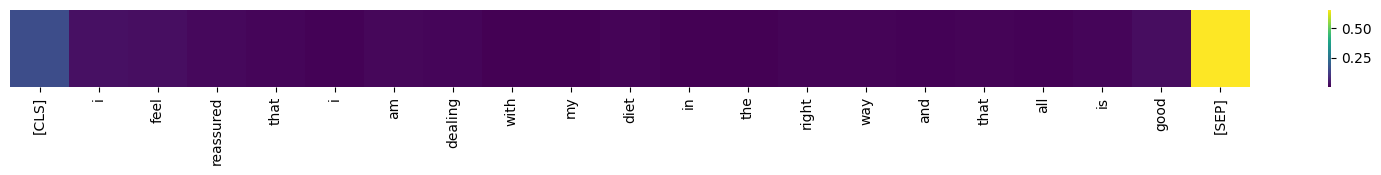

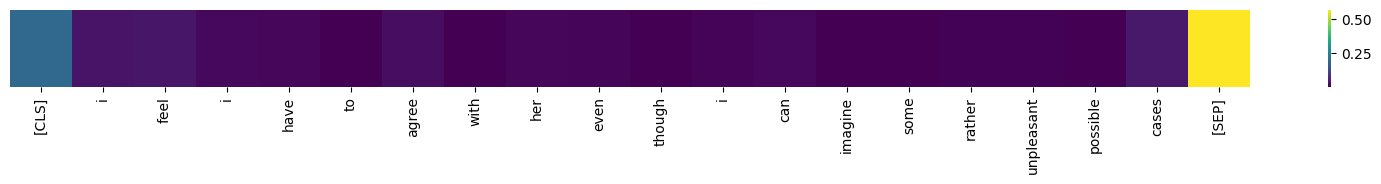

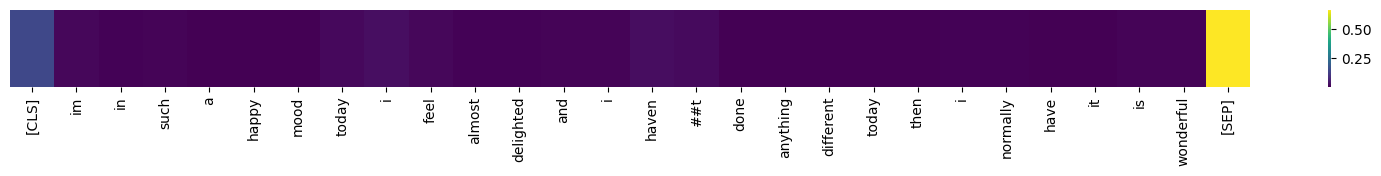

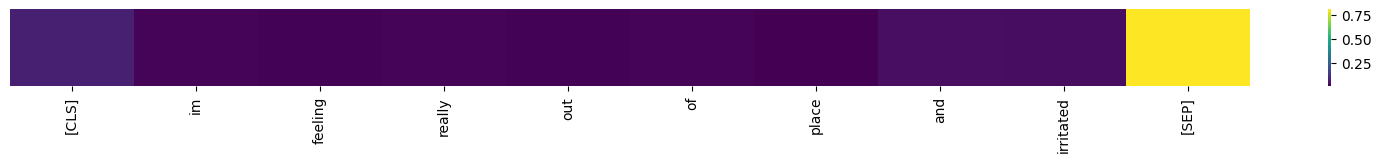

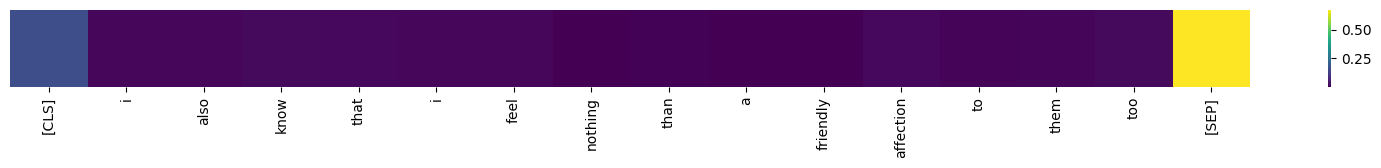

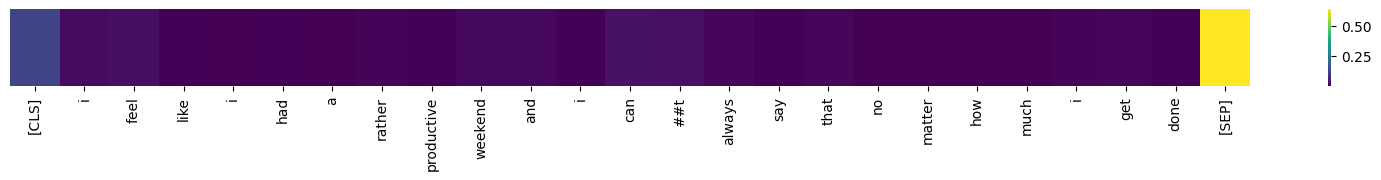

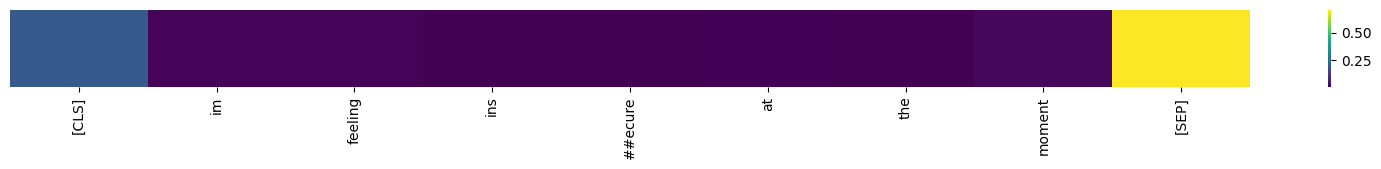

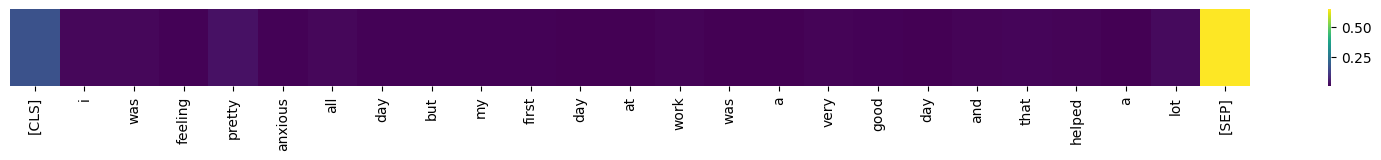

Average attention to key emotion words: {'happy': 0.012519564, 'irritated': 0.030909596, 'eager': 0.01832813, 'fearful': 0.0463966, 'anxious': 0.024475118, 'pleased': 0.0062771155, 'comfortable': 0.0142529365, 'optimistic': 0.036862183, 'rotten': 0.015801959, 'ambitious': 0.04915797, 'uncomfortable': 0.027718032, 'anger': 0.03357692, 'immature': 0.008336253, 'excitement': 0.010977946, 'agitated': 0.052536685, 'invaded': 0.023415586, 'helpless': 0.019460613, 'supportive': 0.04331377, 'outraged': 0.053190757, 'restless': 0.015368122, 'productive': 0.021156628, 'peaceful': 0.027173907, 'welcomed': 0.019182736, 'delighted': 0.01587085}
Average attention for correct predictions: 0.06314617
Average attention for incorrect predictions: 0.05673889
Text: im feeling rather rotten so im not very ambitious right now
Predicted: 3, Actual: 0
Attention to key emotion words: {'rotten': 0.009209858, 'ambitious': 0.04176094}

Text: i left with my bouquet of red and yellow tulips under my arm feeling sli

In [ ]:
# Loop over the selected test data
subset_size = 50  # Adjust the range as needed
subset_test_data = test_data.select(range(subset_size))

for example in subset_test_data:
    text = example['text']
    input_ids = tokenizer.encode(text, return_tensors='pt')

    logits, attentions = predict_with_attention(text)
    predicted_label = logits.argmax(dim=1).item()
    actual_label = example['label']

    attention_matrix = analyze_attention(attentions, input_ids, tokenizer, head_num=4, block_num=4)
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    plot_attention_heatmap(attention_matrix, tokens)

    # Additional Analysis
    key_word_attention = attention_to_key_words(attention_matrix, tokens, emotion_words)
    mean_att, std_att = calculate_attention_stats(attention_matrix)

    # Collecting data for post-experiment analysis
    attention_details.append({
        "text": text,
        "predicted_label": predicted_label,
        "actual_label": actual_label,
        "key_word_attention": key_word_attention,
        "mean_attention": mean_att,
        "std_attention": std_att
    })

    # Separate collection for correct and incorrect predictions
    if predicted_label == actual_label:
        correct_predictions_attention.append(mean_att)
    else:
        incorrect_predictions_attention.append(mean_att)

    # Collect attention to emotion words
    for word, attention in key_word_attention.items():
        emotion_word_attention[word].append(attention)


# Analyze the collected data

# Average attention to emotion words
average_attention_per_word = {word: np.mean(attentions) for word, attentions in emotion_word_attention.items() if attentions}
print("Average attention to key emotion words:", average_attention_per_word)

# Comparison of attention in correct vs. incorrect predictions
print("Average attention for correct predictions:", np.mean(correct_predictions_attention))
print("Average attention for incorrect predictions:", np.mean(incorrect_predictions_attention))

# Error analysis on incorrect predictions
for detail in attention_details:
    if detail['predicted_label'] != detail['actual_label']:
        print(f"Text: {detail['text']}")
        print(f"Predicted: {detail['predicted_label']}, Actual: {detail['actual_label']}")
        print(f"Attention to key emotion words: {detail['key_word_attention']}\n")



**Head:8; Block:8**

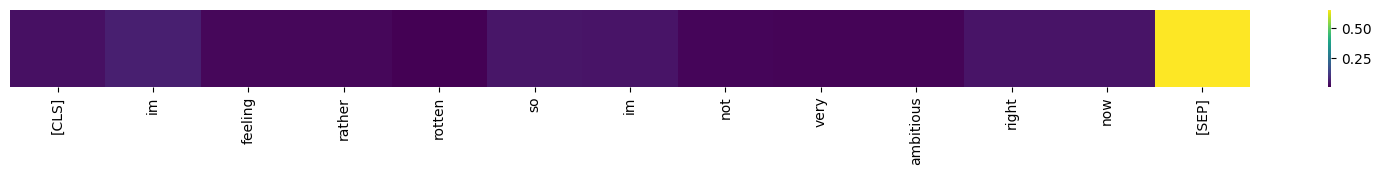

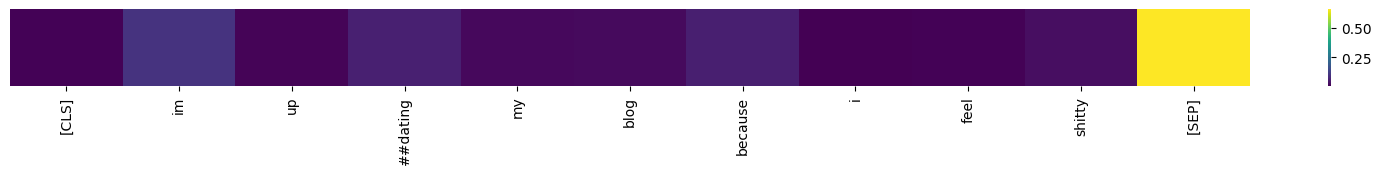

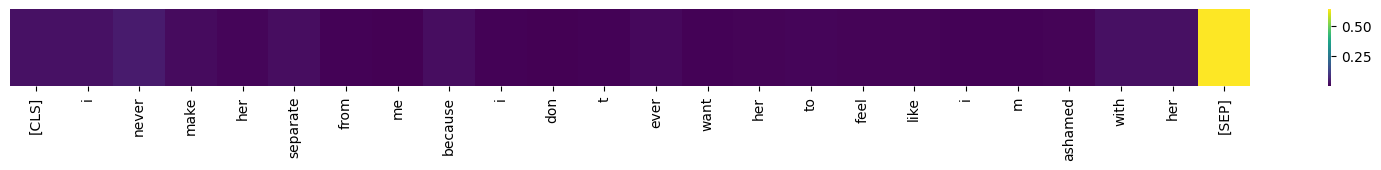

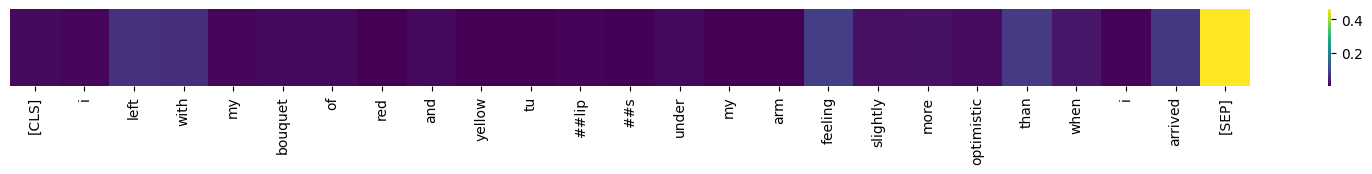

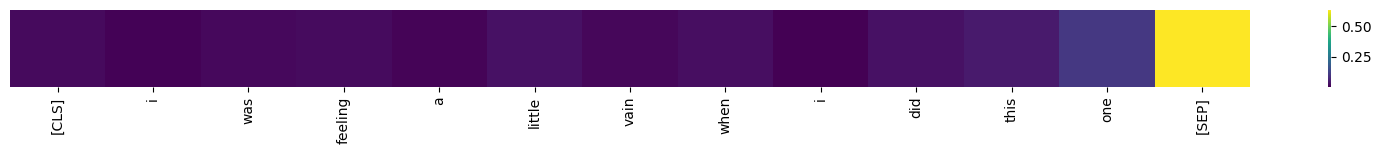

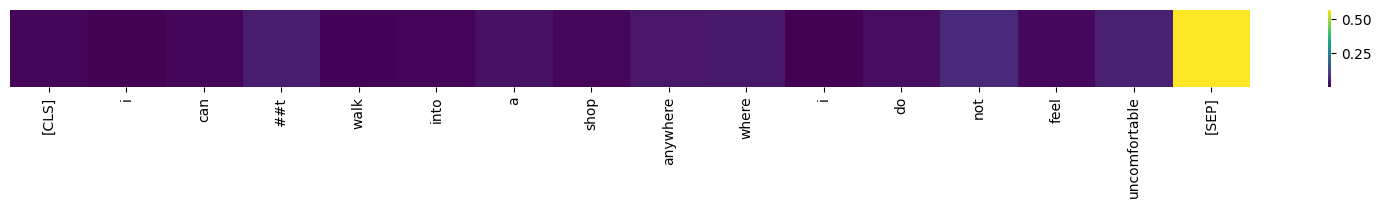

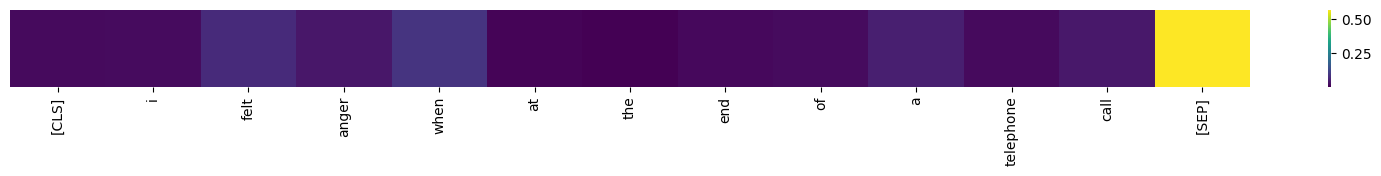

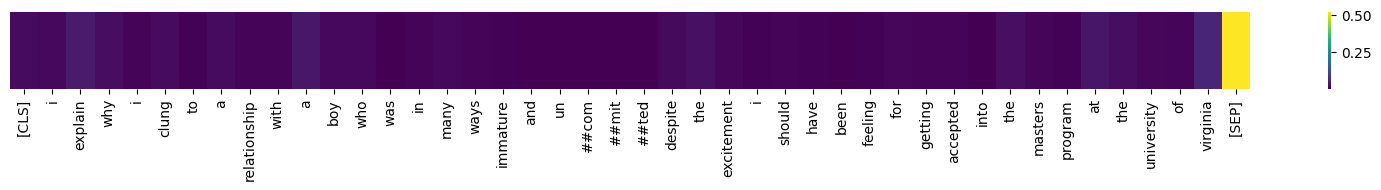

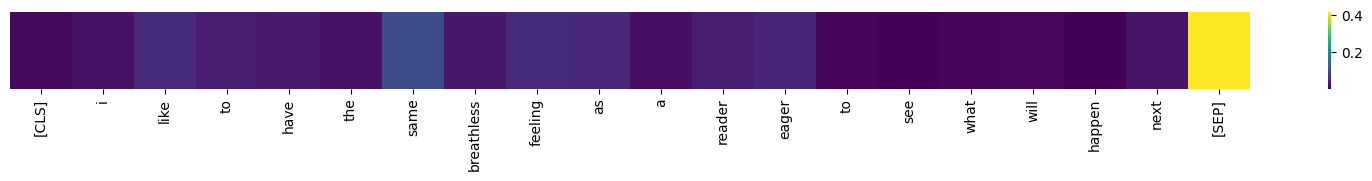

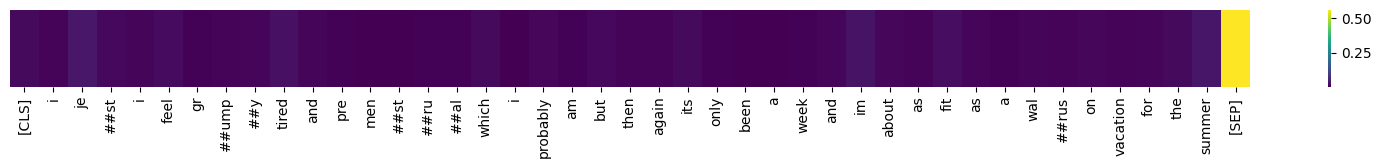

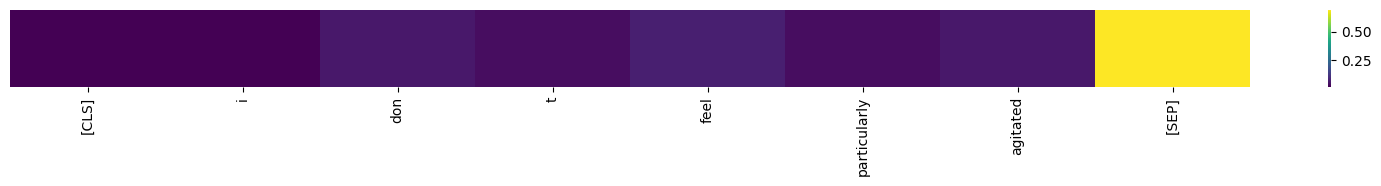

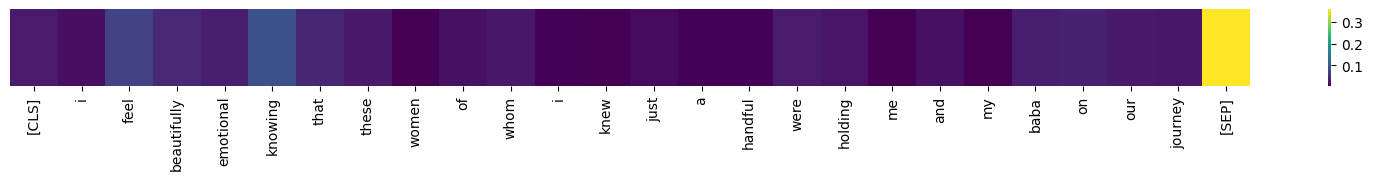

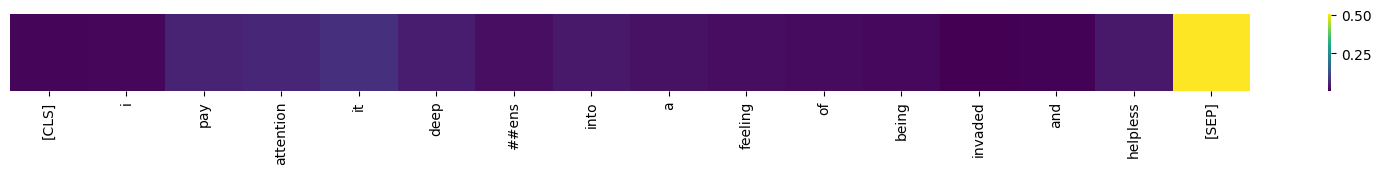

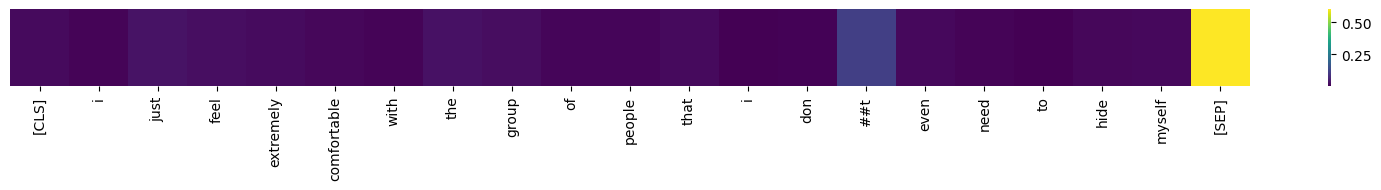

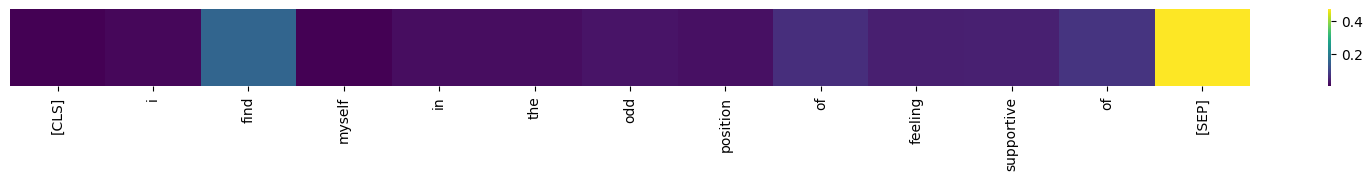

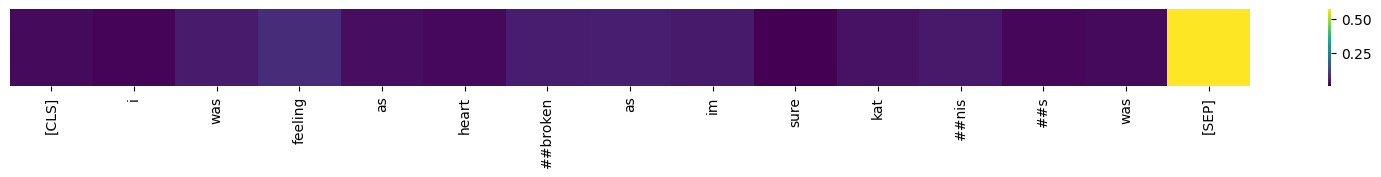

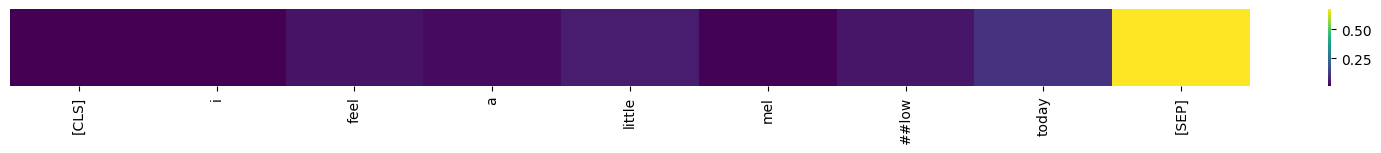

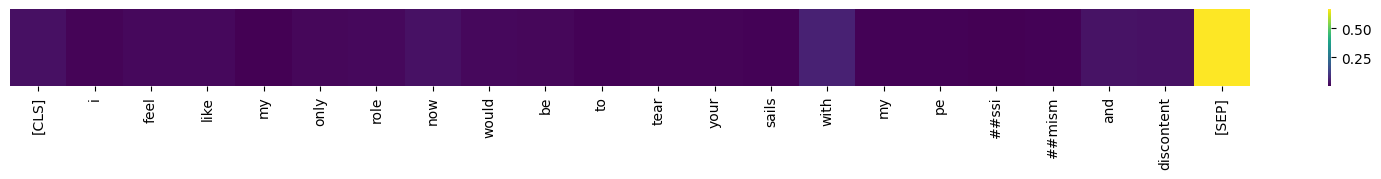

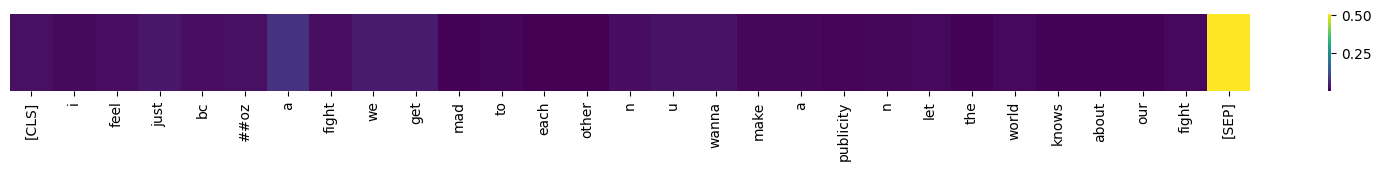

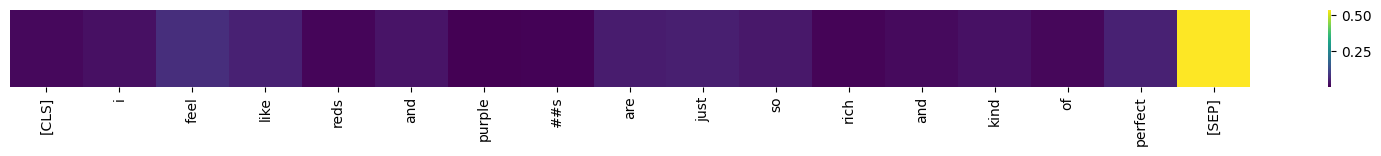

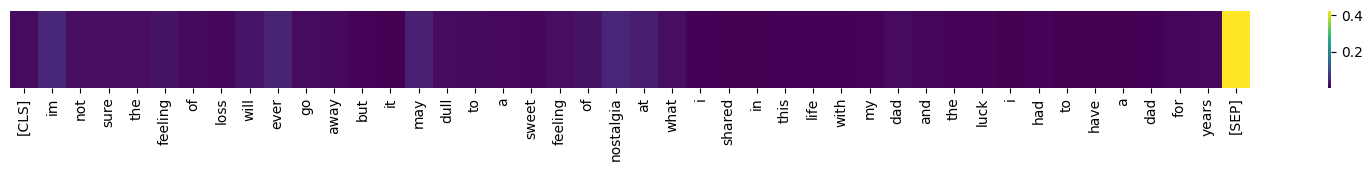

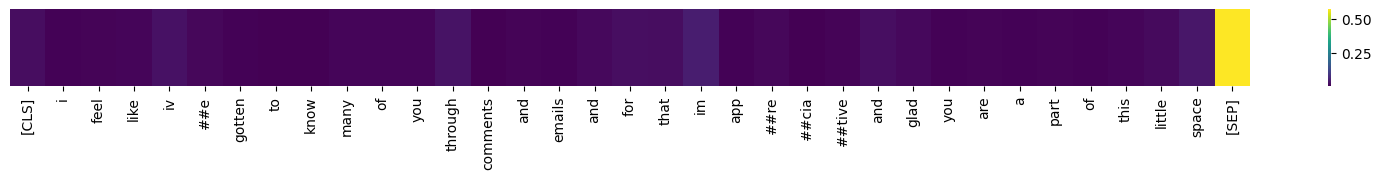

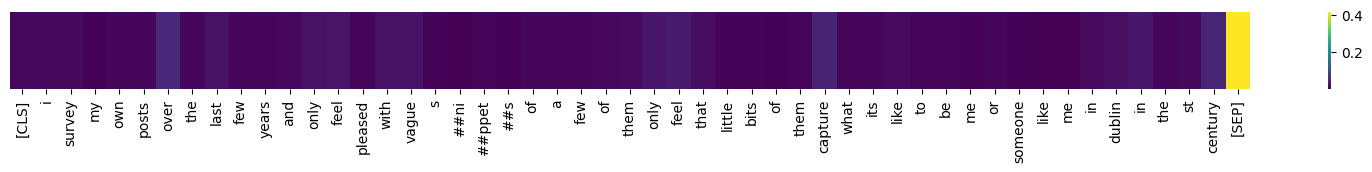

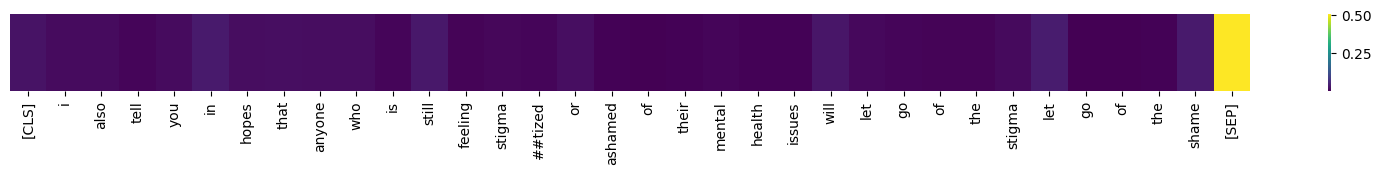

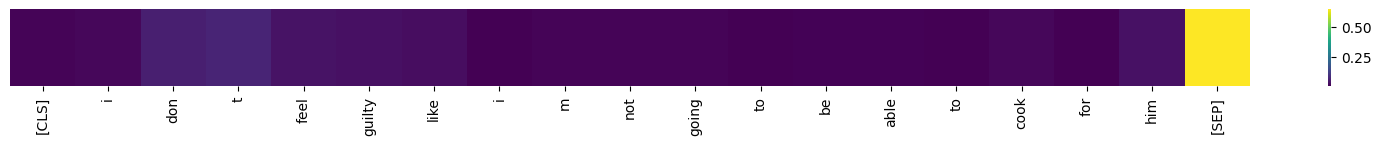

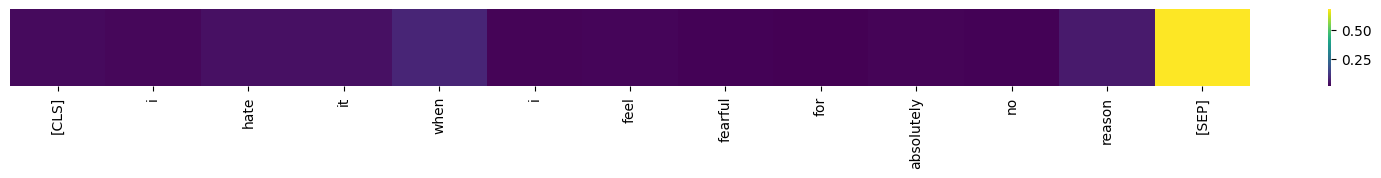

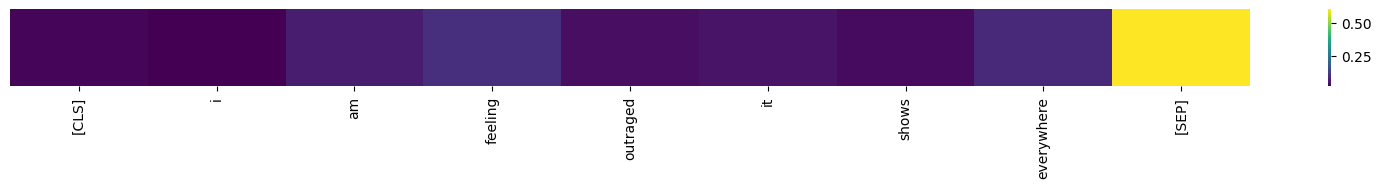

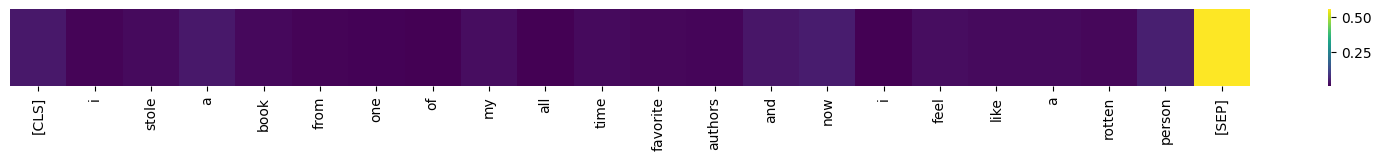

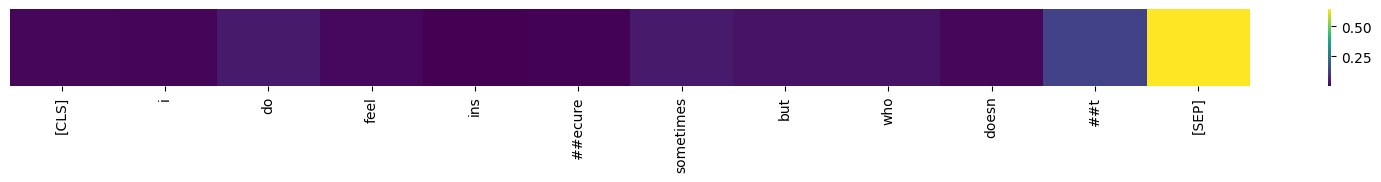

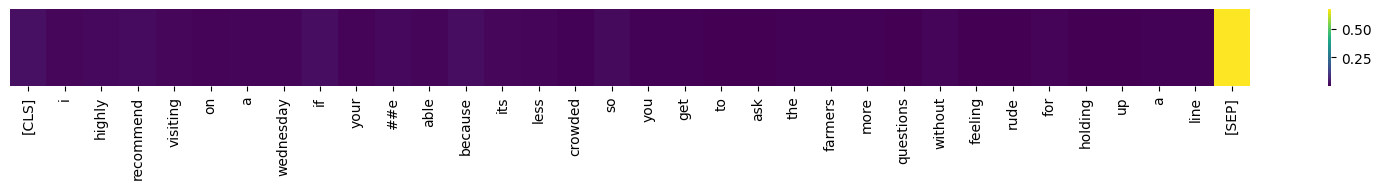

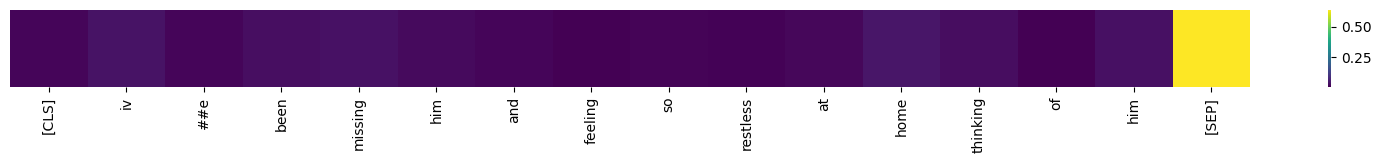

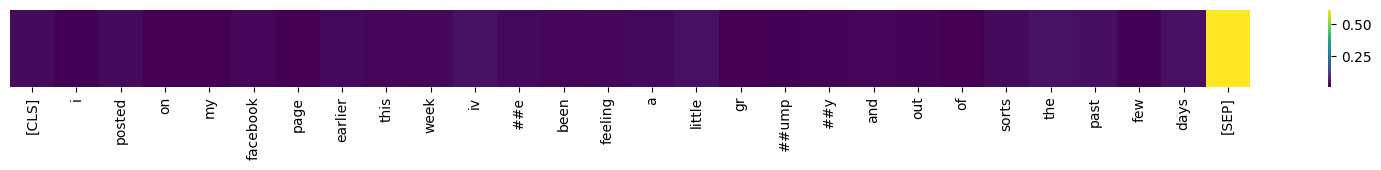

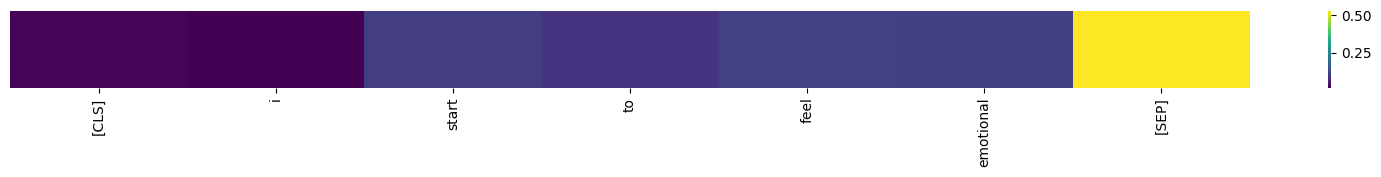

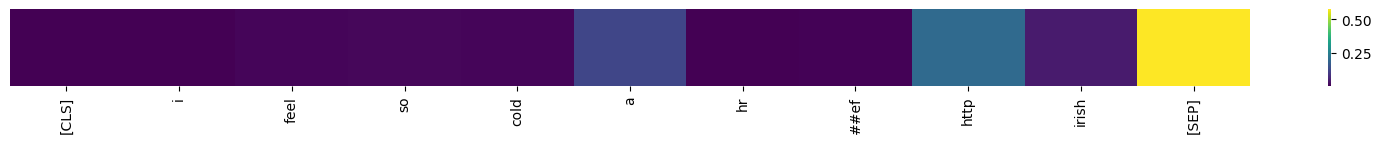

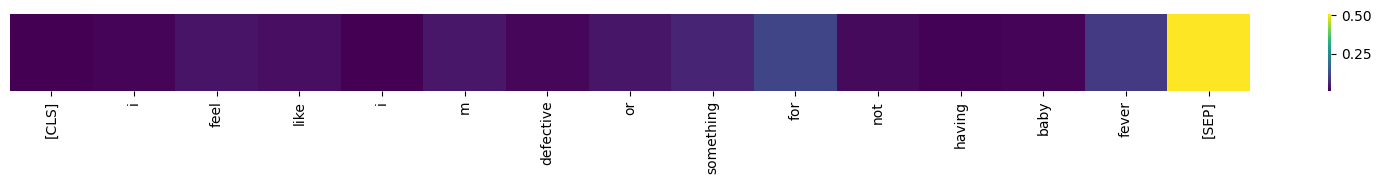

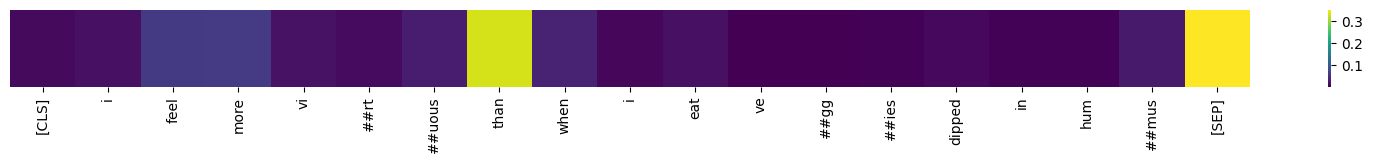

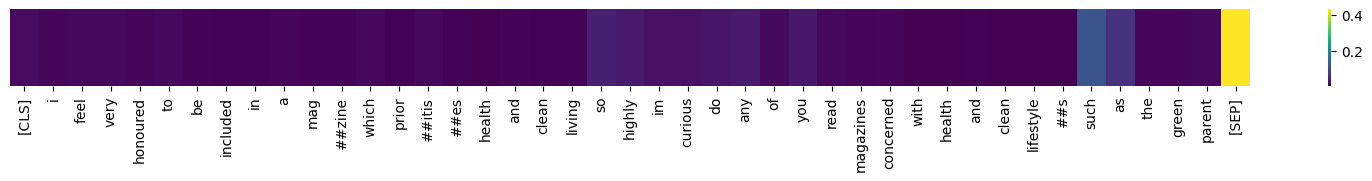

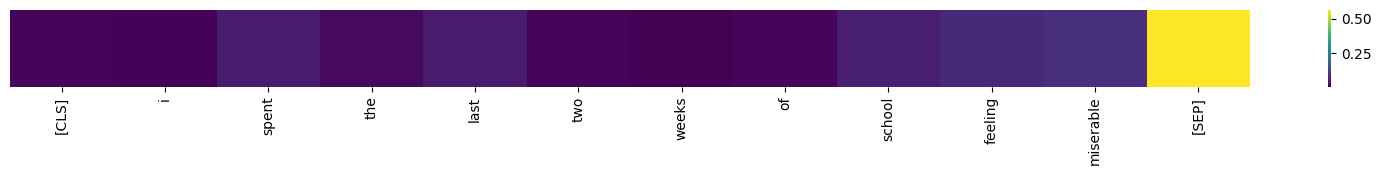

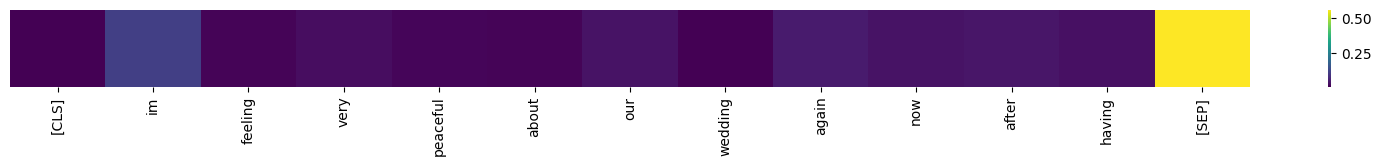

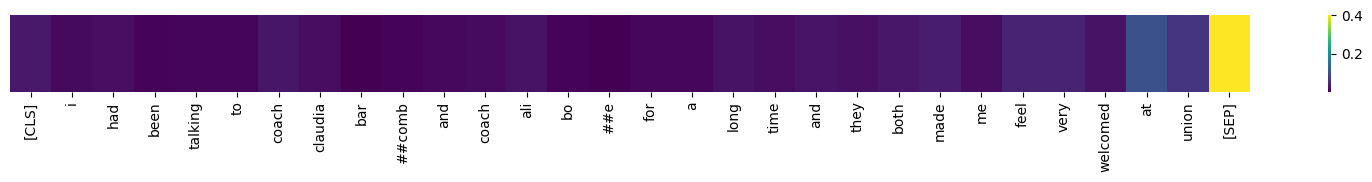

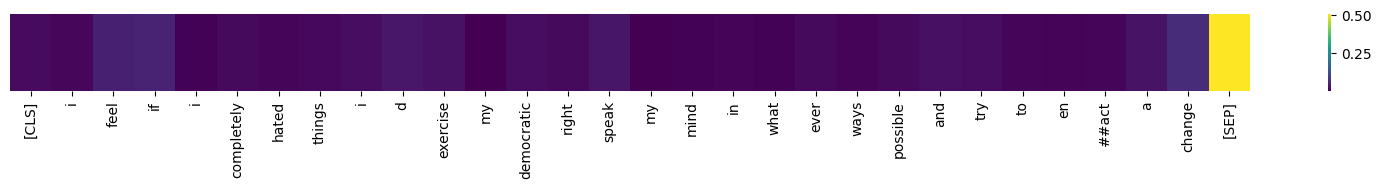

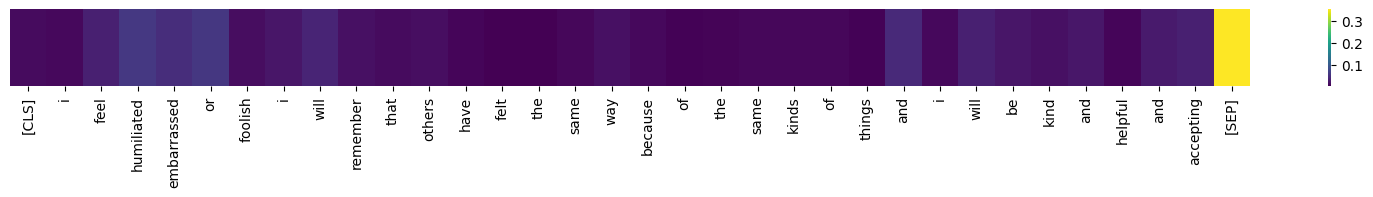

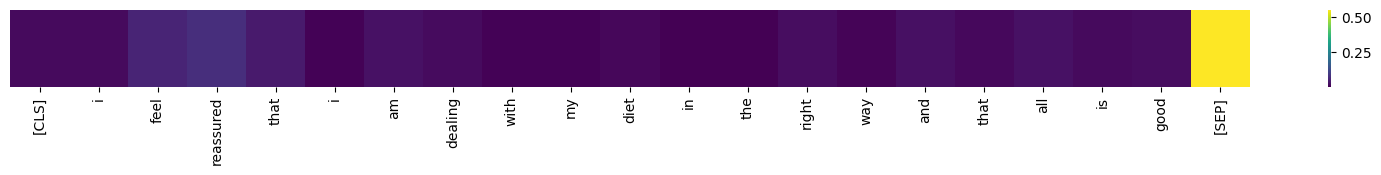

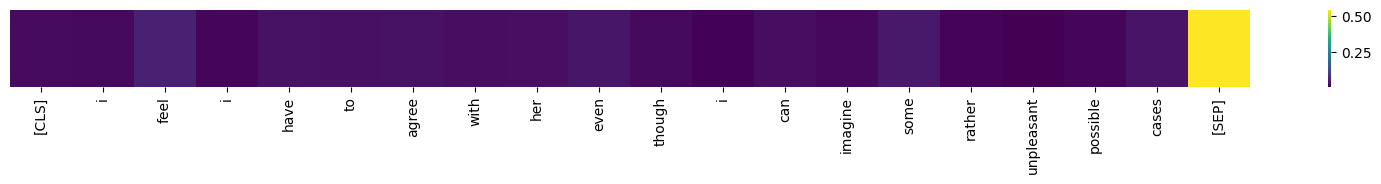

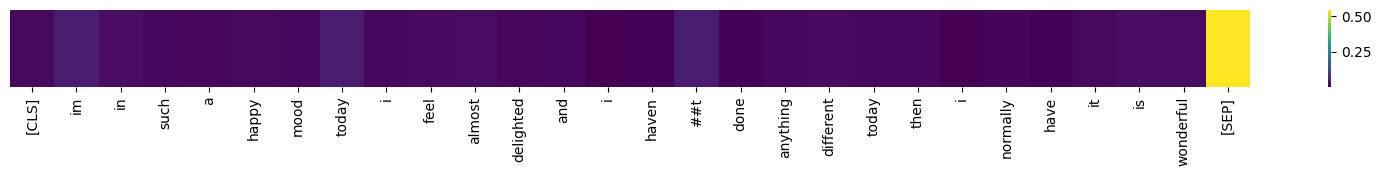

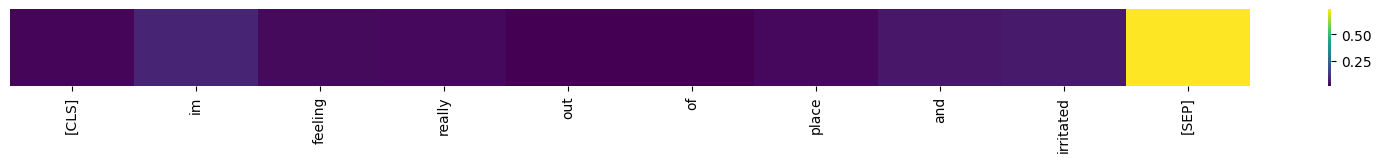

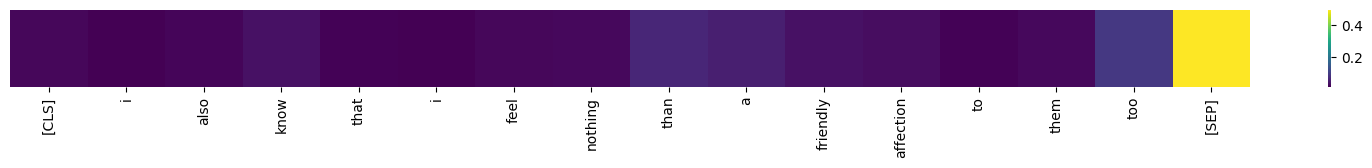

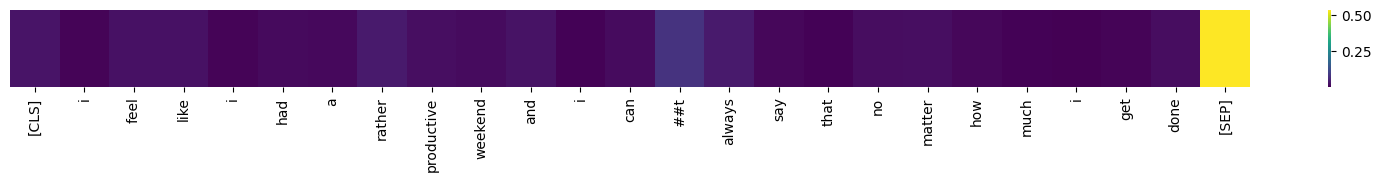

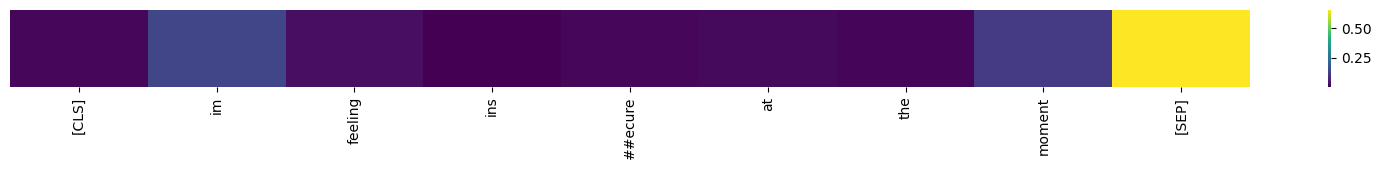

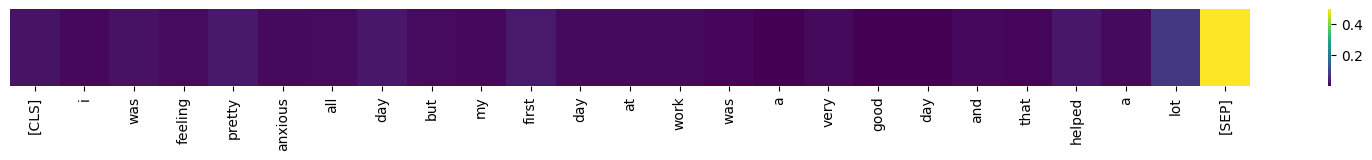

Average attention to key emotion words: {'happy': 0.015790332, 'irritated': 0.036993142, 'eager': 0.027926952, 'fearful': 0.045524947, 'anxious': 0.027395131, 'pleased': 0.006606714, 'comfortable': 0.01686129, 'optimistic': 0.037987236, 'rotten': 0.01645339, 'ambitious': 0.04910085, 'uncomfortable': 0.035805196, 'anger': 0.040809378, 'immature': 0.008824323, 'excitement': 0.012663607, 'agitated': 0.06433733, 'invaded': 0.023822159, 'helpless': 0.026129015, 'supportive': 0.050017565, 'outraged': 0.04997651, 'restless': 0.018368961, 'productive': 0.025373317, 'peaceful': 0.031029252, 'welcomed': 0.023793114, 'delighted': 0.01772971, 'tired': 0.01864875, 'mad': 0.02122748, 'rude': 0.006194225, 'honoured': 0.011035933, 'reassured': 0.037710823, 'friendly': 0.04485523}
Average attention for correct predictions: 0.06314617
Average attention for incorrect predictions: 0.05673889
Text: im feeling rather rotten so im not very ambitious right now
Predicted: 3, Actual: 0
Attention to key emotion 

In [ ]:
# Loop over the selected test data
subset_size = 50  # Adjust the range as needed
subset_test_data = test_data.select(range(subset_size))

for example in subset_test_data:
    text = example['text']
    input_ids = tokenizer.encode(text, return_tensors='pt')

    logits, attentions = predict_with_attention(text)
    predicted_label = logits.argmax(dim=1).item()
    actual_label = example['label']

    attention_matrix = analyze_attention(attentions, input_ids, tokenizer, head_num=8, block_num=8)
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    plot_attention_heatmap(attention_matrix, tokens)

    # Additional Analysis
    key_word_attention = attention_to_key_words(attention_matrix, tokens, emotion_words)
    mean_att, std_att = calculate_attention_stats(attention_matrix)

    # Collecting data for post-experiment analysis
    attention_details.append({
        "text": text,
        "predicted_label": predicted_label,
        "actual_label": actual_label,
        "key_word_attention": key_word_attention,
        "mean_attention": mean_att,
        "std_attention": std_att
    })

    # Separate collection for correct and incorrect predictions
    if predicted_label == actual_label:
        correct_predictions_attention.append(mean_att)
    else:
        incorrect_predictions_attention.append(mean_att)

    # Collect attention to emotion words
    for word, attention in key_word_attention.items():
        emotion_word_attention[word].append(attention)


# Analyze the collected data

# Average attention to emotion words
average_attention_per_word = {word: np.mean(attentions) for word, attentions in emotion_word_attention.items() if attentions}
print("Average attention to key emotion words:", average_attention_per_word)

# Comparison of attention in correct vs. incorrect predictions
print("Average attention for correct predictions:", np.mean(correct_predictions_attention))
print("Average attention for incorrect predictions:", np.mean(incorrect_predictions_attention))

# Error analysis on incorrect predictions
for detail in attention_details:
    if detail['predicted_label'] != detail['actual_label']:
        print(f"Text: {detail['text']}")
        print(f"Predicted: {detail['predicted_label']}, Actual: {detail['actual_label']}")
        print(f"Attention to key emotion words: {detail['key_word_attention']}\n")



**Head:2 ; Block:11**

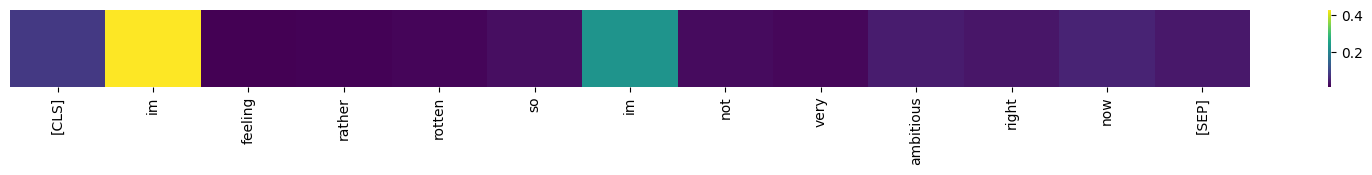

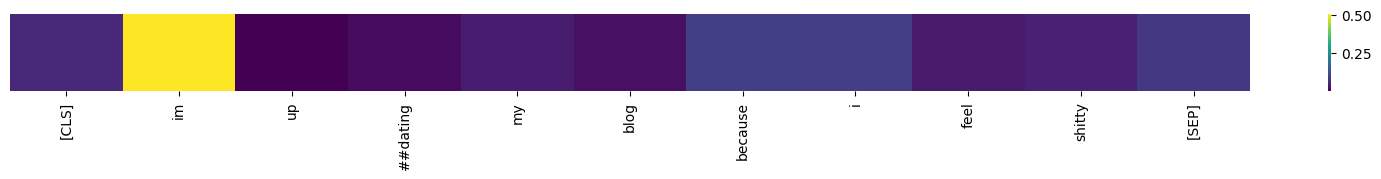

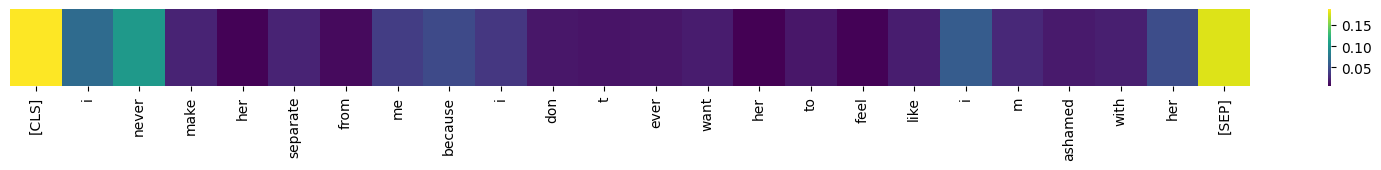

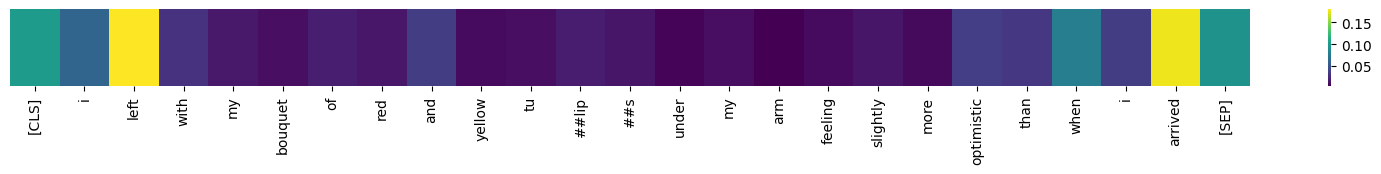

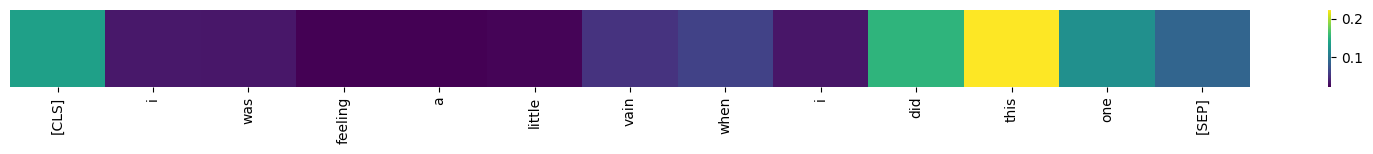

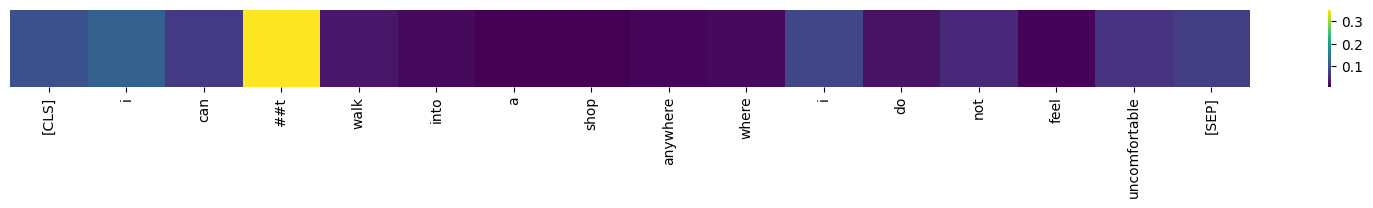

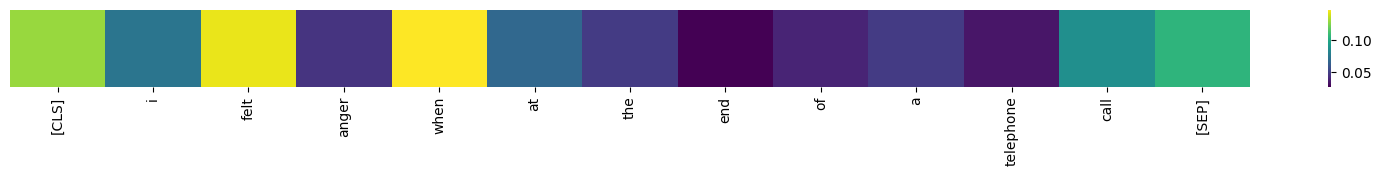

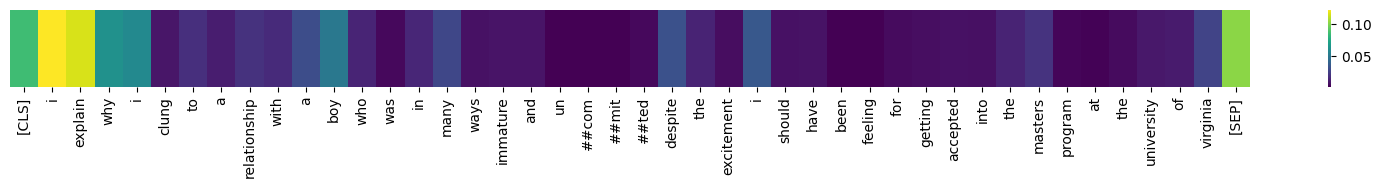

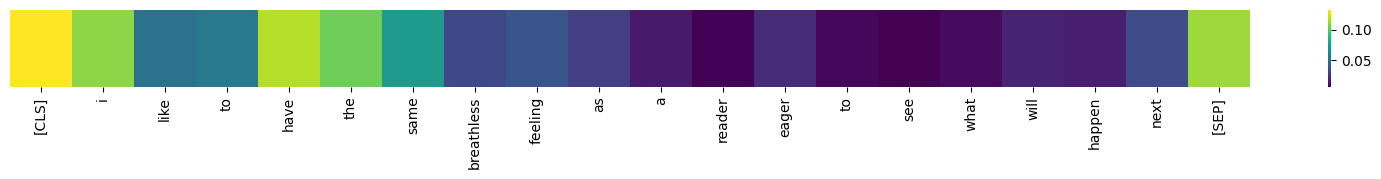

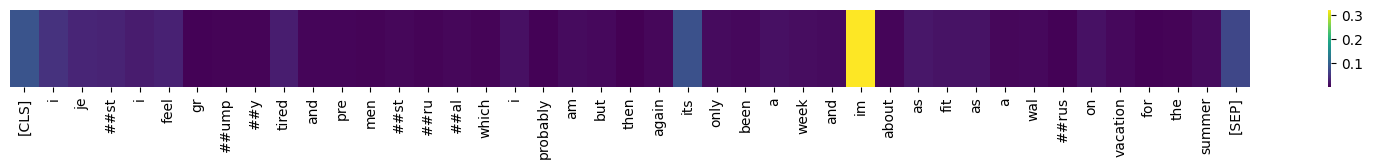

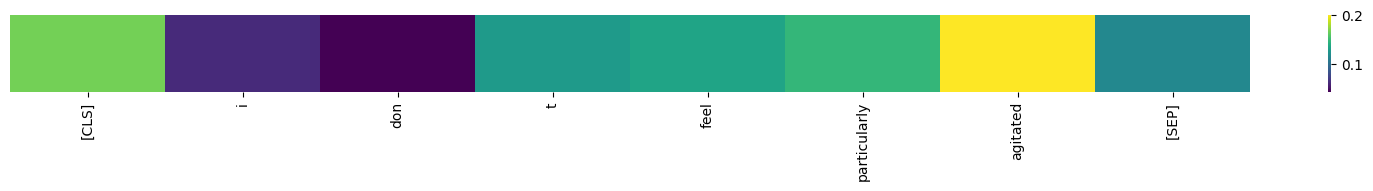

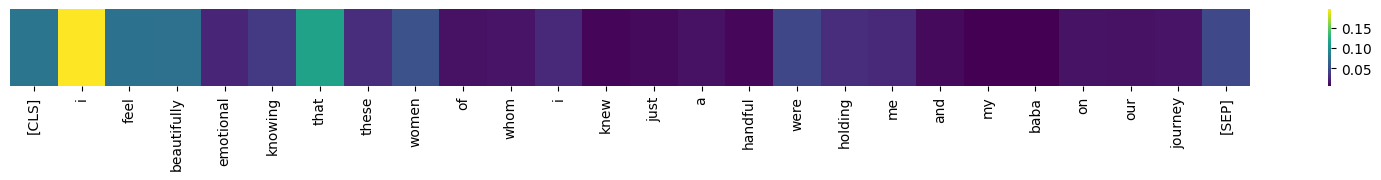

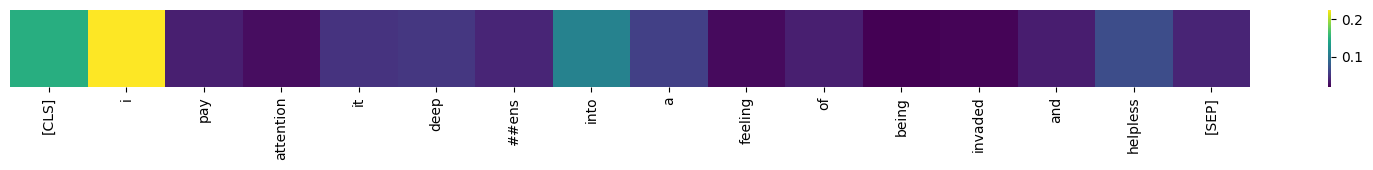

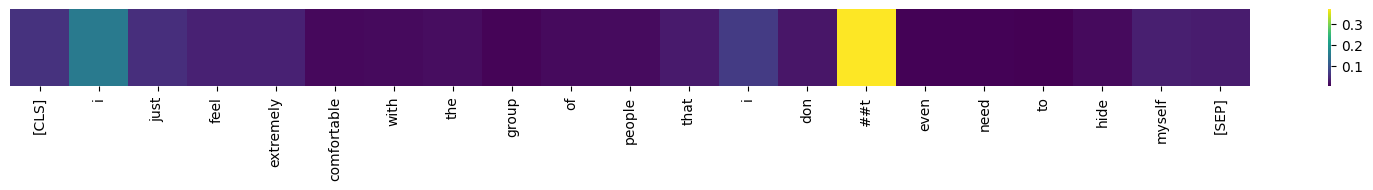

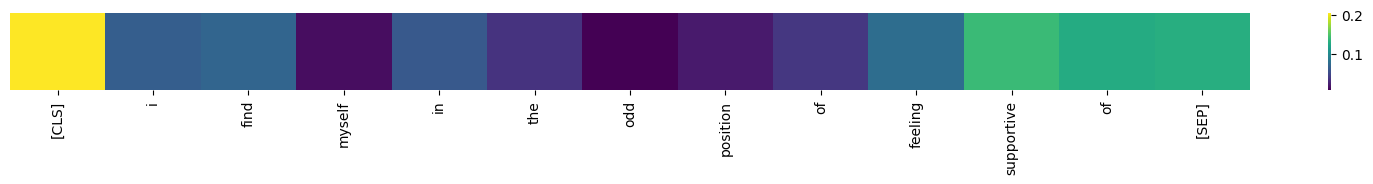

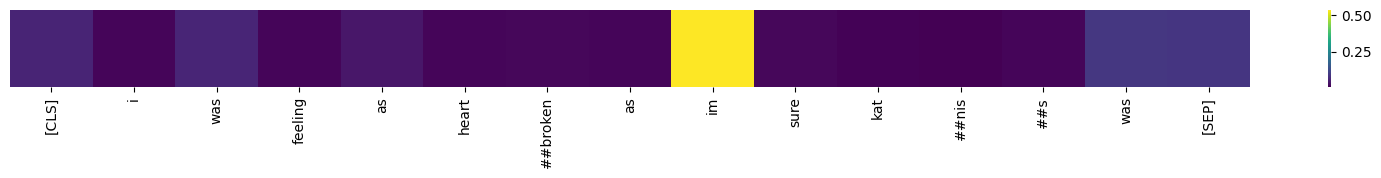

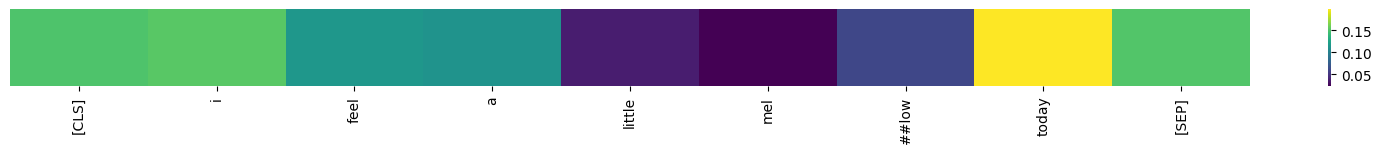

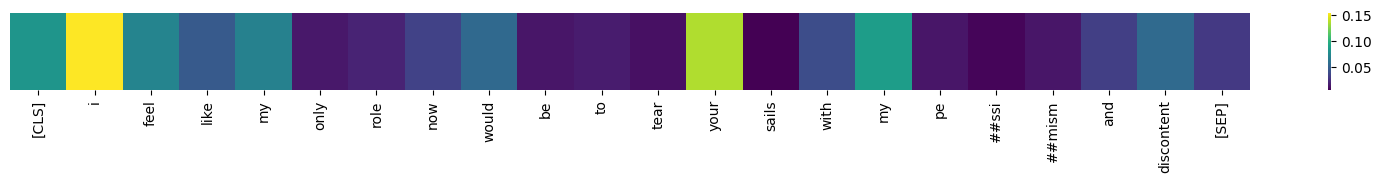

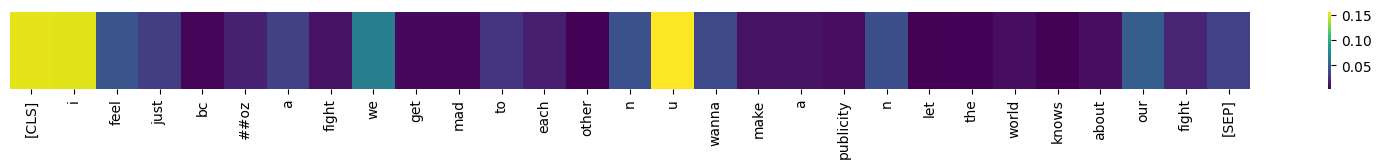

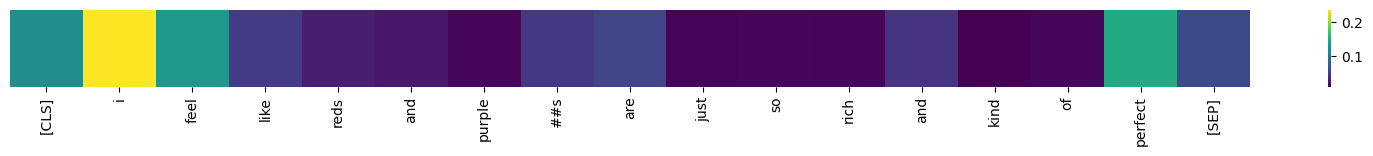

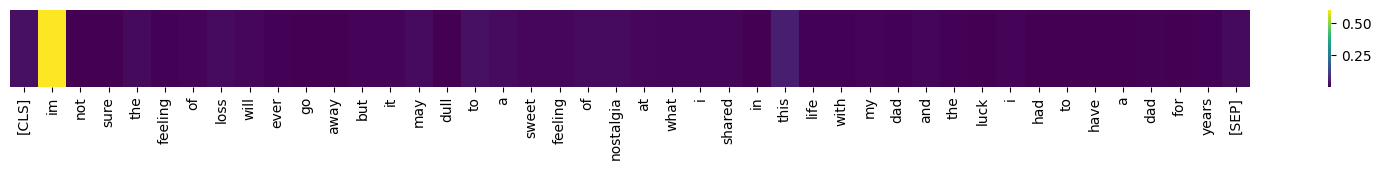

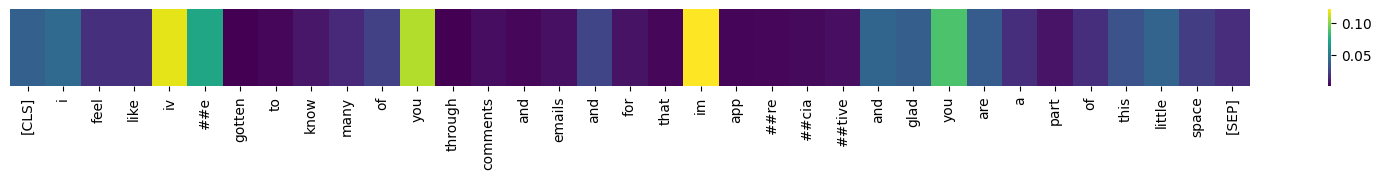

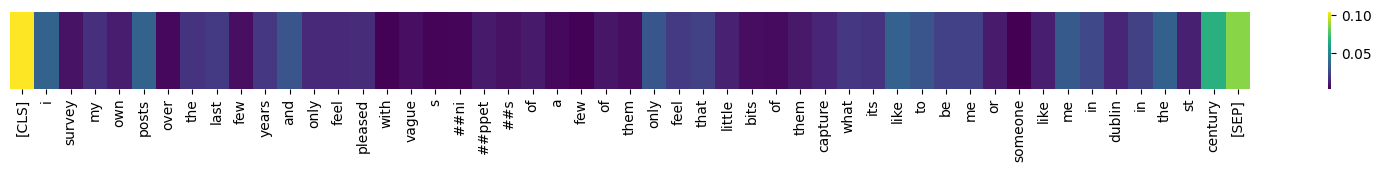

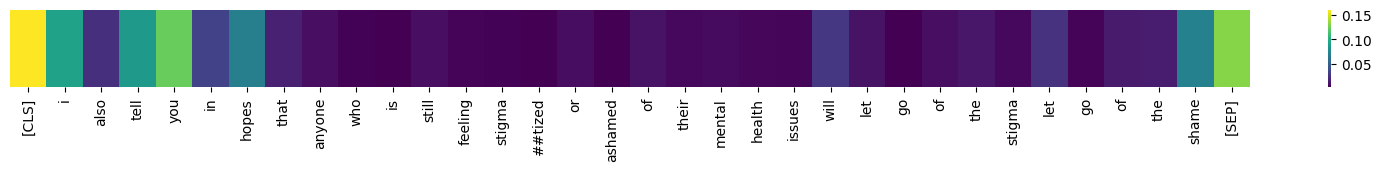

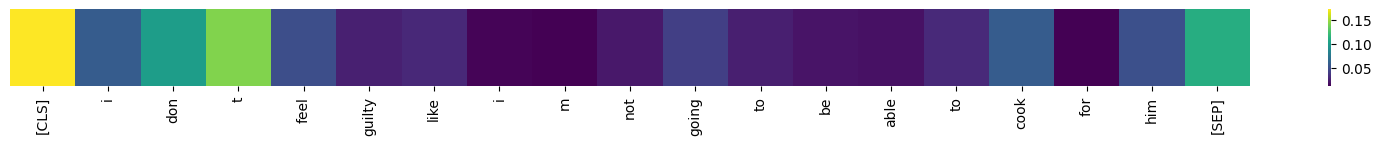

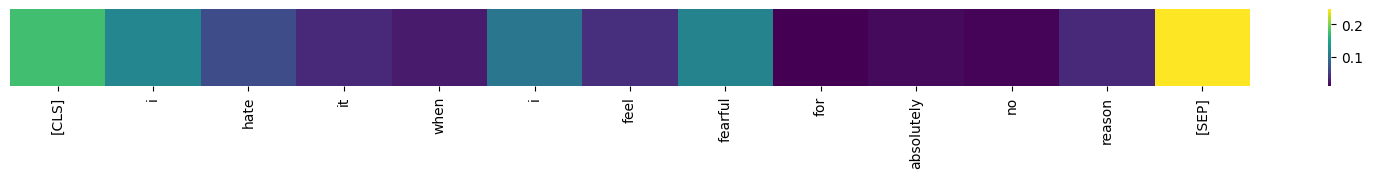

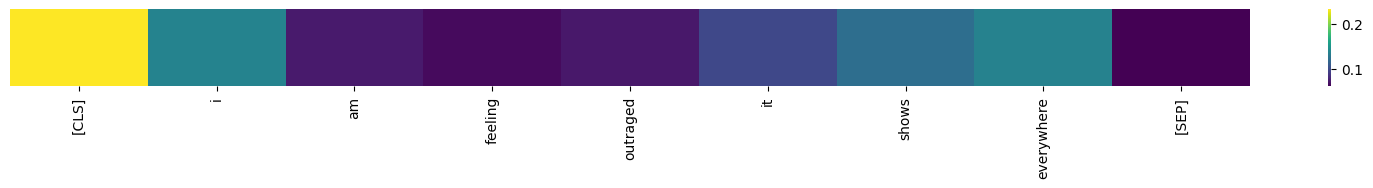

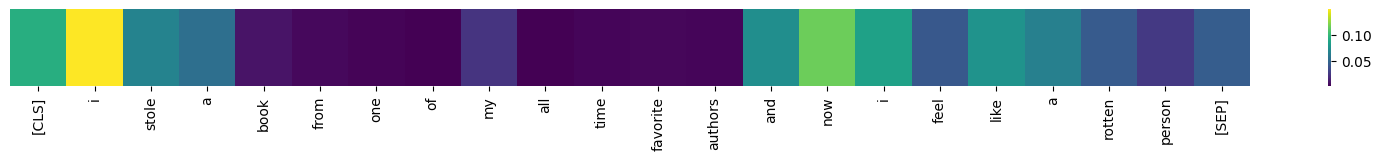

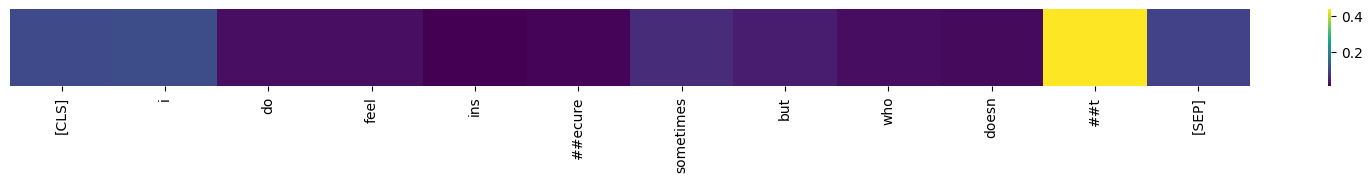

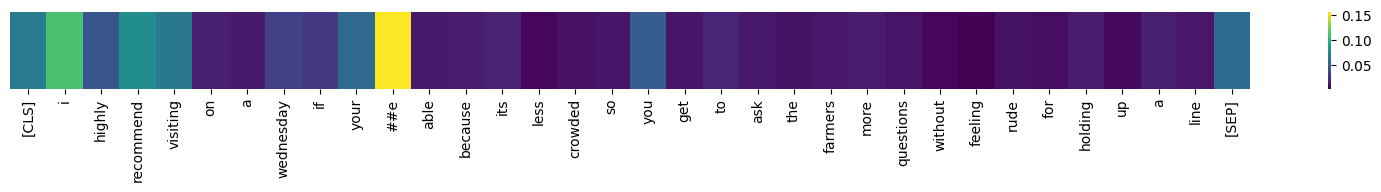

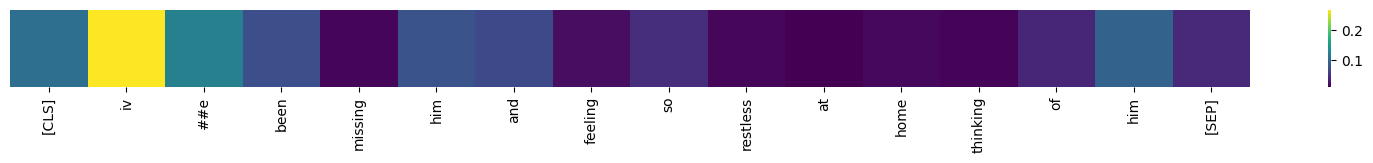

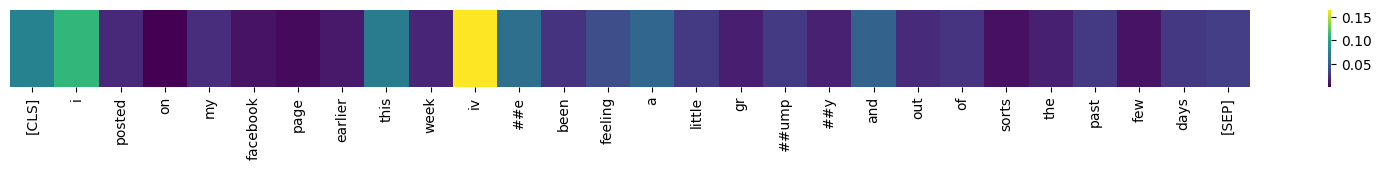

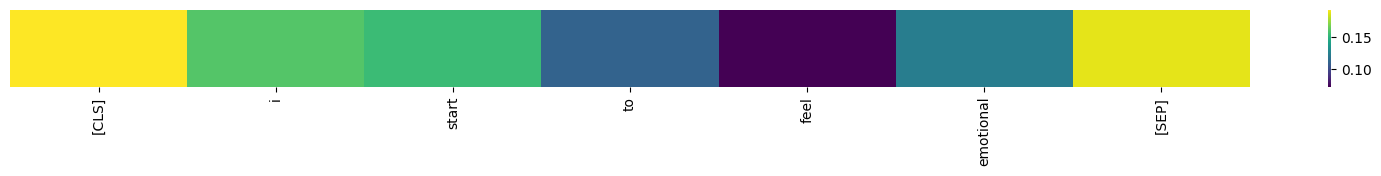

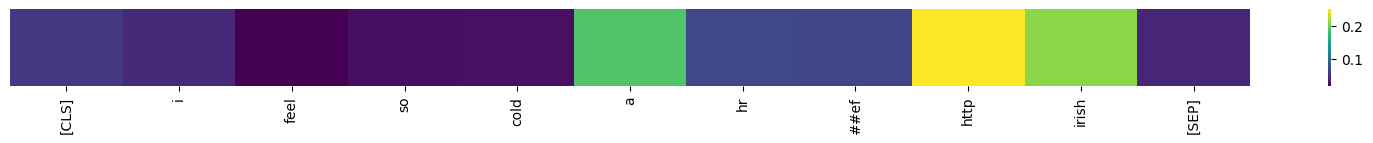

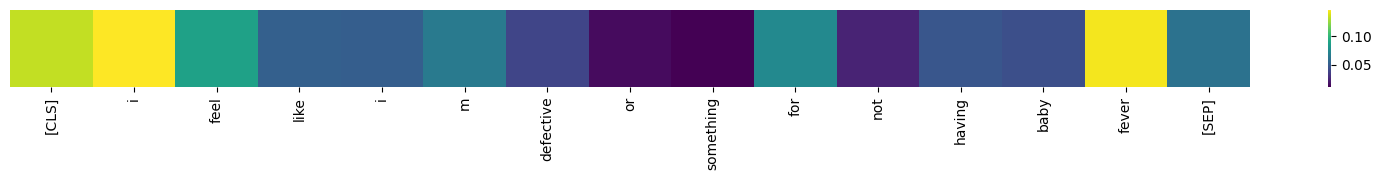

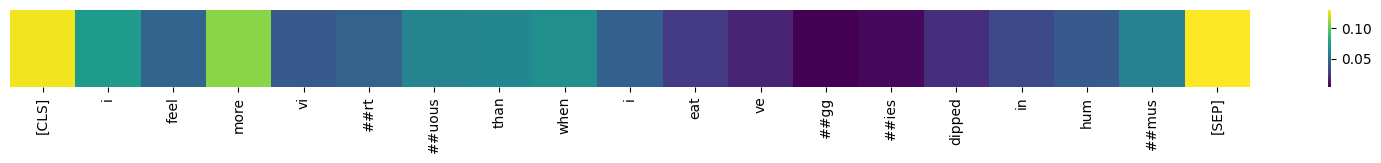

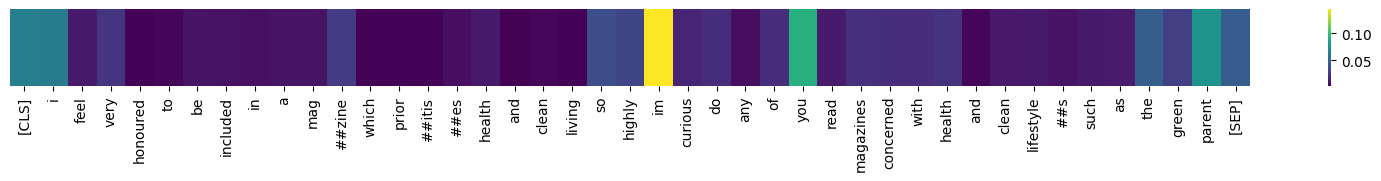

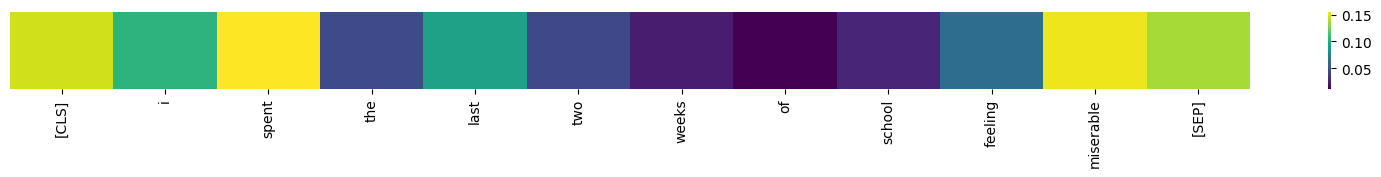

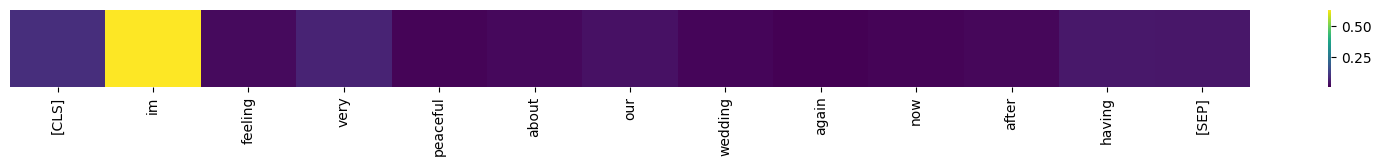

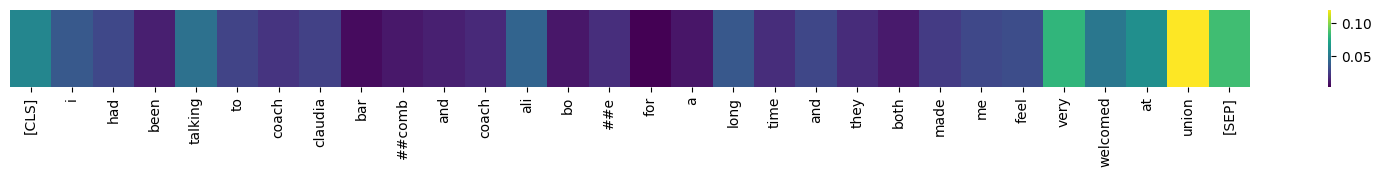

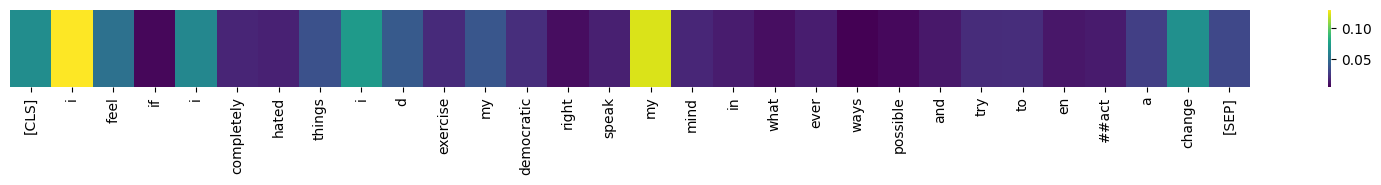

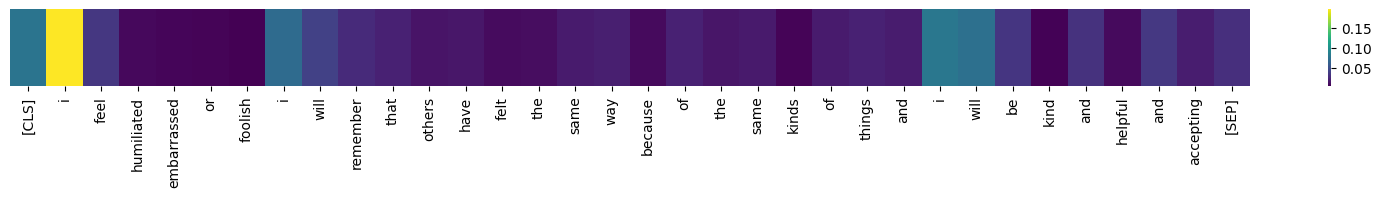

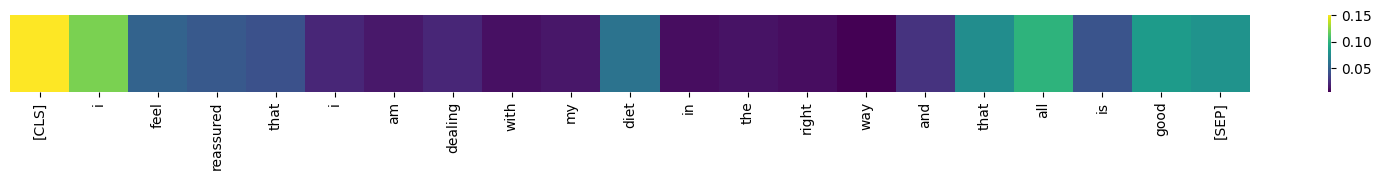

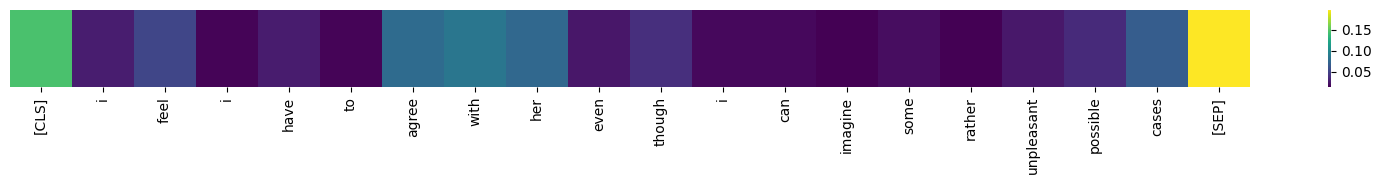

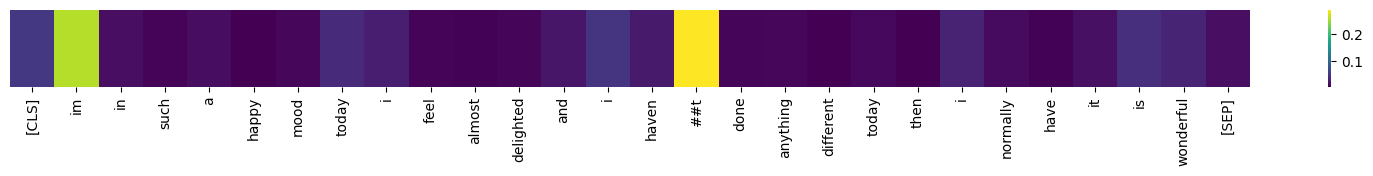

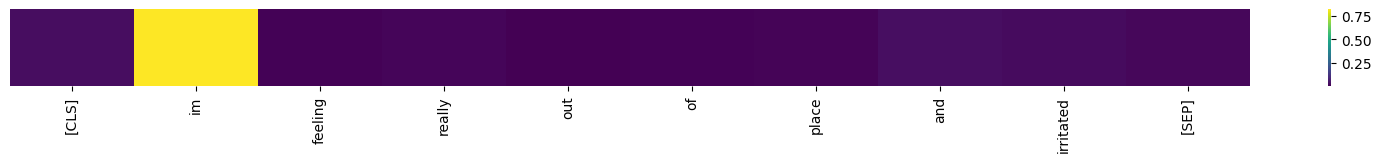

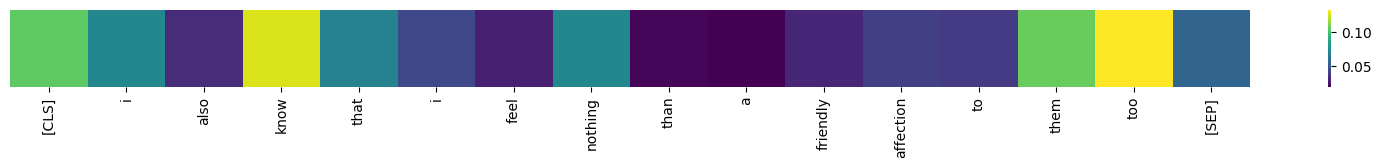

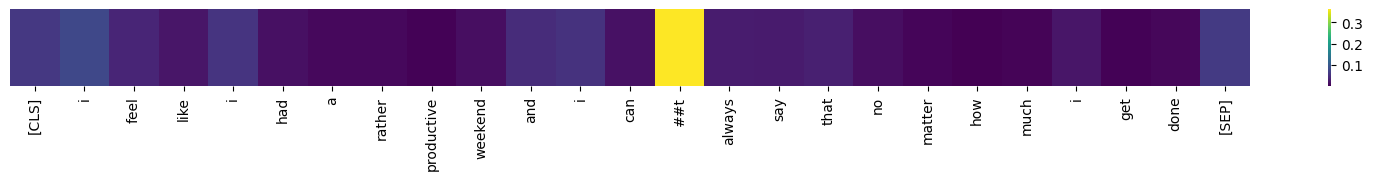

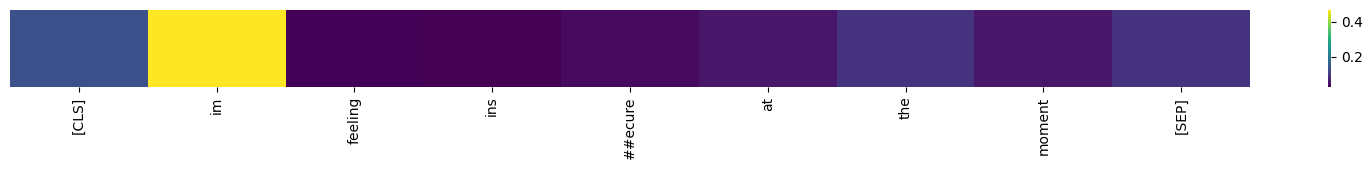

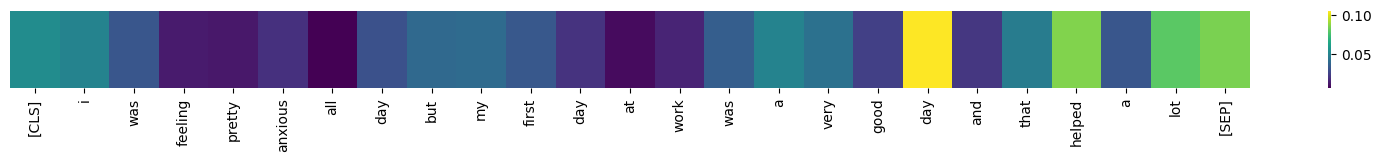

Average attention to key emotion words: {'happy': 0.013361971, 'irritated': 0.035763852, 'eager': 0.026537467, 'fearful': 0.05949222, 'anxious': 0.025970925, 'pleased': 0.008370568, 'comfortable': 0.015889151, 'optimistic': 0.037370164, 'rotten': 0.019049475, 'ambitious': 0.04769583, 'uncomfortable': 0.04041648, 'anger': 0.041693658, 'immature': 0.0086680595, 'excitement': 0.011197029, 'agitated': 0.09151329, 'invaded': 0.023493674, 'helpless': 0.03445837, 'supportive': 0.06814802, 'outraged': 0.054492734, 'restless': 0.017591497, 'productive': 0.021155108, 'peaceful': 0.026729956, 'welcomed': 0.029136727, 'delighted': 0.015629873, 'tired': 0.02029123, 'mad': 0.018320268, 'rude': 0.006915161, 'honoured': 0.009396258, 'reassured': 0.039242376, 'friendly': 0.042224158}
Average attention for correct predictions: 0.06314617
Average attention for incorrect predictions: 0.056738883
Text: im feeling rather rotten so im not very ambitious right now
Predicted: 3, Actual: 0
Attention to key emot

In [ ]:
# Loop over the selected test data
subset_size = 50  # Adjust the range as needed
subset_test_data = test_data.select(range(subset_size))

for example in subset_test_data:
    text = example['text']
    input_ids = tokenizer.encode(text, return_tensors='pt')

    logits, attentions = predict_with_attention(text)
    predicted_label = logits.argmax(dim=1).item()
    actual_label = example['label']

    attention_matrix = analyze_attention(attentions, input_ids, tokenizer, head_num=2, block_num=11)
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    plot_attention_heatmap(attention_matrix, tokens)

    # Additional Analysis
    key_word_attention = attention_to_key_words(attention_matrix, tokens, emotion_words)
    mean_att, std_att = calculate_attention_stats(attention_matrix)

    # Collecting data for post-experiment analysis
    attention_details.append({
        "text": text,
        "predicted_label": predicted_label,
        "actual_label": actual_label,
        "key_word_attention": key_word_attention,
        "mean_attention": mean_att,
        "std_attention": std_att
    })

    # Separate collection for correct and incorrect predictions
    if predicted_label == actual_label:
        correct_predictions_attention.append(mean_att)
    else:
        incorrect_predictions_attention.append(mean_att)

    # Collect attention to emotion words
    for word, attention in key_word_attention.items():
        emotion_word_attention[word].append(attention)


# Analyze the collected data

# Average attention to emotion words
average_attention_per_word = {word: np.mean(attentions) for word, attentions in emotion_word_attention.items() if attentions}
print("Average attention to key emotion words:", average_attention_per_word)

# Comparison of attention in correct vs. incorrect predictions
print("Average attention for correct predictions:", np.mean(correct_predictions_attention))
print("Average attention for incorrect predictions:", np.mean(incorrect_predictions_attention))

# Error analysis on incorrect predictions
for detail in attention_details:
    if detail['predicted_label'] != detail['actual_label']:
        print(f"Text: {detail['text']}")
        print(f"Predicted: {detail['predicted_label']}, Actual: {detail['actual_label']}")
        print(f"Attention to key emotion words: {detail['key_word_attention']}\n")



**Head:8 ; Block 11**

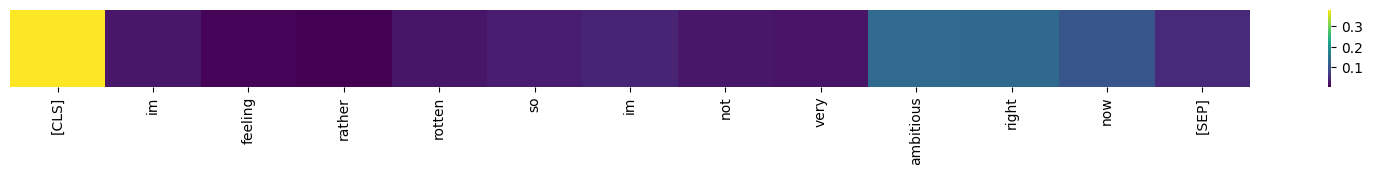

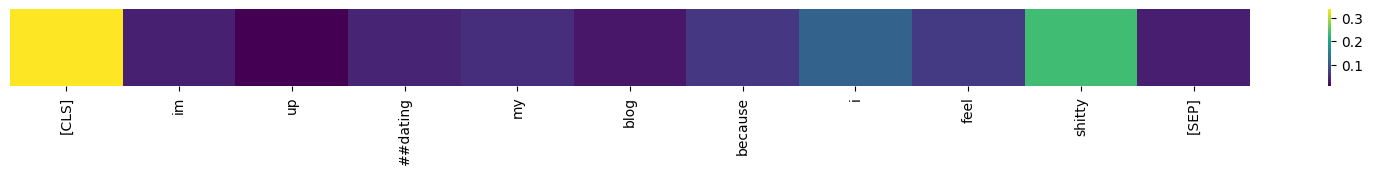

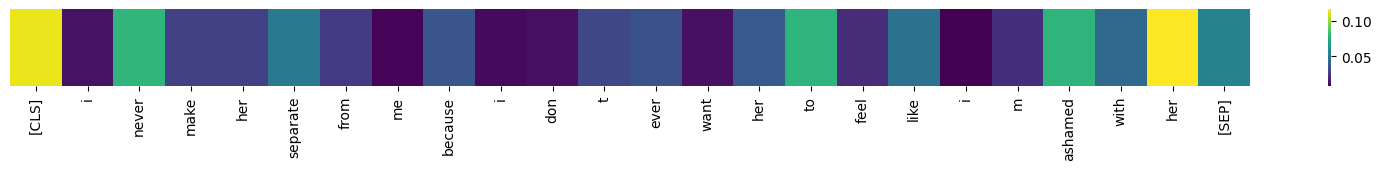

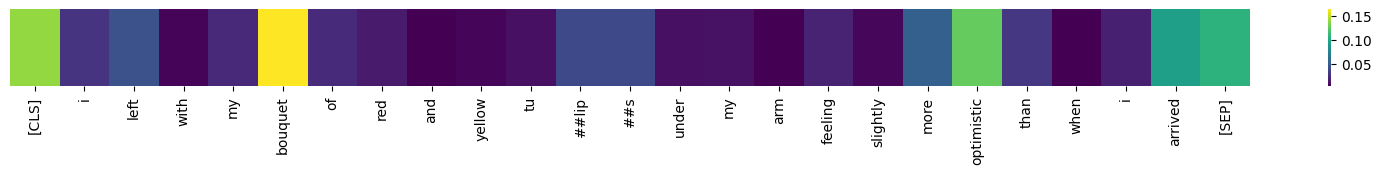

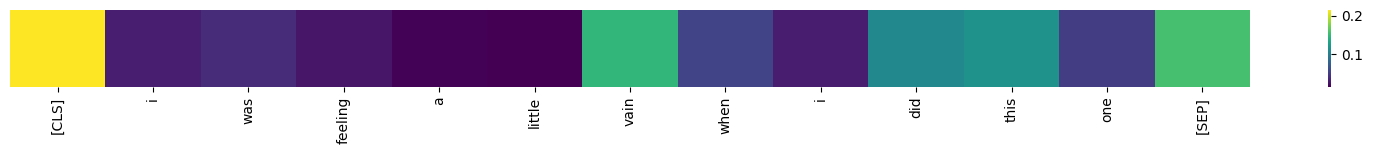

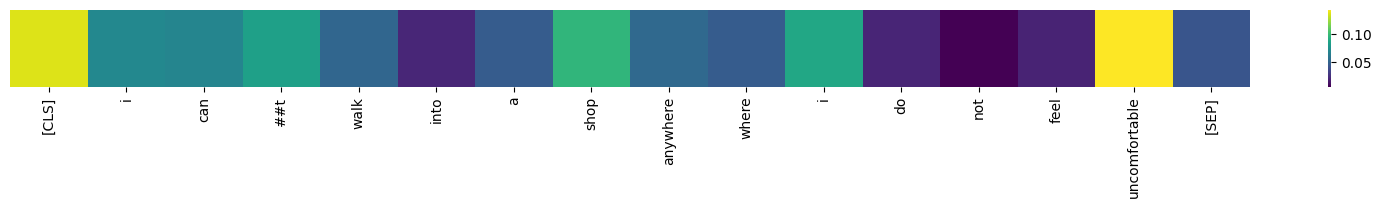

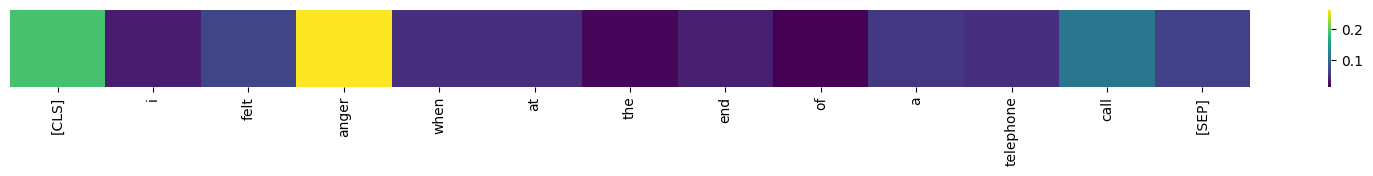

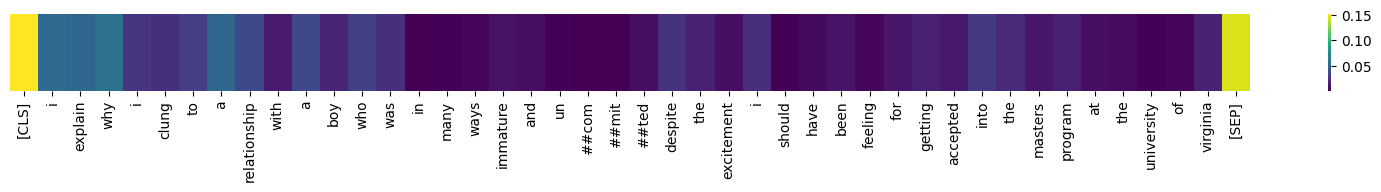

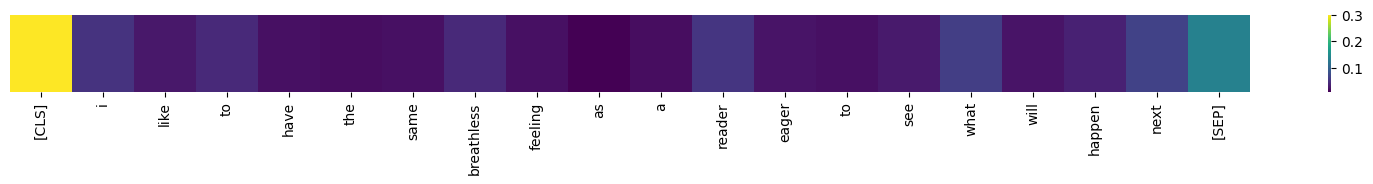

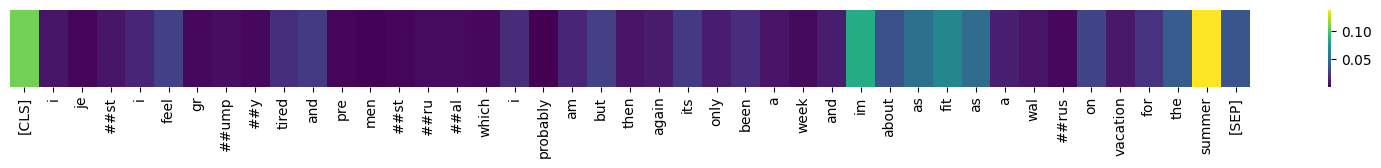

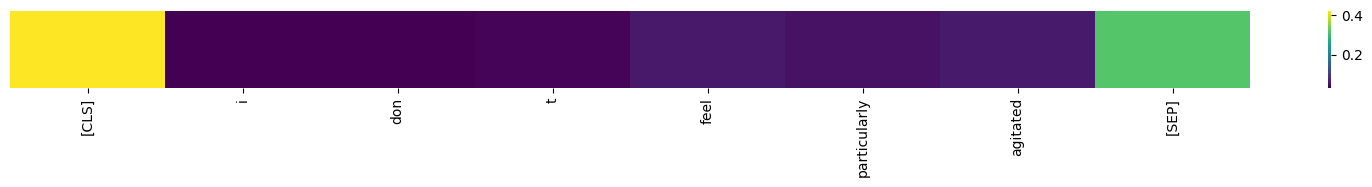

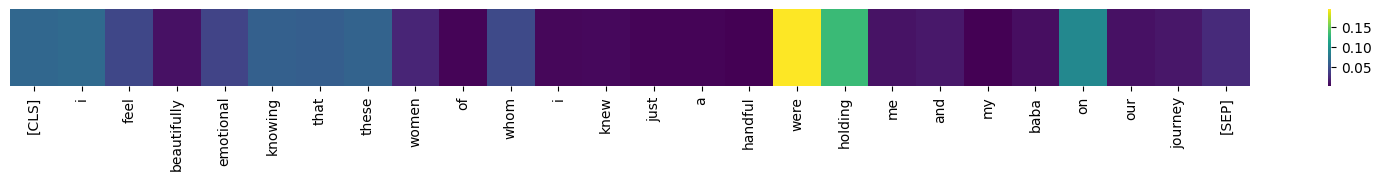

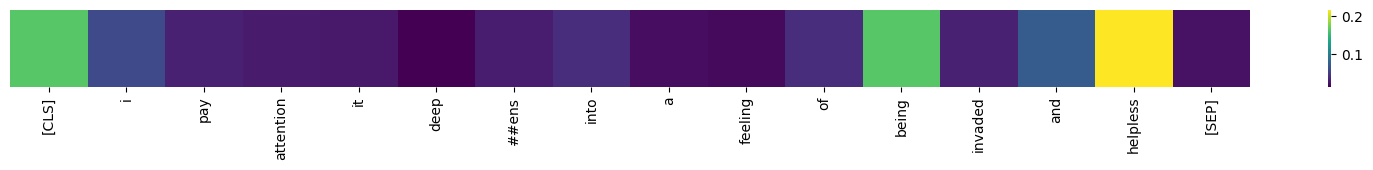

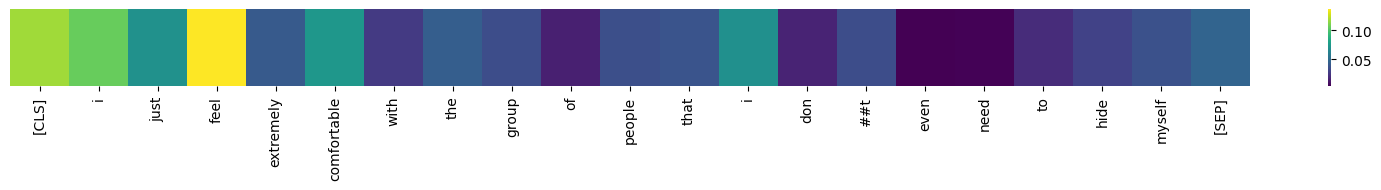

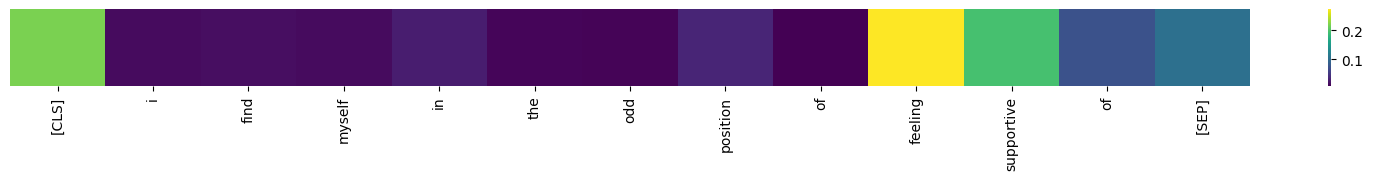

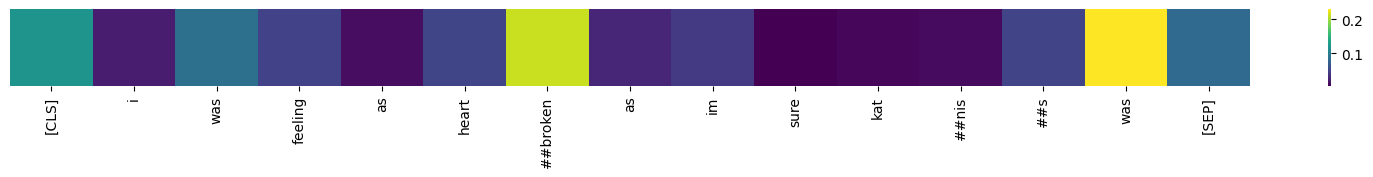

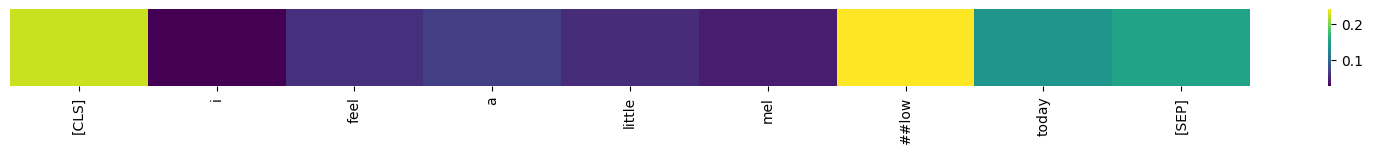

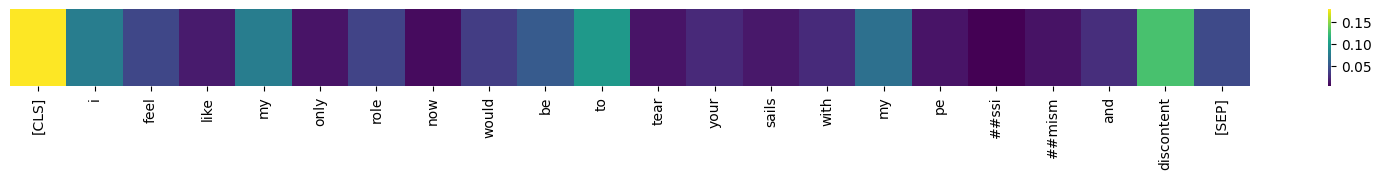

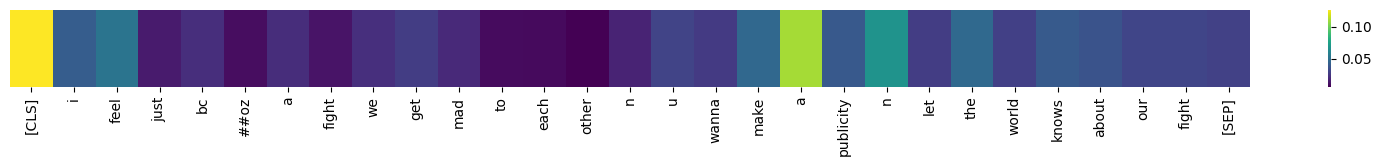

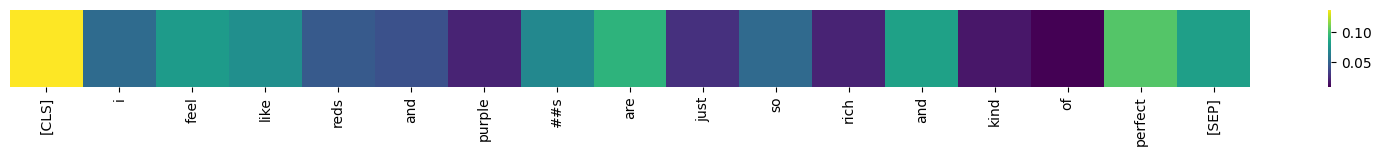

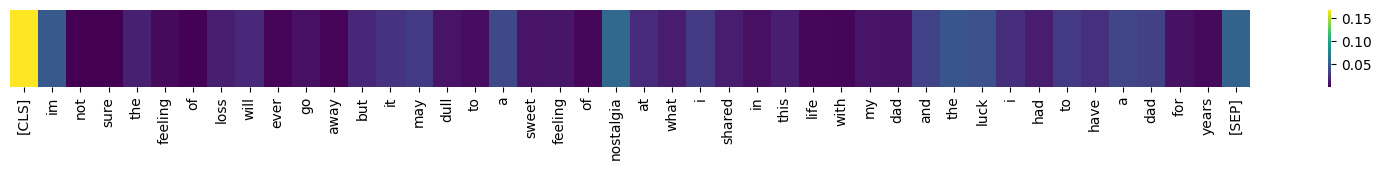

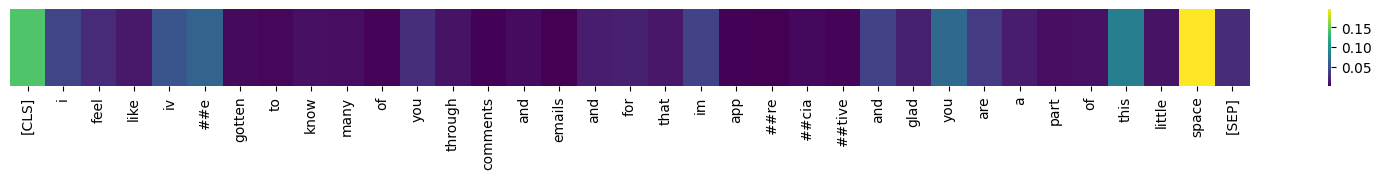

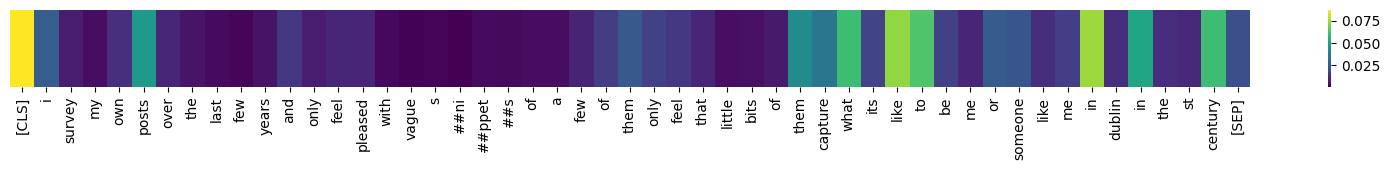

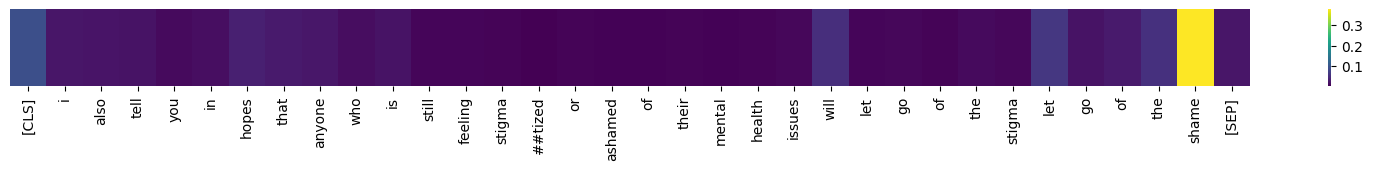

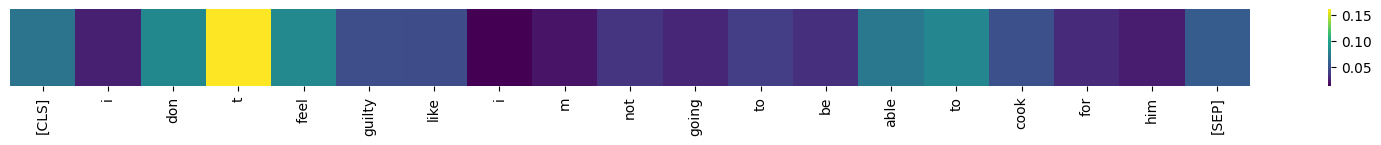

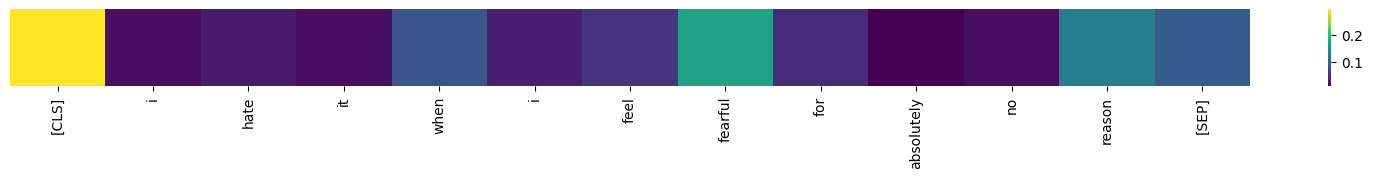

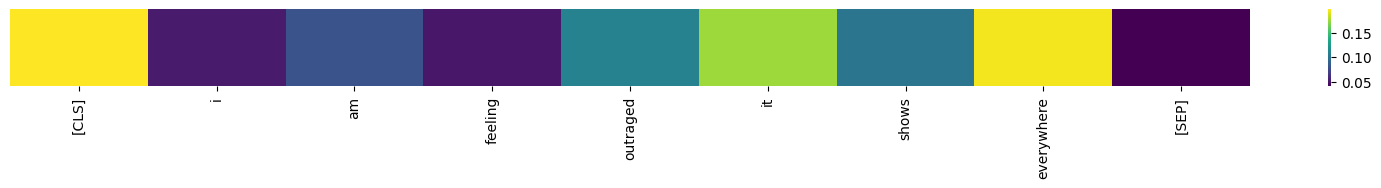

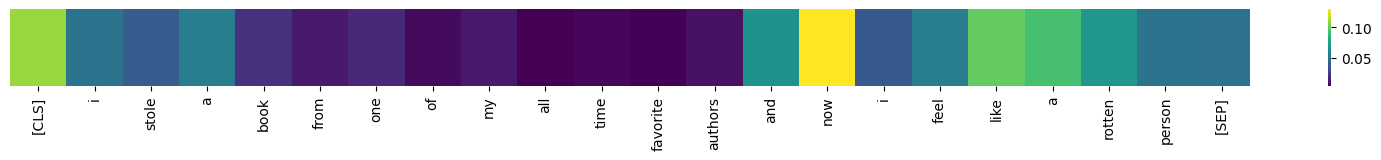

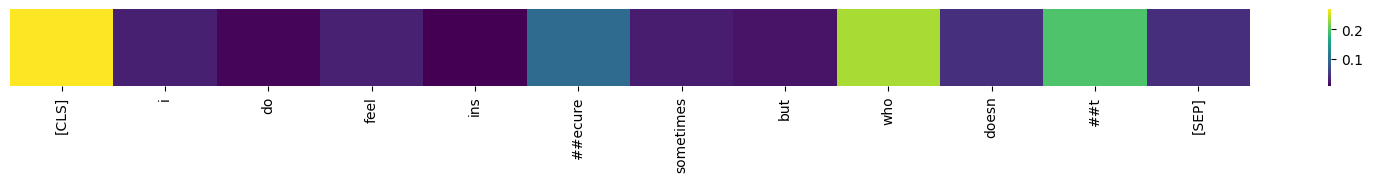

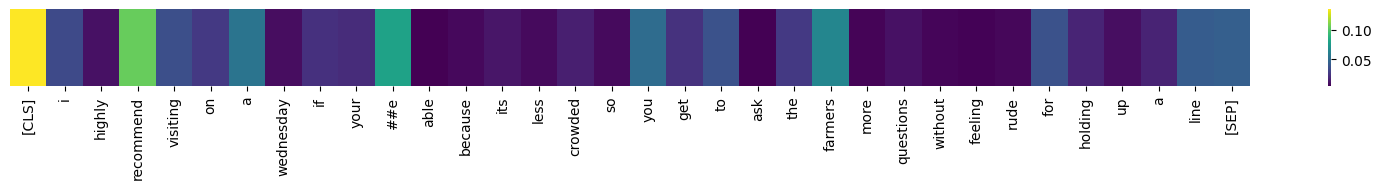

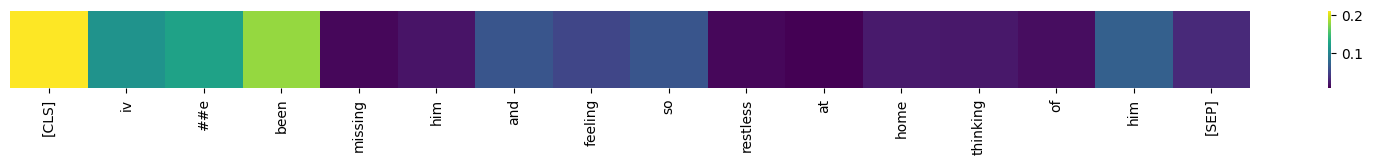

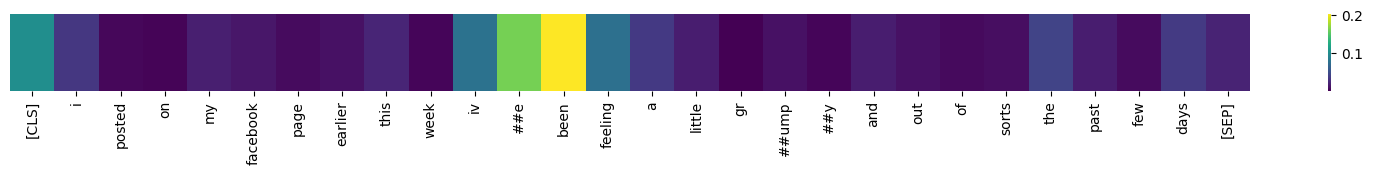

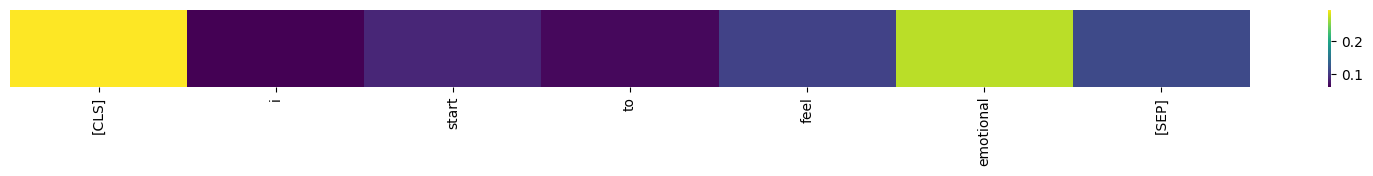

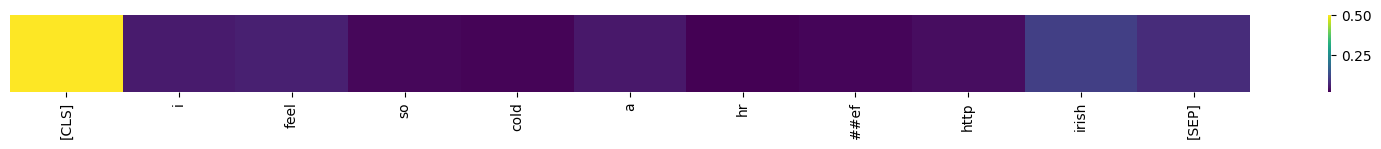

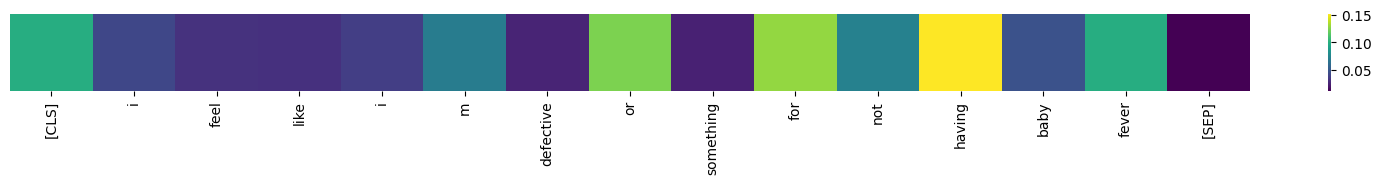

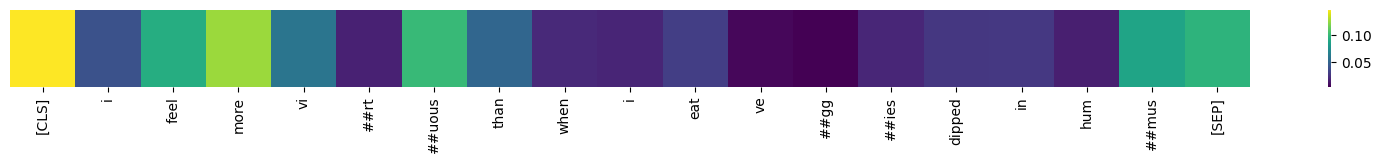

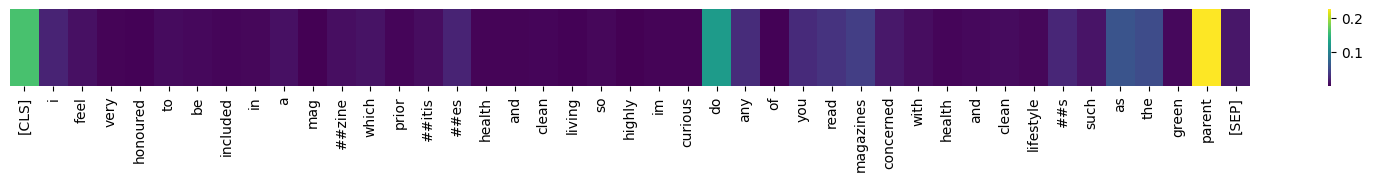

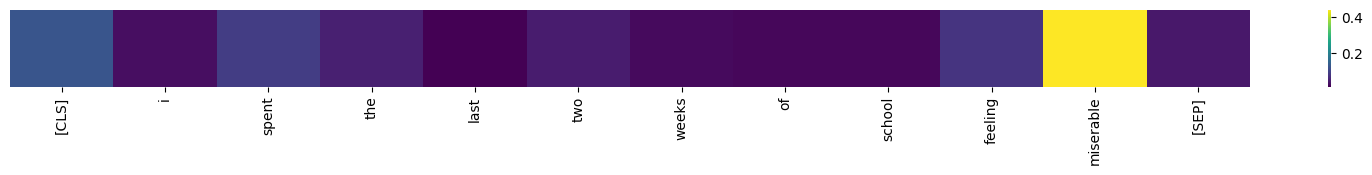

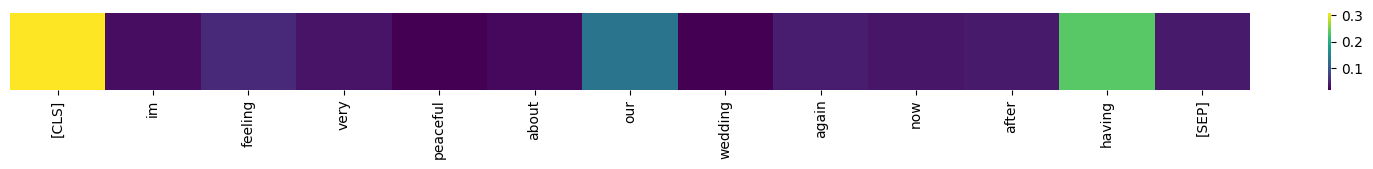

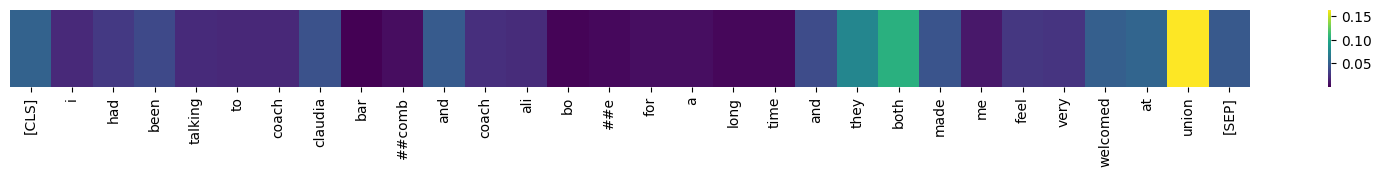

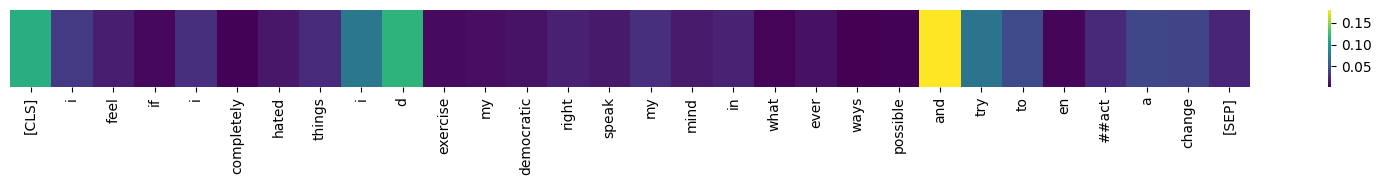

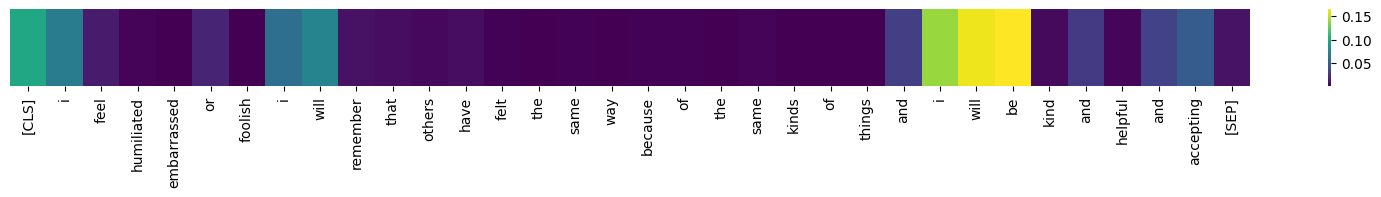

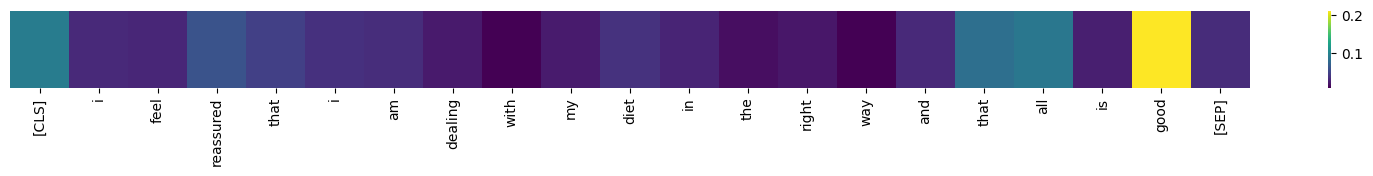

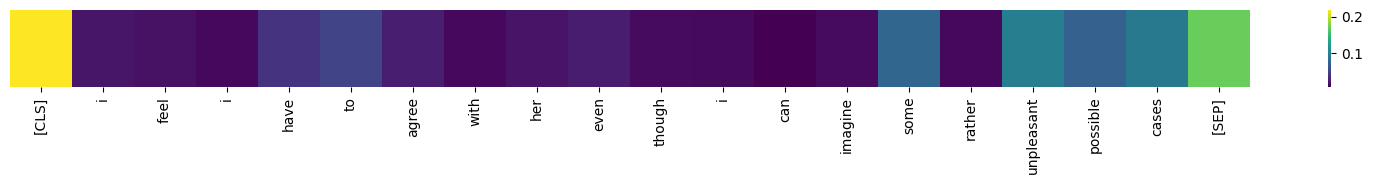

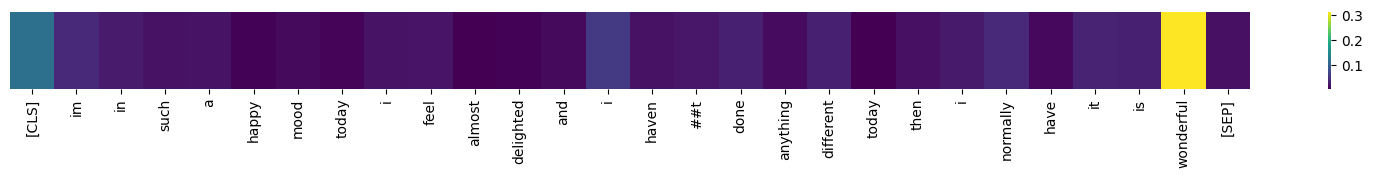

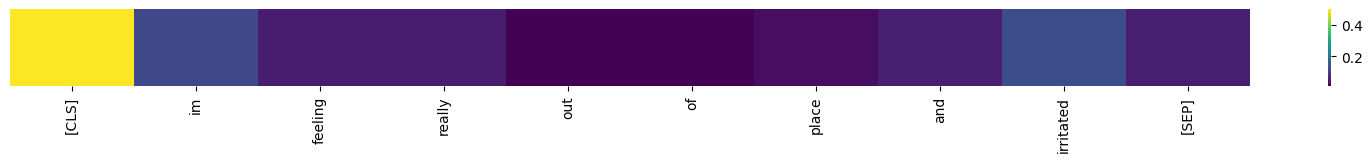

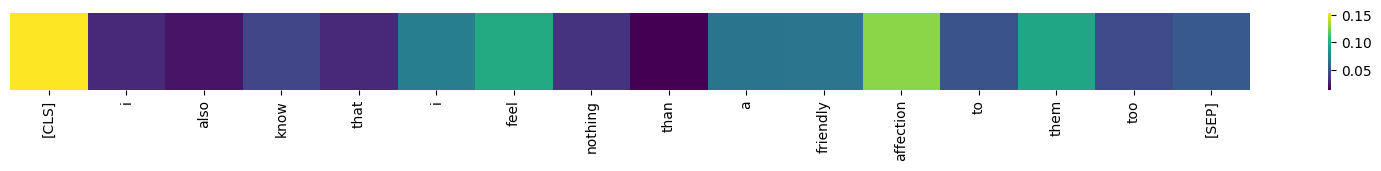

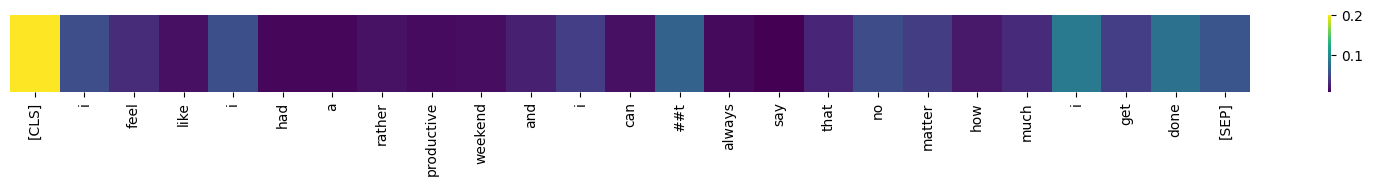

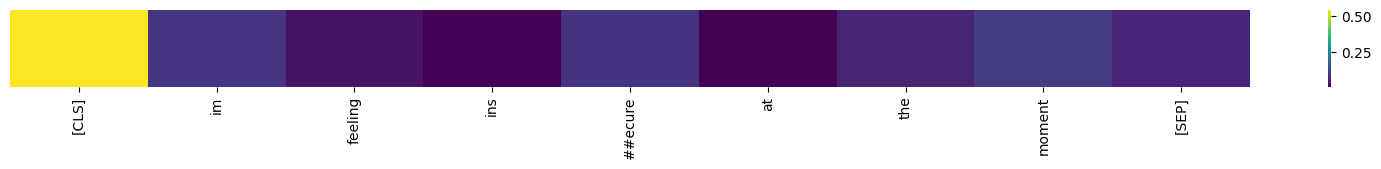

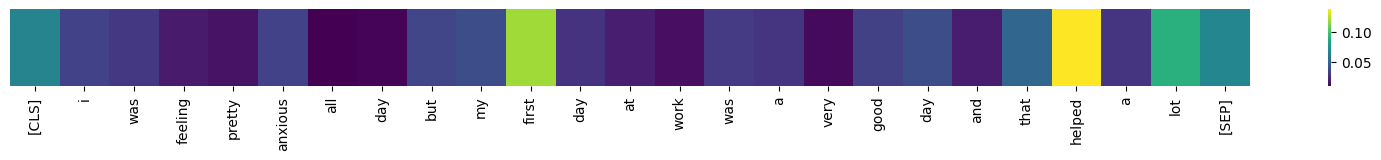

Average attention to key emotion words: {'happy': 0.012298312, 'irritated': 0.050525058, 'eager': 0.026010355, 'fearful': 0.07831657, 'anxious': 0.027279183, 'pleased': 0.008535543, 'comfortable': 0.02563326, 'optimistic': 0.05217743, 'rotten': 0.023992872, 'ambitious': 0.06199351, 'uncomfortable': 0.057382017, 'anger': 0.07843591, 'immature': 0.00867382, 'excitement': 0.010488231, 'agitated': 0.08595874, 'invaded': 0.025255362, 'helpless': 0.06483715, 'supportive': 0.08918216, 'outraged': 0.06370939, 'restless': 0.016531201, 'productive': 0.019654775, 'peaceful': 0.025315395, 'welcomed': 0.032503575, 'delighted': 0.014139552, 'tired': 0.020105148, 'mad': 0.018592736, 'rude': 0.0069243726, 'honoured': 0.008134396, 'reassured': 0.042992543, 'friendly': 0.04650406}
Average attention for correct predictions: 0.06314617
Average attention for incorrect predictions: 0.056738883
Text: im feeling rather rotten so im not very ambitious right now
Predicted: 3, Actual: 0
Attention to key emotion 

In [ ]:
# Loop over the selected test data
subset_size = 50  # Adjust the range as needed
subset_test_data = test_data.select(range(subset_size))

for example in subset_test_data:
    text = example['text']
    input_ids = tokenizer.encode(text, return_tensors='pt')

    logits, attentions = predict_with_attention(text)
    predicted_label = logits.argmax(dim=1).item()
    actual_label = example['label']

    attention_matrix = analyze_attention(attentions, input_ids, tokenizer, head_num=8, block_num=11)
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    plot_attention_heatmap(attention_matrix, tokens)

    # Additional Analysis
    key_word_attention = attention_to_key_words(attention_matrix, tokens, emotion_words)
    mean_att, std_att = calculate_attention_stats(attention_matrix)

    # Collecting data for post-experiment analysis
    attention_details.append({
        "text": text,
        "predicted_label": predicted_label,
        "actual_label": actual_label,
        "key_word_attention": key_word_attention,
        "mean_attention": mean_att,
        "std_attention": std_att
    })

    # Separate collection for correct and incorrect predictions
    if predicted_label == actual_label:
        correct_predictions_attention.append(mean_att)
    else:
        incorrect_predictions_attention.append(mean_att)

    # Collect attention to emotion words
    for word, attention in key_word_attention.items():
        emotion_word_attention[word].append(attention)


# Analyze the collected data

# Average attention to emotion words
average_attention_per_word = {word: np.mean(attentions) for word, attentions in emotion_word_attention.items() if attentions}
print("Average attention to key emotion words:", average_attention_per_word)

# Comparison of attention in correct vs. incorrect predictions
print("Average attention for correct predictions:", np.mean(correct_predictions_attention))
print("Average attention for incorrect predictions:", np.mean(incorrect_predictions_attention))

# Error analysis on incorrect predictions
for detail in attention_details:
    if detail['predicted_label'] != detail['actual_label']:
        print(f"Text: {detail['text']}")
        print(f"Predicted: {detail['predicted_label']}, Actual: {detail['actual_label']}")
        print(f"Attention to key emotion words: {detail['key_word_attention']}\n")

